Project - Ariel Hedvat and Yuval Rubinstein

In [82]:
import pandas as pd
import numpy as np
from sklearn import feature_selection
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
from sklearn import datasets, ensemble
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, IsolationForest
from sklearn.impute import SimpleImputer
from typing import List, Dict
from sklearn.cluster import DBSCAN, KMeans
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, normaltest, chi2_contingency
from sklearn.feature_selection import RFECV
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import ExtraTreesClassifier
warnings.filterwarnings('ignore')
%matplotlib inline

Loading the data:

In [83]:
### load the df

df = pd.read_csv("train.csv")
testing_df = pd.read_csv("test.csv")
pd.set_option('display.max_columns', None)
sns.set(color_codes=True)

In [84]:
print(df.shape)
df.head()

(60000, 24)


sha256     size      vsize  \
0  a5d72c609a1594621e8eb775e7324d4fc291d5569cfefd...  6744064  6799360.0   
1  ccaa49b76e6fd84842399c4389e2086a5a3687dfabbf01...    22016    45056.0   
2  b0b126adc73b980a114e38027b082d149fcf491547452f...   686136   704512.0   
3  ff6176c53ca9b58040c93870c264843b93b5e290c28e57...     8192    36864.0   
4  59b8bc6ac157a553440978406c8aa8eb8a25c166af1175...   396288   421888.0   

   imports  exports  has_debug  has_relocations  has_resources  has_signature  \
0    524.0      3.0        0.0              1.0            1.0            0.0   
1      2.0      0.0        0.0              0.0            1.0            0.0   
2    133.0      4.0        1.0              1.0            1.0            1.0   
3      6.0      0.0        0.0              0.0            0.0            0.0   
4    133.0      0.0        1.0              1.0            1.0            0.0   

   has_tls  symbols  numstrings  paths  urls  registry    MZ  printables  \
0      1.0      0.0     64882.0    0.0   0.0       0.0  28.0    899075.0   
1      0.0      0.0        89.0    0.0   0.0       0.0   1.0       856.0   
2      0.0      0.0      2699.0    0.0  32.0       0.0   2.0     32767.0   
3      0.0      NaN        71.0    0.0   0.0       0.0   1.0       678.0   
4      0.0      0.0      4729.0    0.0   0.0       0.0   5.0     35881.0   

    avlength                            file_type_trid  file_type_prob_trid  \
0  13.857079  Win32 EXE PECompact compressed (generic)                 64.2   
1   9.617978      Win32 Dynamic Link Library (generic)                 38.4   
2  12.140422                Win64 Executable (generic)                 82.0   
3   9.549296                Win64 Executable (generic)                 28.0   
4   7.587439                Win64 Executable (generic)                 32.2   

          A         B    C  label  
0 -3.978981  5.732354   er      1  
1  7.064133  5.738201   er      0  
2  1.052727  5.722733  gow      0  
3  2.217531  5.896053   vh      1  
4  9.401164       NaN   vh      1

In [85]:
#calculating the number of missing values in each column of a DataFrame and creates a copy of the DataFrame with missing values filled in with 0

missing_values = df.isnull().sum()
print(missing_values)

main_df = df.copy()

sha256                    0
size                      0
vsize                  1935
imports                1739
exports                2093
has_debug              2927
has_relocations        3324
has_resources          1961
has_signature          1937
has_tls                2898
symbols                2656
numstrings             2718
paths                  3660
urls                   2349
registry               2525
MZ                     3089
printables             2739
avlength               2757
file_type_trid            0
file_type_prob_trid       0
A                      3704
B                      3751
C                      2051
label                     0
dtype: int64


Exploration: 

Our questions and thoughts on the data:

1. What are the correlations between features / label in our data
2. How do our features distribute and does the label affect them
3. How can we understand the features meaning / effects

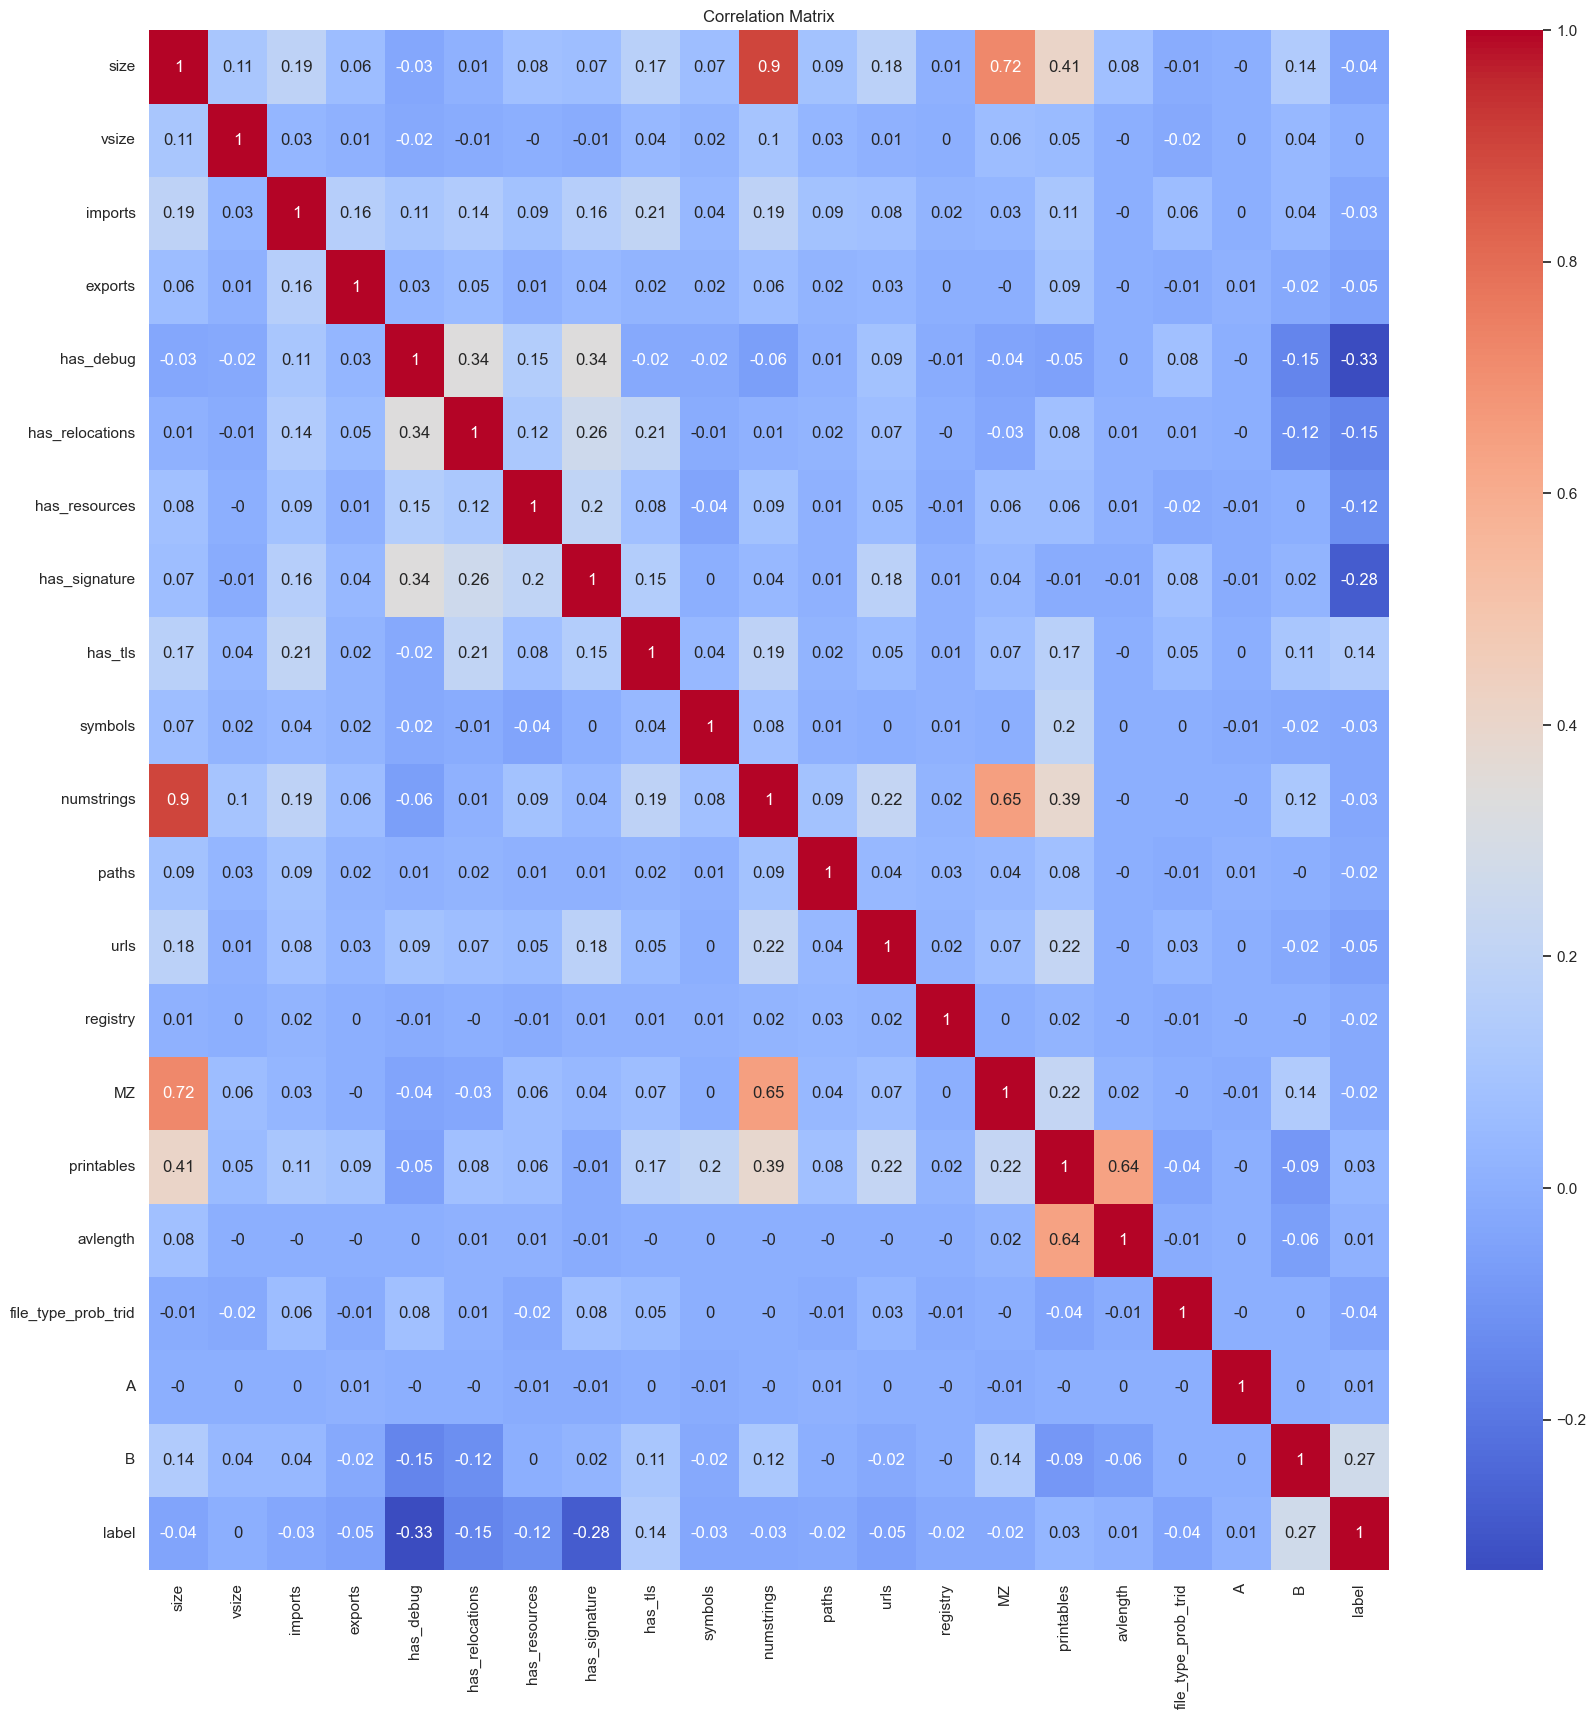

In [86]:
corr_matrix = main_df.corr().round(2)
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.title("Correlation Matrix")
plt.show()

Understanding the correlation table from first glance:

1. We can see unknown features such as 'A' and 'B' which we can't understand yet why they are correlated with other features since we don't know their business meaning.

2. We can see some correlations that we would expect such as size and printables but also we noticed one that we would like to understand such as "MZ" and 'Size' and their connection


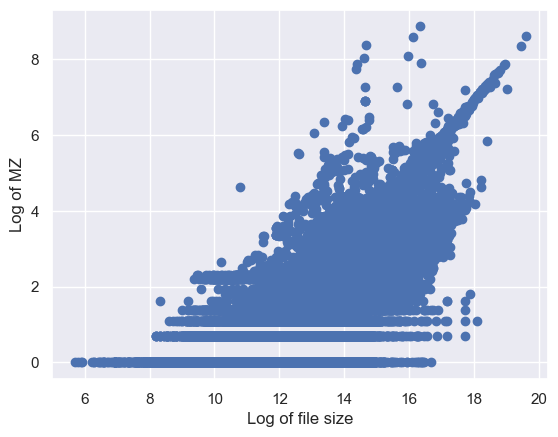

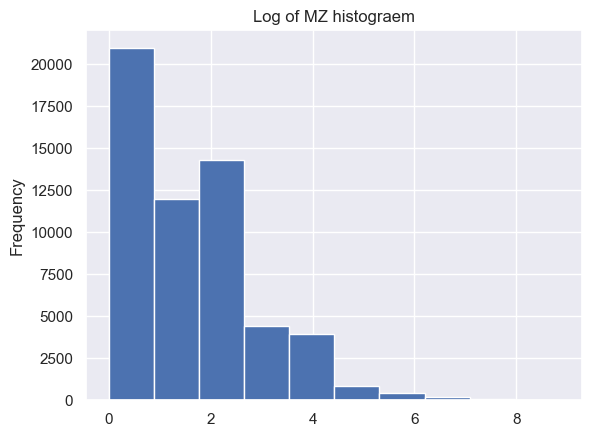

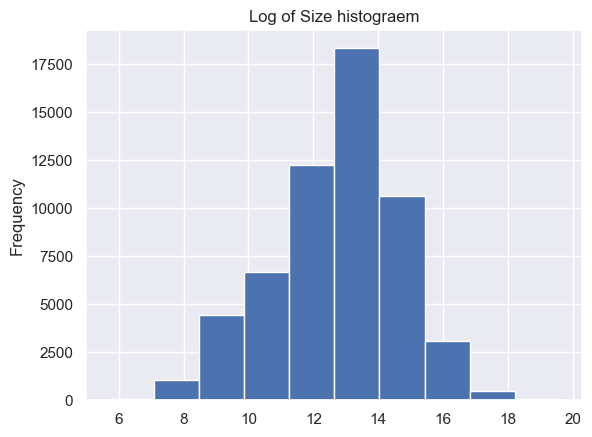

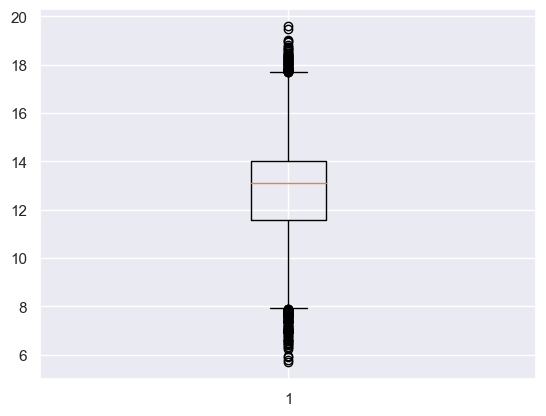

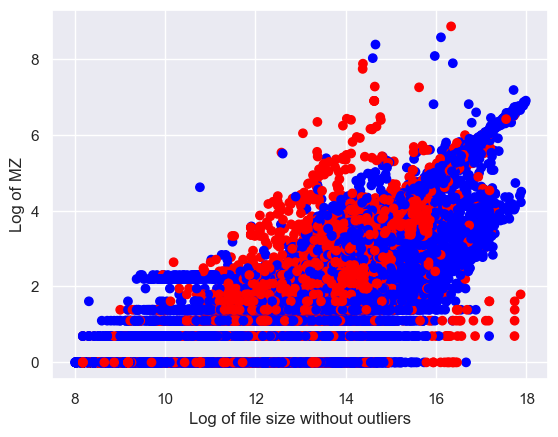

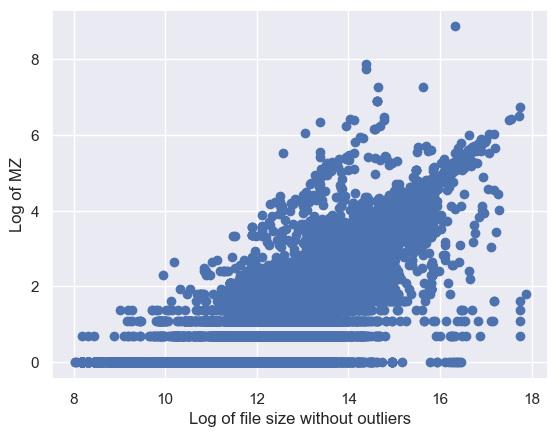

In [87]:
### understanding the MZ 

mz = main_df[main_df["MZ"] > 0]["MZ"]
size = main_df[main_df["MZ"] > 0]["size"]

logSize = np.log(size)
logMZ = np.log(mz)
plt.scatter(logSize, logMZ)
plt.xlabel("Log of file size")
plt.ylabel('Log of MZ')
plt.show()
plt.title("Log of MZ histograem")
logMZ.plot.hist()
plt.show()
plt.title("Log of Size histograem")
logSize.plot.hist()
plt.show()
plt.boxplot(logSize)
plt.show()

logSize_no_out = logSize[(logSize < 18) & (logSize > 8)]
MZ_no_out = main_df[(main_df["MZ"] > 0) & ((logSize < 18) & (logSize > 8))]["MZ"]
labels = main_df[(main_df["MZ"] > 0) & ((logSize < 18) & (logSize > 8))]['label']
label_colors = {1: 'red', 0: 'blue'}
plt.scatter(logSize_no_out, np.log(MZ_no_out), c=[label_colors[label] for label in labels])
plt.xlabel("Log of file size without outliers")
plt.ylabel('Log of MZ')
plt.show()
logSize_mal = logSize_no_out[(labels==1)]
mz_mal = MZ_no_out[(labels==1)]
plt.scatter(logSize_mal, np.log(mz_mal))
plt.xlabel("Log of file size without outliers")
plt.ylabel('Log of MZ')
plt.show()

Understanding MZ and Size:

While exploring the connection between size and MZ we noticed two things:

1. the connection between the log of each feature seem to correlate relatively in a linear way.
2. the data we explore is in very large numbers! what can it mean? it means that we might want to work not with the standard features themselves but with the log of base 10. The next steps will be transforming the data and understanding how transformations change the distributions of each feature.

There are 60000 observations


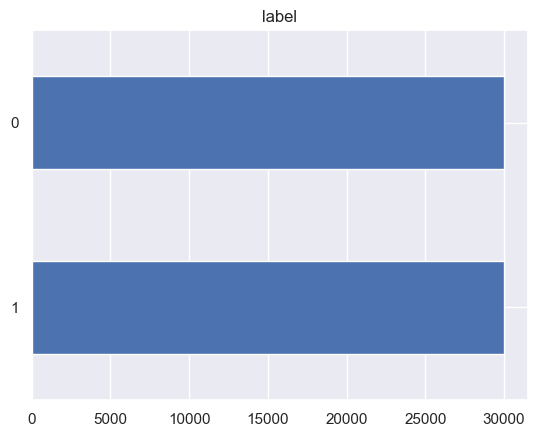

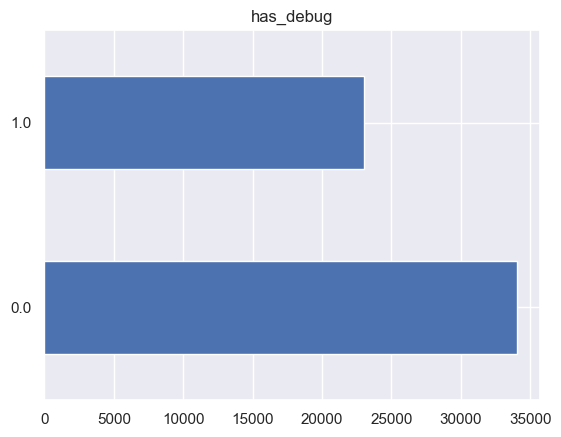

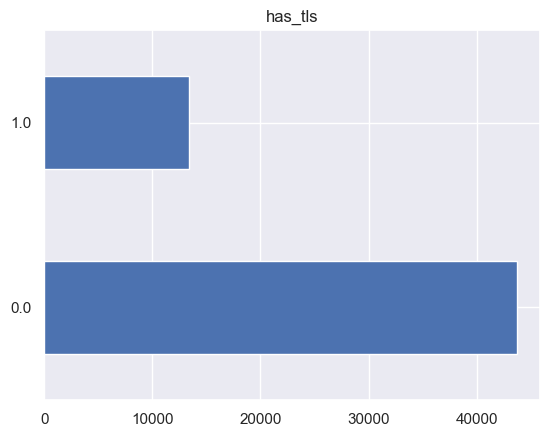

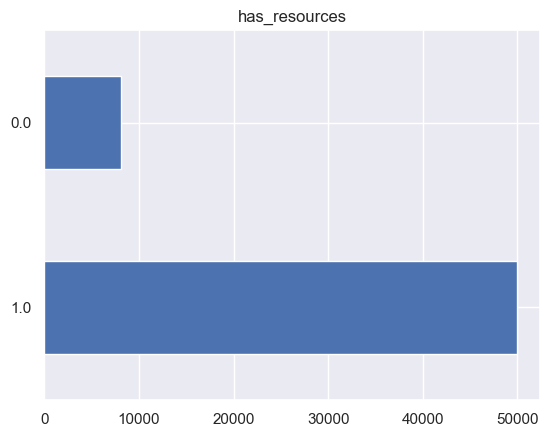

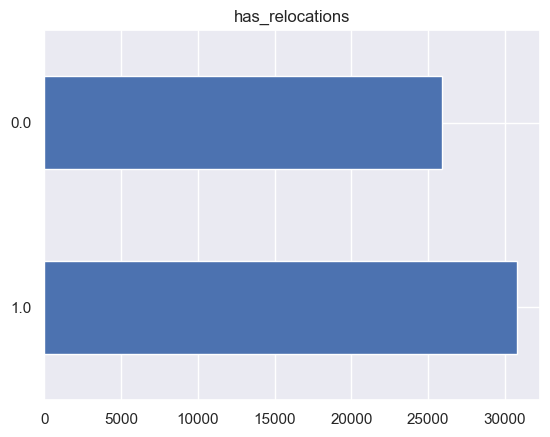

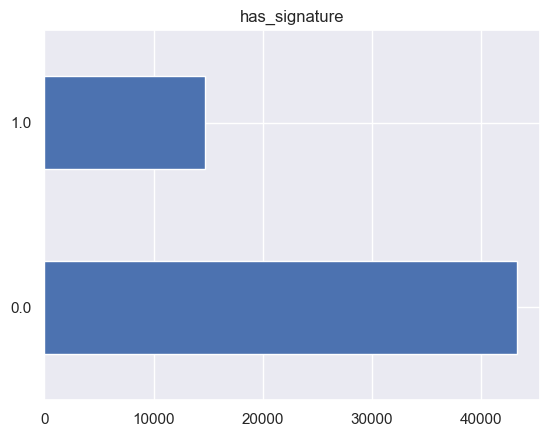

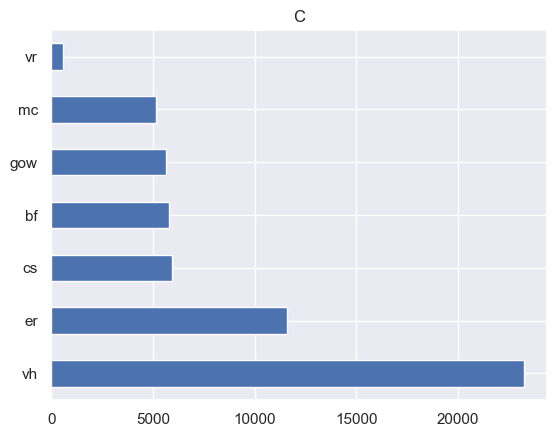

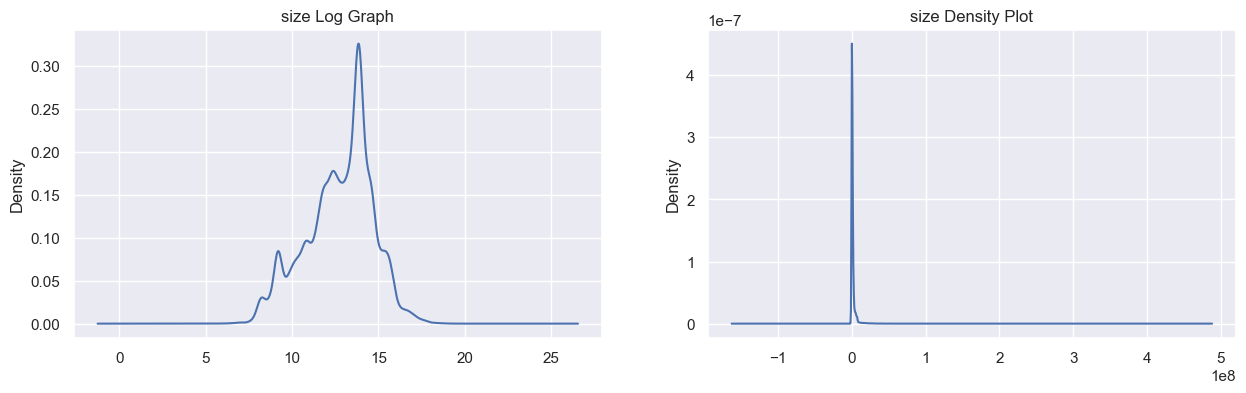

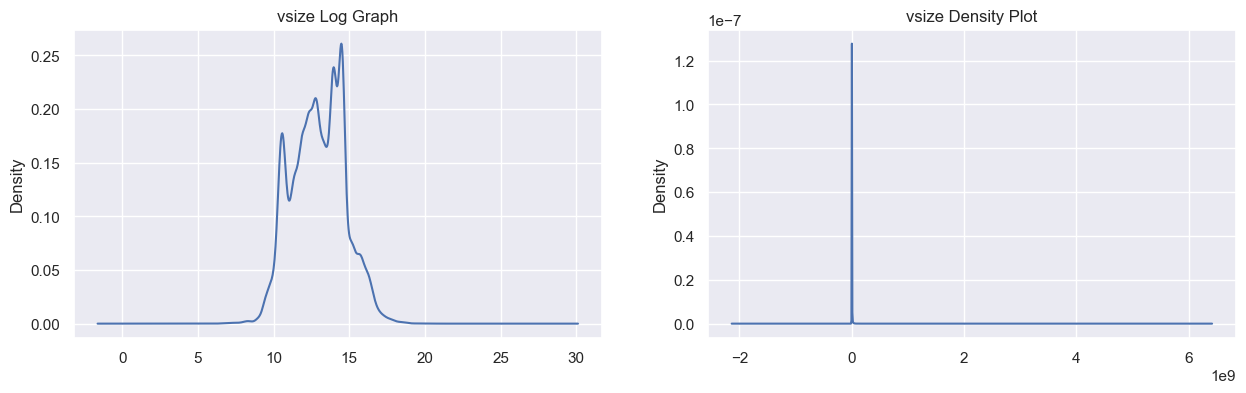

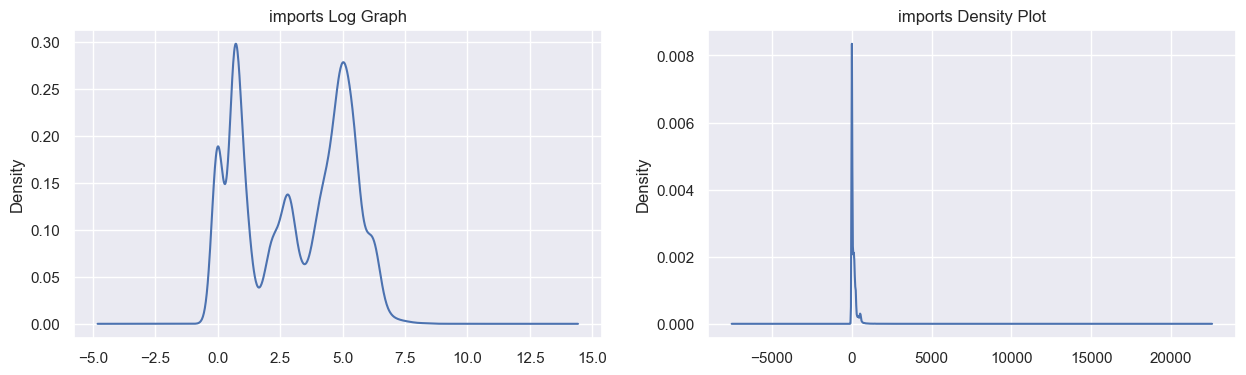

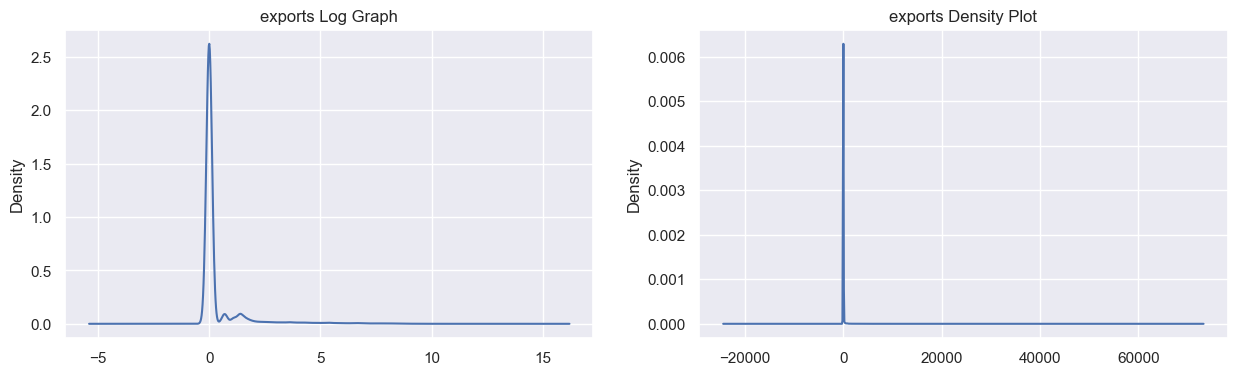

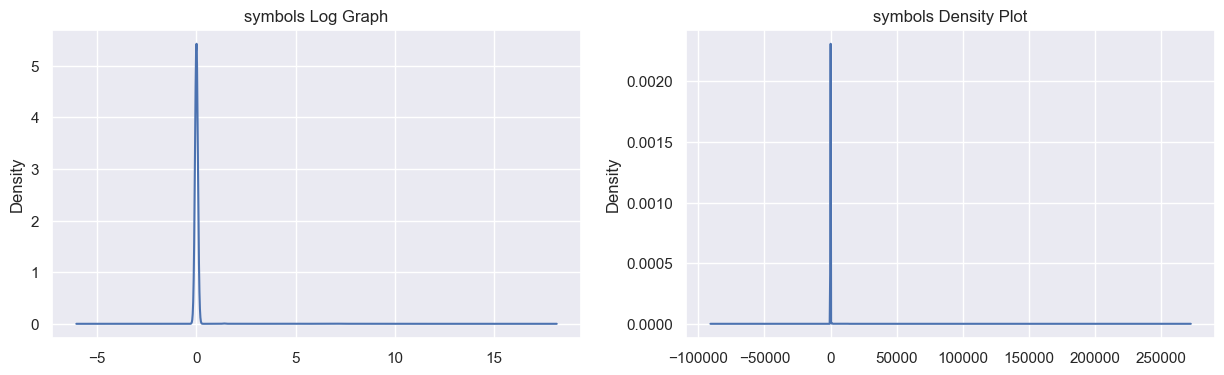

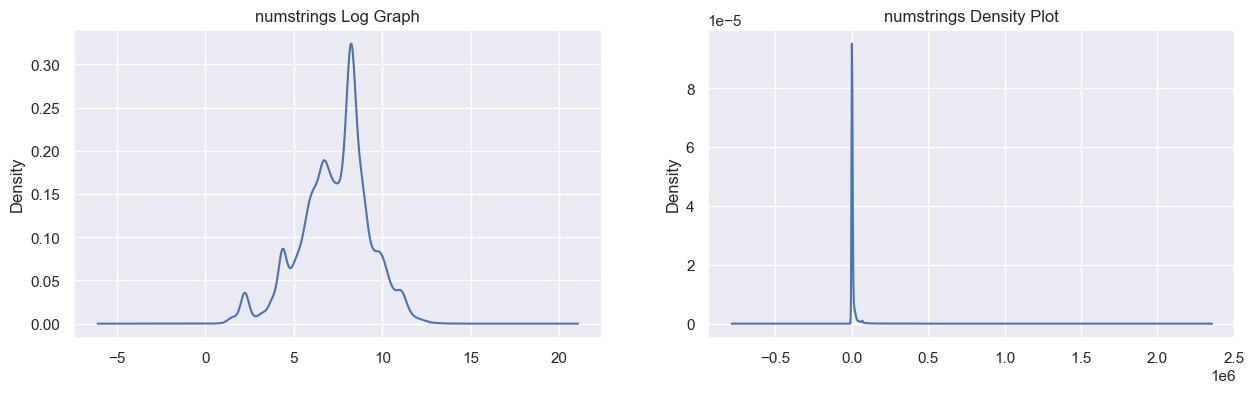

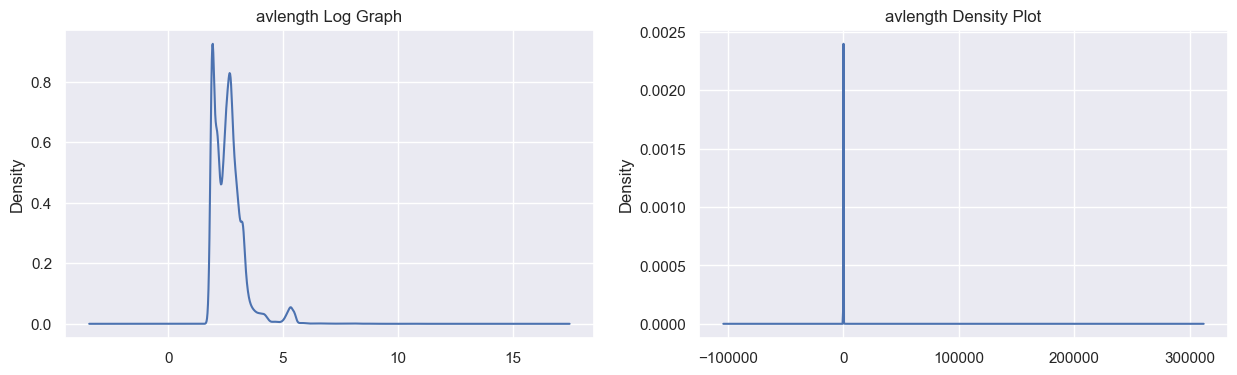

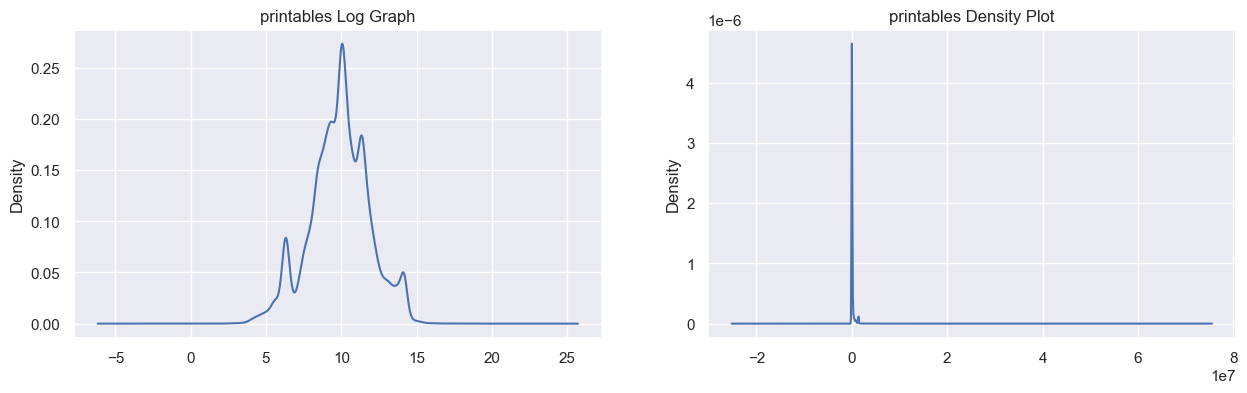

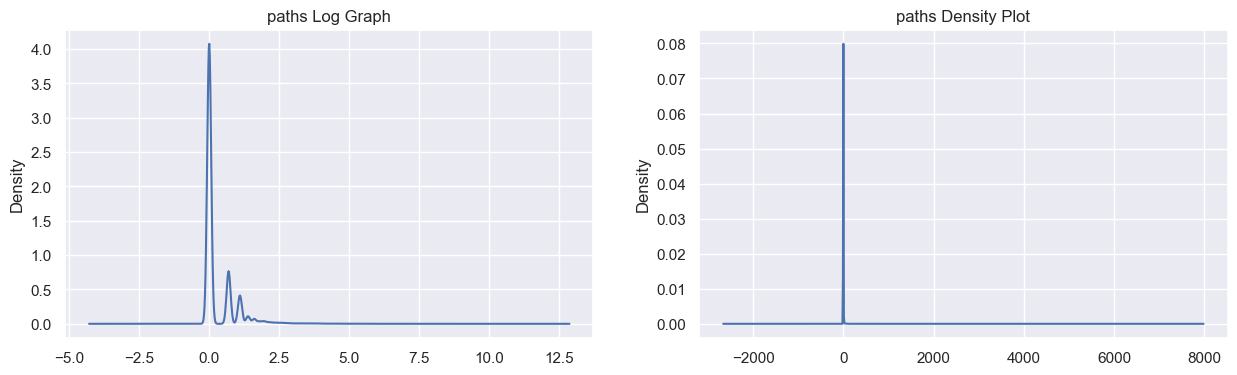

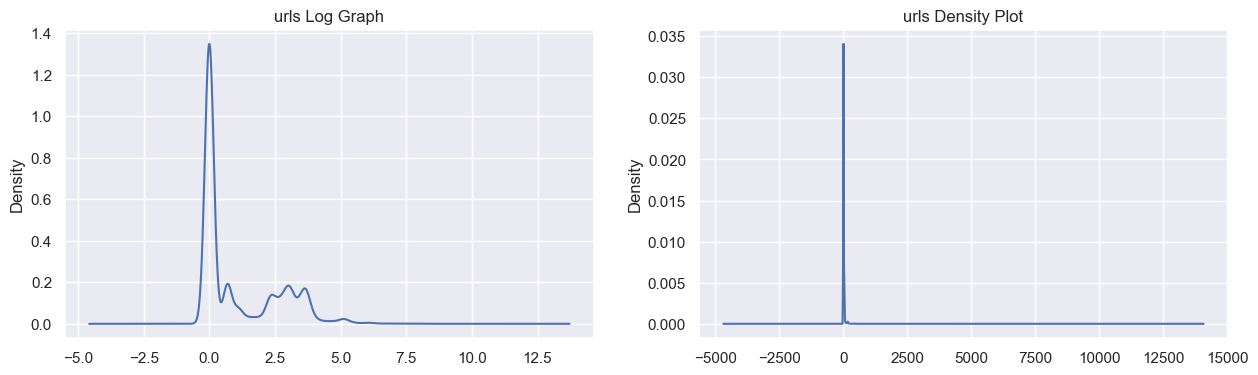

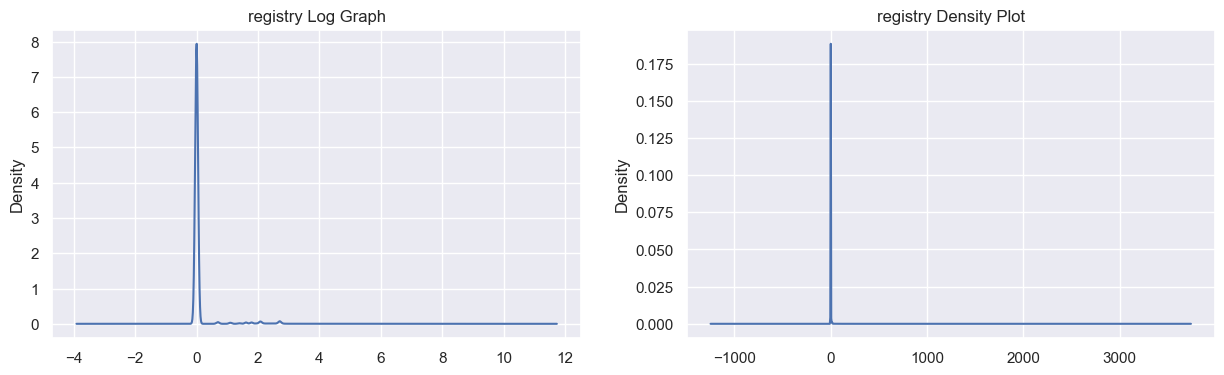

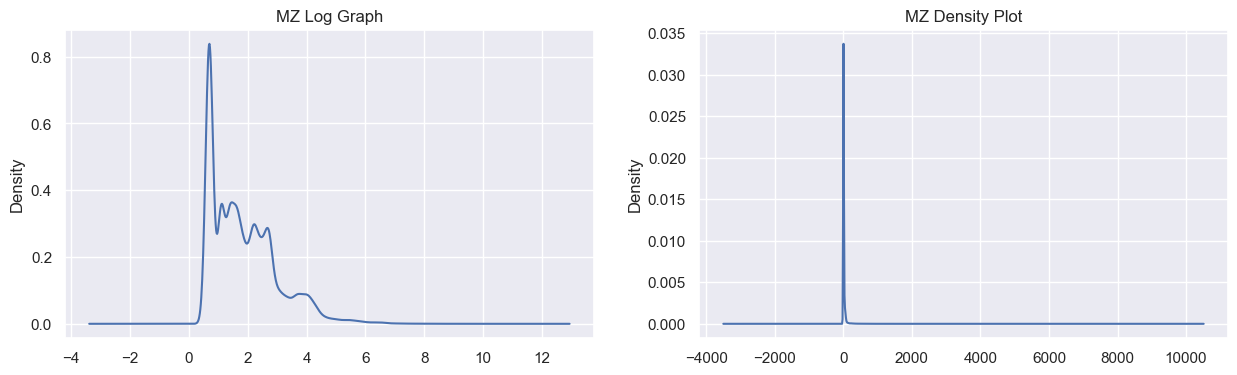

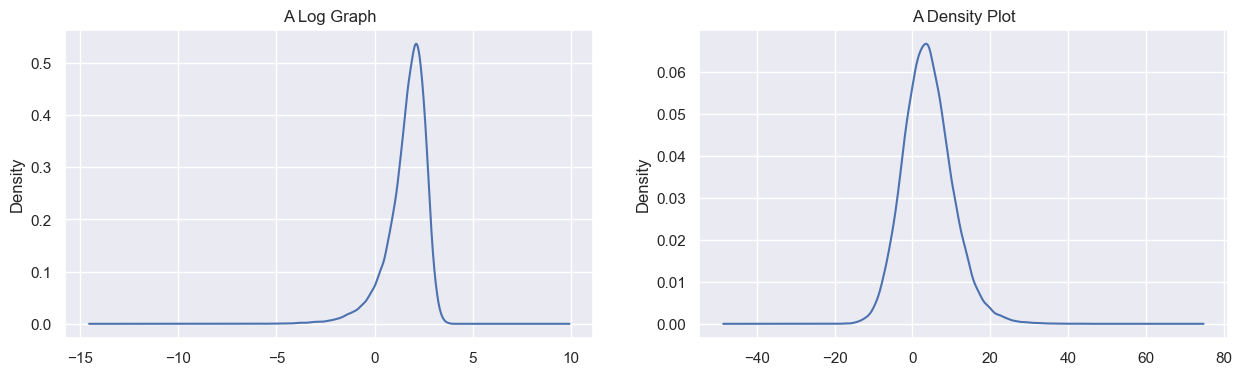

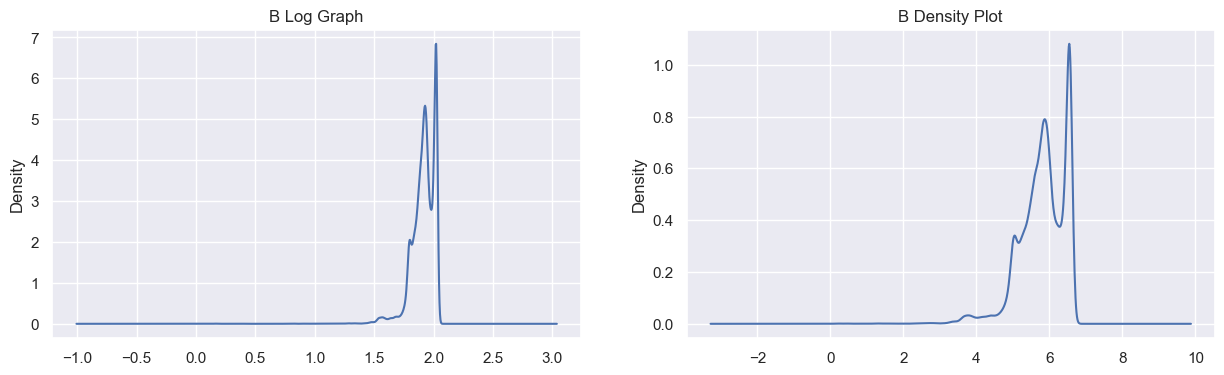

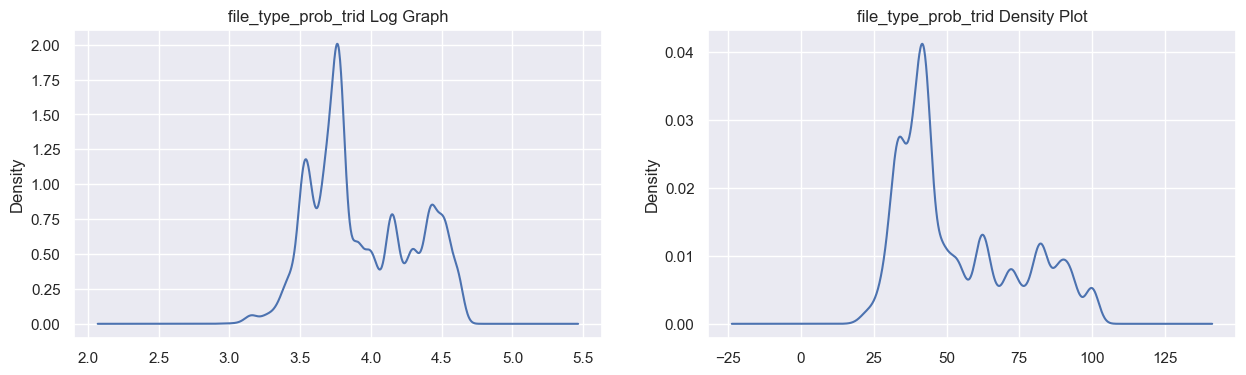

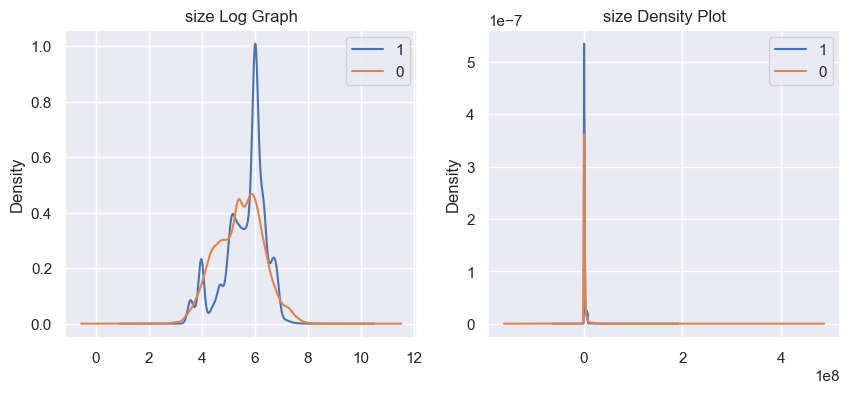

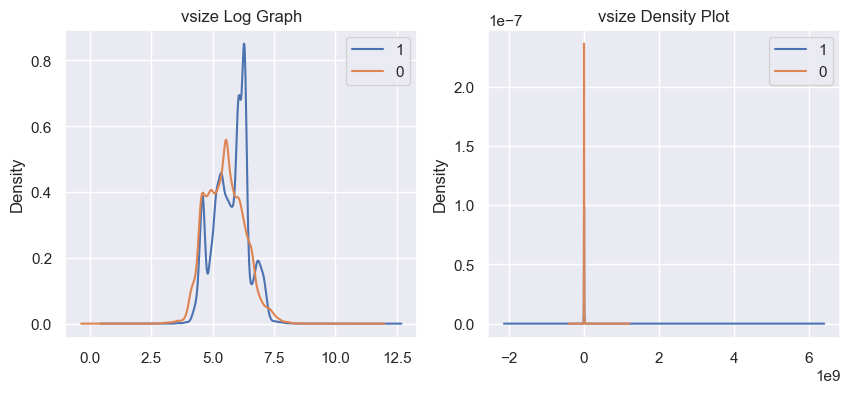

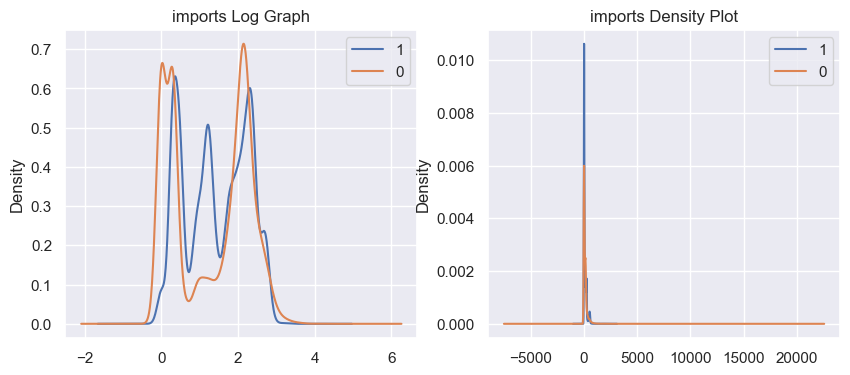

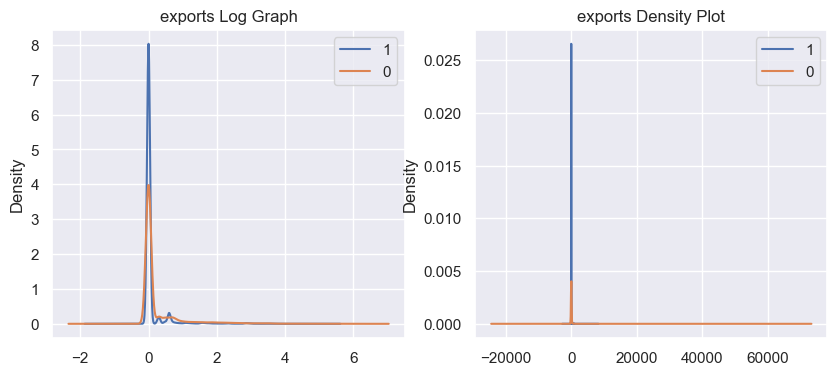

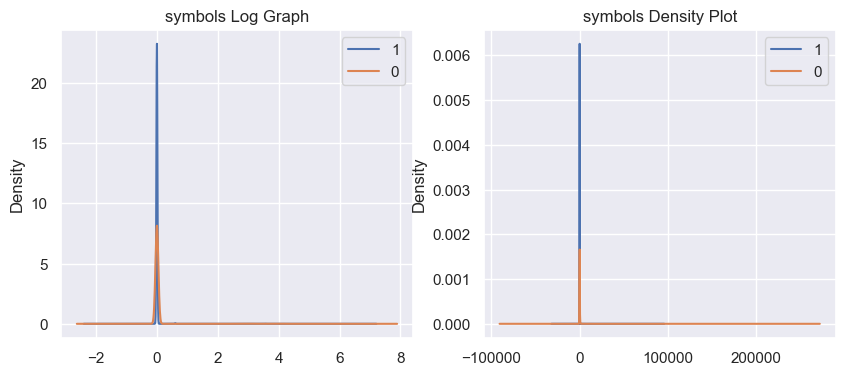

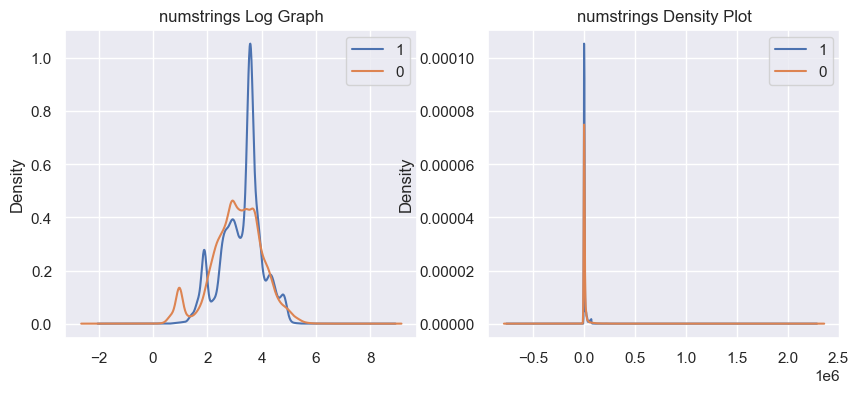

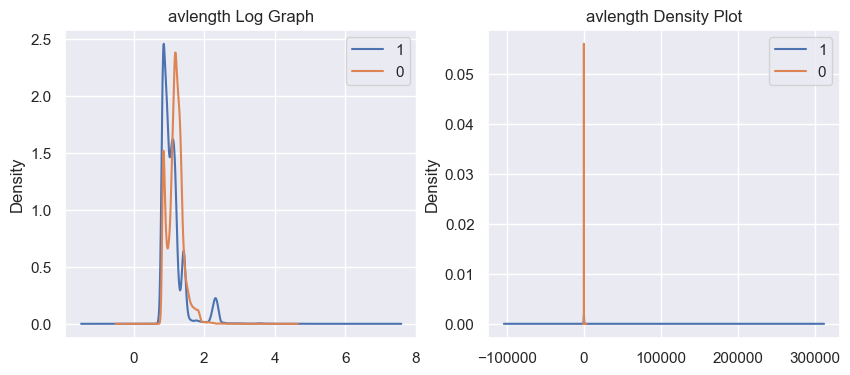

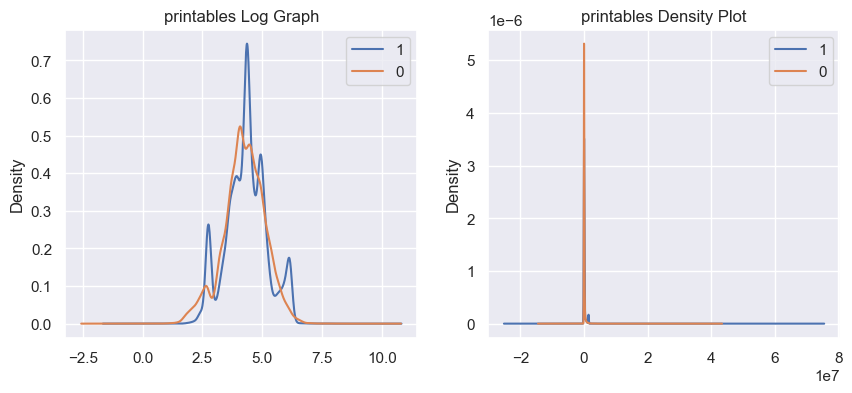

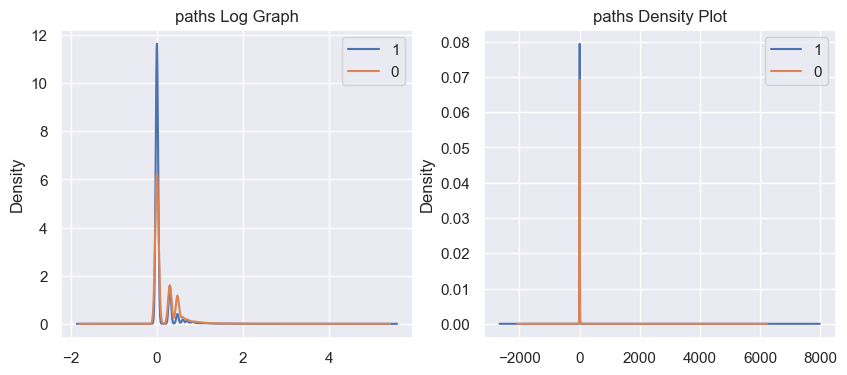

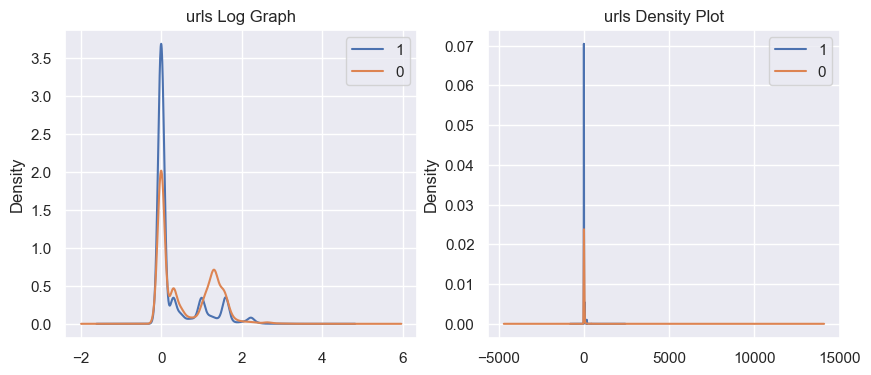

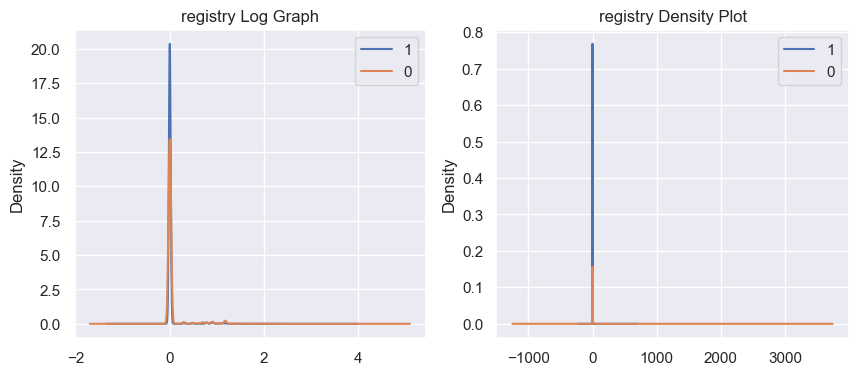

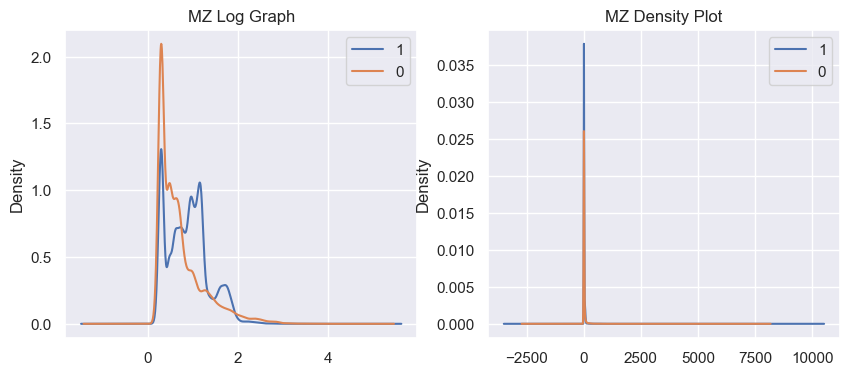

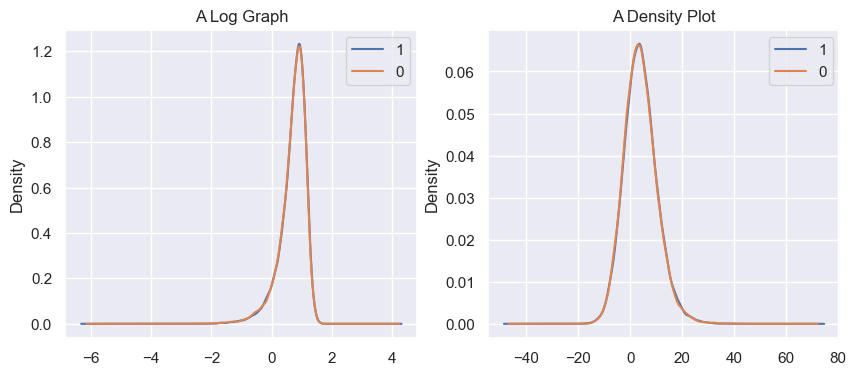

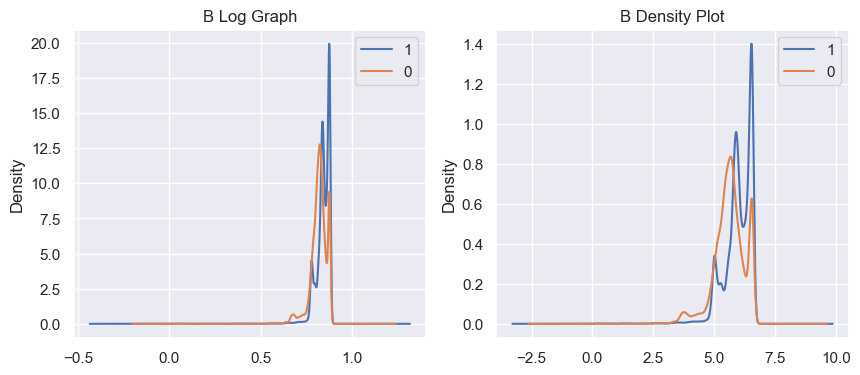

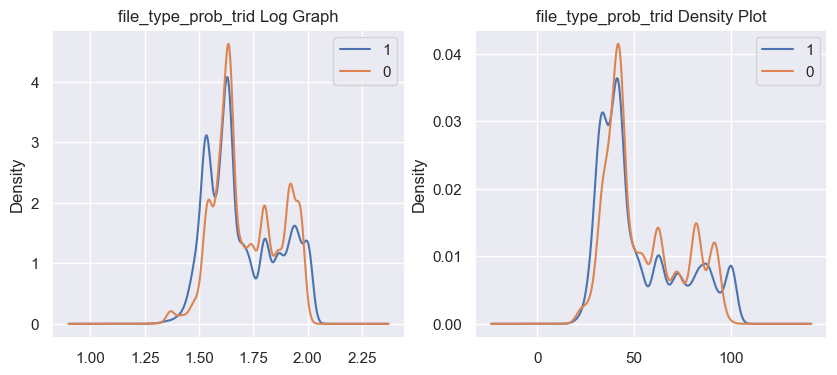

['vsize', 'Log of vsize', 'imports', 'Log of imports', 'exports', 'Log of exports', 'symbols', 'Log of symbols', 'numstrings', 'Log of numstrings', 'avlength', 'Log of avlength', 'printables', 'Log of printables', 'paths', 'Log of paths', 'urls', 'Log of urls', 'registry', 'Log of registry', 'MZ', 'Log of MZ', 'A', 'Log of A', 'B', 'Log of B']


'\nfeatures that look normally distributed:\nA\nlog of size\nlog of numstrings\nfeatures that log will increase the variance\nMZ\nurl\npaths\navlength\nsymbols, exports and imports\n'

In [88]:
### plotting all the features 

#some basic steps we think are important
num_features = df.shape[1]
num_observations = df.shape[0]
print(f"There are {num_observations} observations")

catagorial = ['label', 'has_debug', 'has_tls', 'has_resources', 'has_relocations', 'has_signature', 'C','file_type_trid']
numerical = ['size', 'vsize', 'imports', 'exports', 'symbols', 'numstrings', 'avlength', 'printables', 'paths', 'urls', 'registry', 'MZ', 'A', 'B', 'file_type_prob_trid']

norm_features = []
# Creating a boxplot for each numerical feature

ones = np.ones(main_df.shape[0])
for cat in catagorial:
    if ('type' in cat):
        continue
    main_df[cat].value_counts().plot.barh()
    plt.title(cat)
    plt.show()

# not by labels
for cat in numerical:

    fig, axes = plt.subplots(1, 2, figsize=(15, 4))

    curr = np.log(ones + main_df[cat])
    curr.plot.density( ax=axes[0])

    
    main_df['Log of '+cat] = curr

    main_df[cat].plot.density(ax=axes[1])

    axes[0].set_title(cat + " Log Graph")
    axes[1].set_title(cat + " Density Plot")

    plt.show()

# by labels
for cat in numerical:

    fig, axes = plt.subplots(1, 2, figsize=(10 , 4))

    curr = np.log10(ones + main_df[cat])
    curr[main_df['label'] == 1].plot.density(ax=axes[0], label = '1')
    curr[main_df['label'] == 0].plot.density(ax=axes[0], label= '0')

    
    main_df['Log of '+cat] = curr

    main_df[main_df['label'] == 1][cat].plot.density(ax=axes[1], label= '1')
    main_df[main_df['label'] == 0][cat].plot.density(ax=axes[1], label= '0')

    axes[0].legend()
    axes[1].legend()
    axes[0].set_title(cat + " Log Graph")
    axes[1].set_title(cat + " Density Plot")

    plt.show()
    test_statistic, p_value = stats.shapiro(main_df[cat])
    if (p_value > 0.05):
        norm_features = norm_features + [cat]
    test_statistic, p_value = stats.shapiro(curr)
    if (p_value > 0.05):
        norm_features = norm_features + ['Log of '+cat]


print(norm_features)
main_df.describe()  


'''
features that look normally distributed:
A
log of size
log of numstrings
features that log will increase the variance
MZ
url
paths
avlength
symbols, exports and imports
'''

and what about the bool features? 

The code iterates over a list of boolean features, calculates the count of label values for each feature value, and plots stacked bar plots showing the count of feature values by label.

<Figure size 640x480 with 0 Axes>

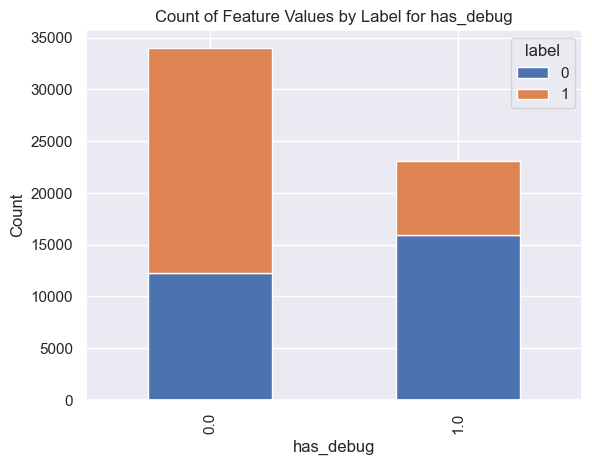

Percentage of label 0 out of total count for has_debug=0: 36.04%
Percentage of label 1 out of total count for has_debug=0: 63.96%
Percentage of label 0 out of total count for has_debug=1: 69.31%
Percentage of label 1 out of total count for has_debug=1: 30.69%


<Figure size 640x480 with 0 Axes>

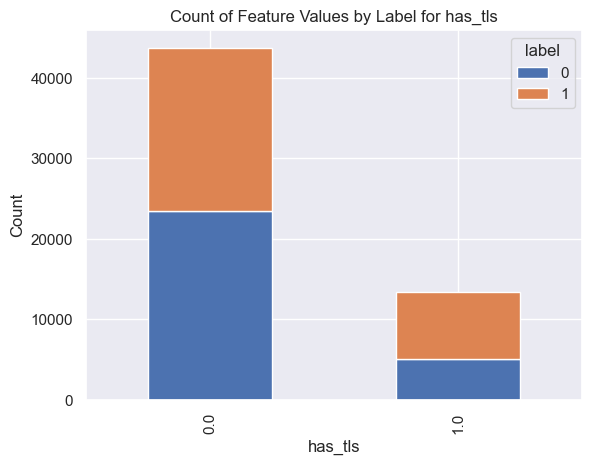

Percentage of label 0 out of total count for has_tls=0: 53.74%
Percentage of label 1 out of total count for has_tls=0: 46.26%
Percentage of label 0 out of total count for has_tls=1: 37.56%
Percentage of label 1 out of total count for has_tls=1: 62.44%


<Figure size 640x480 with 0 Axes>

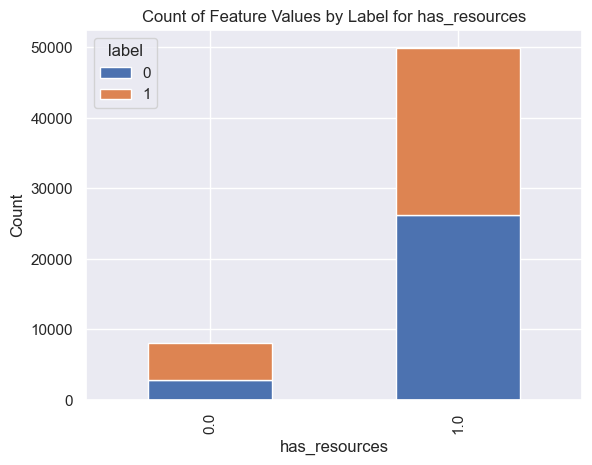

Percentage of label 0 out of total count for has_resources=0: 35.07%
Percentage of label 1 out of total count for has_resources=0: 64.93%
Percentage of label 0 out of total count for has_resources=1: 52.36%
Percentage of label 1 out of total count for has_resources=1: 47.64%


<Figure size 640x480 with 0 Axes>

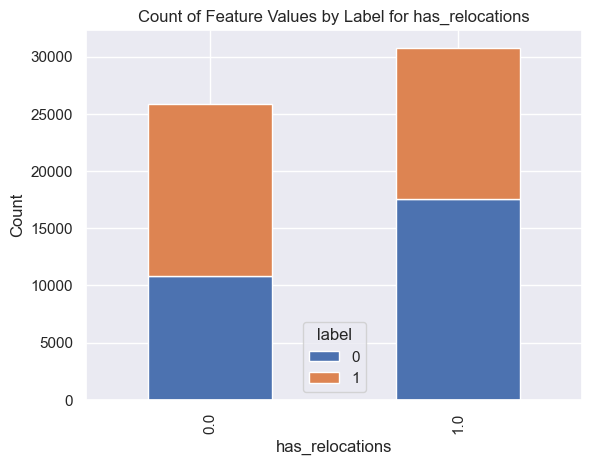

Percentage of label 0 out of total count for has_relocations=0: 41.66%
Percentage of label 1 out of total count for has_relocations=0: 58.34%
Percentage of label 0 out of total count for has_relocations=1: 56.89%
Percentage of label 1 out of total count for has_relocations=1: 43.11%


<Figure size 640x480 with 0 Axes>

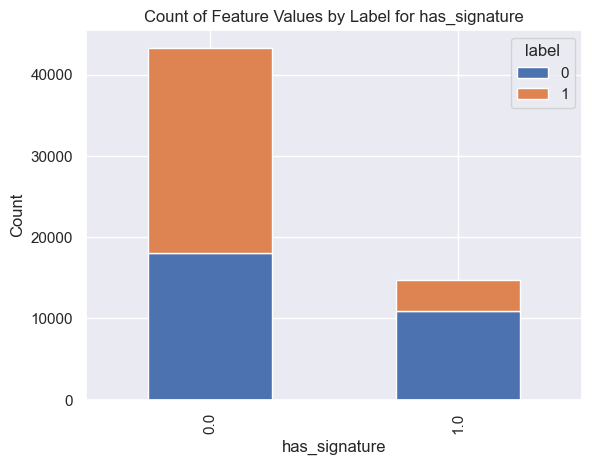

Percentage of label 0 out of total count for has_signature=0: 41.78%
Percentage of label 1 out of total count for has_signature=0: 58.22%
Percentage of label 0 out of total count for has_signature=1: 74.22%
Percentage of label 1 out of total count for has_signature=1: 25.78%


In [89]:
#let try to see the has features ('has_debug', 'has_tls', 'has_resources', 'has_relocations', 'has_signature') and label on a plot

bool_features = ['has_debug', 'has_tls', 'has_resources', 'has_relocations', 'has_signature']

# Iterate over boolean features
for has in bool_features:
    # Group by feature value and calculate count for each label value
    group_by_feature = main_df.groupby([has, 'label']).size().unstack()

    # Plot bar plot
    plt.figure()
    group_by_feature.plot(kind='bar', stacked=True)
    plt.xlabel(has)
    plt.ylabel('Count')
    plt.title(f'Count of Feature Values by Label for {has}')
    plt.show()

    # Calculate percentage of labels 0 and 1
    total_counts = group_by_feature.sum(axis=1)
    percentage_0 = group_by_feature.loc[0, 0] / total_counts[0] * 100
    percentage_1 = group_by_feature.loc[1, 1] / total_counts[1] * 100
    
    # Print percentage values
    print(f"Percentage of label 0 out of total count for {has}=0: {percentage_0:.2f}%")
    print(f"Percentage of label 1 out of total count for {has}=0: {100 - percentage_0:.2f}%")
    print(f"Percentage of label 0 out of total count for {has}=1: {100 - percentage_1:.2f}%")
    print(f"Percentage of label 1 out of total count for {has}=1: {percentage_1:.2f}%")
    
    

What can we tell from our visualizations:

1. half of our data our malicious files and half are not. Which means have 30000 with label = 1 and 30000 with label = 0 (overall 60000 observations).
2. We have boolean features! such as has_debug, has_tls, has_resources, has_relocations, has_signiture with the values 0 or 1. Note: we can see most of of the files have resources.
3. we have 2 categorial features, file_type_trid and and C (we don't now what C is but lets see if it helps at all)
NOTE: we can see that "C" doesn't have much values, we could use it as a dummy variable, however, for file_type_trid (which will be plotted later), that has many values, we can't, we will see later how can use it.

4. we can see many continuous featuress distributions are easier to understand by adding the log, some distribute normally after adding the log, some are normally distributed such as size, numstrings and printables. the other features are affected by having greater variance after adding the log.
NOTE: this excludes features such as A and B that don't need the log, A already is normally distributed and B's variance is not affected by the log.

5. In addition to the understanding of the distributions, we visualize differences between malicious and non malicious files via the density plot. for certain features such as MZ and B are affected by the label (with opposite effects, one shifts to the right and the other to the left in the distribution according only to the visualizations)


* Now we will be using the log of the continious features (where it helps) in order to see further connections

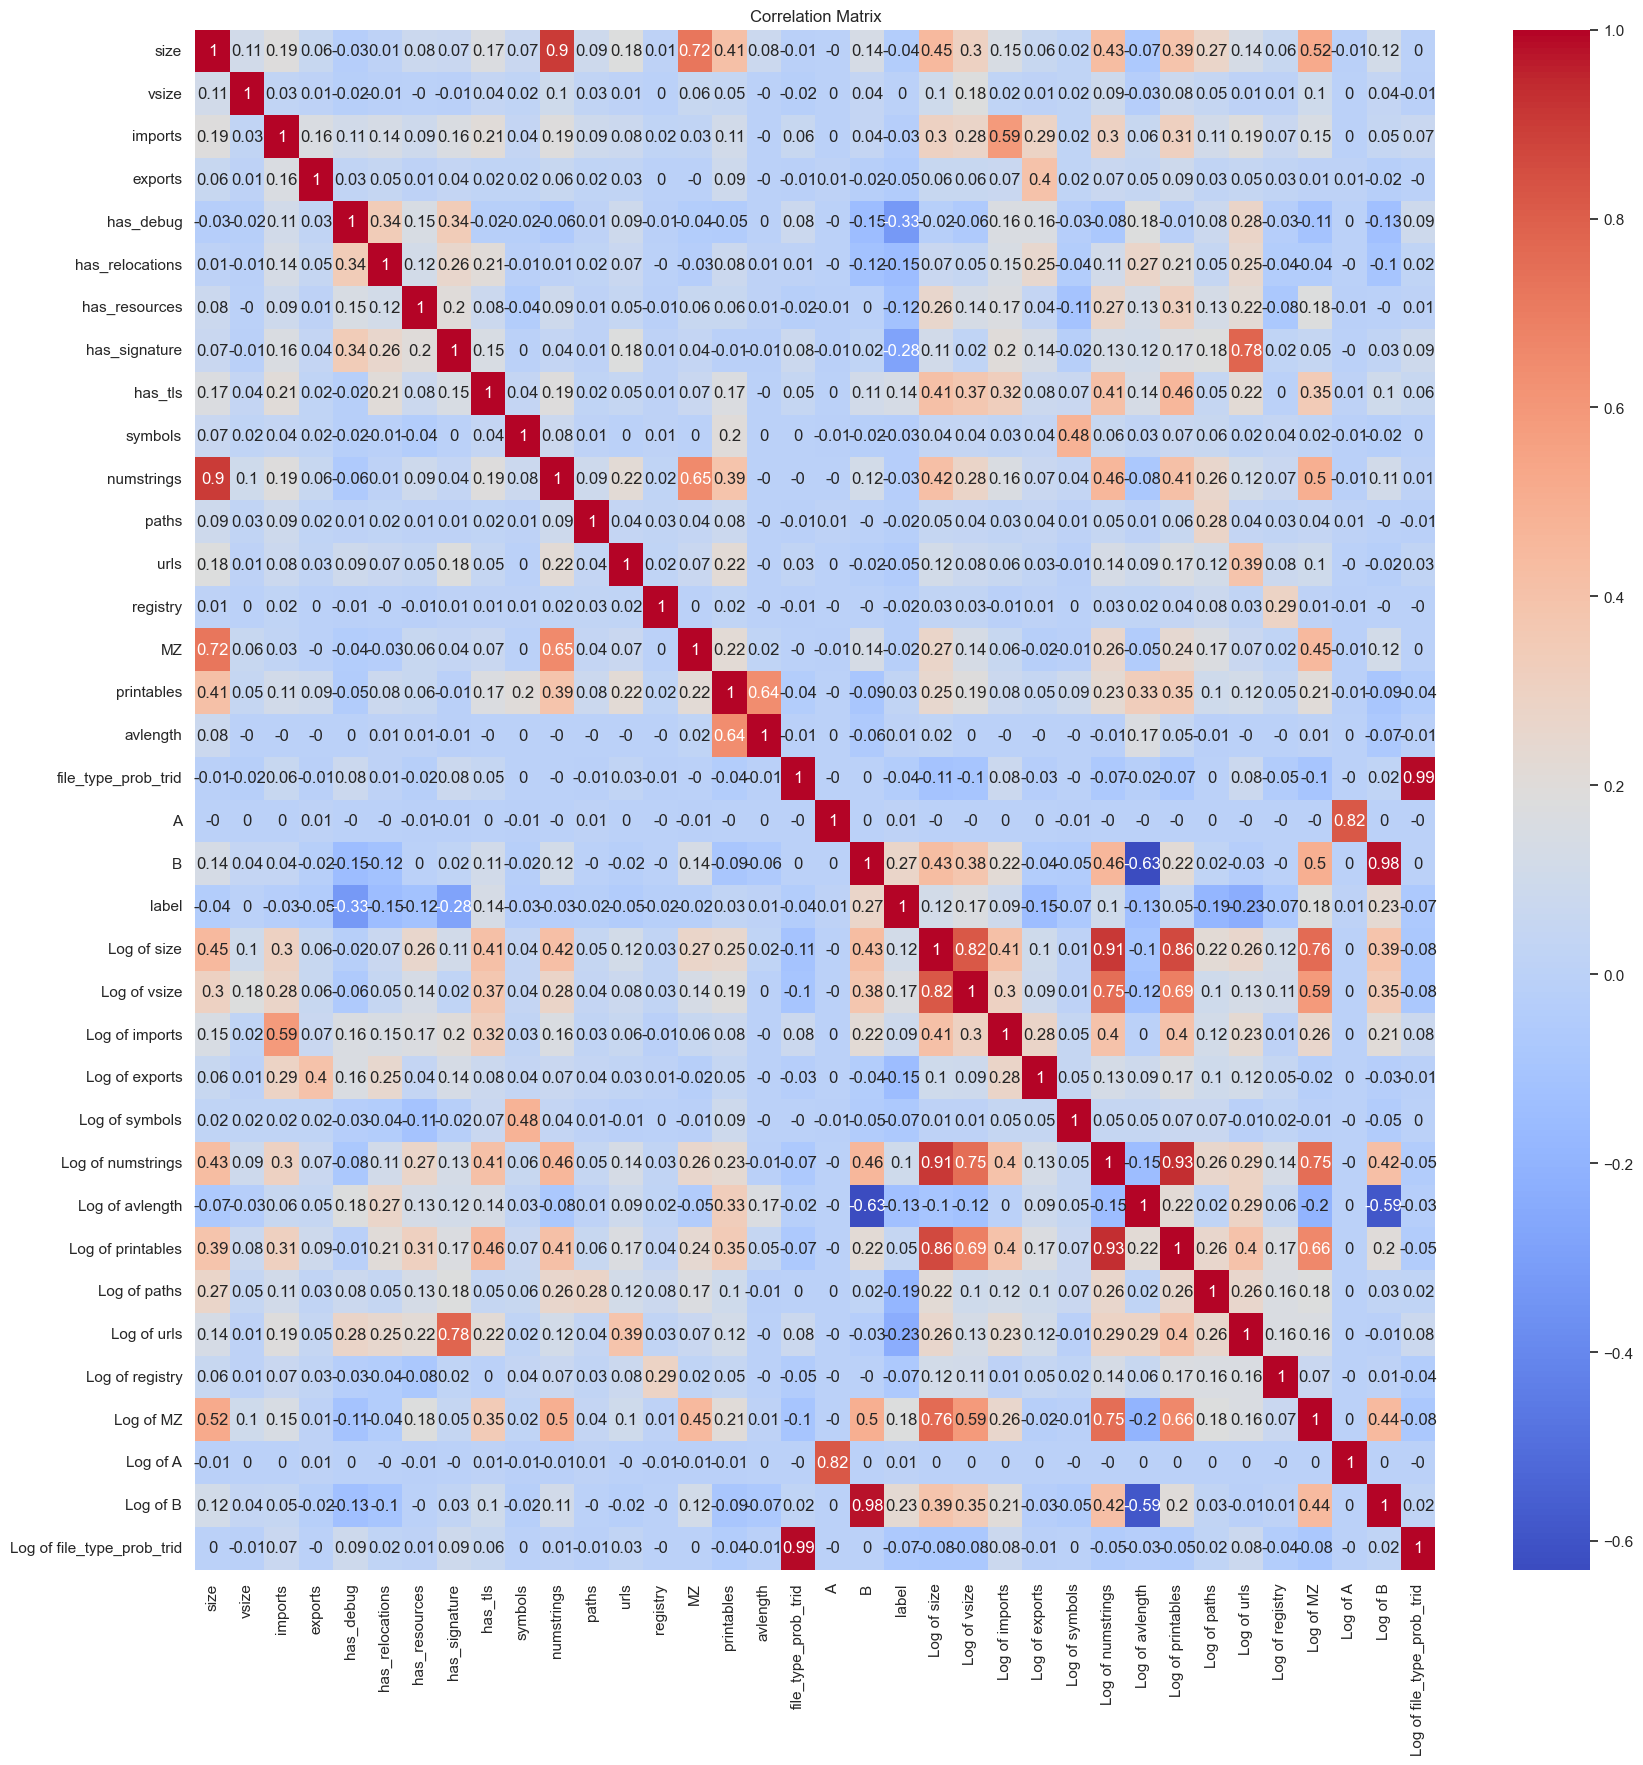

In [90]:
normal_log = ['size', 'numstrings']
to_log = ['size', 'vsize','numstrings','printables', 'MZ', 'urls', 'paths', 'avlength' ,'symbols', 'exports', 'imports', 'registry']
corr_matrix = main_df.corr().round(2)
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.title("Correlation Matrix")
plt.show()

Above we see the correlation matrix with ALL of the features (including their log features). we see certain connections that don't surprise us at all, (feature and its log) however we see new correlations overall, seeing the bottom right corner of the correlation matrix, we see more correlations not between 2 features but their log values.

Understanding some of the features we thought might be interesting:

We will do some visualizaitons and conclunsions on the training data regarding some features.


Understanding the symbols and the effect of the label

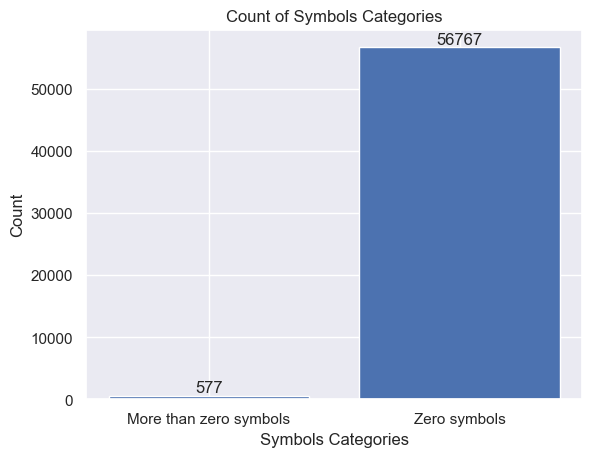

In [91]:
more_than_zero_symbols = len(main_df[main_df['symbols'] > 0])
zero_symbols = len(main_df[main_df['symbols'] == 0])

symbols_categories = ['More than zero symbols', 'Zero symbols']
symbols_counts = [more_than_zero_symbols, zero_symbols]

plt.bar(symbols_categories, symbols_counts)
plt.xlabel('Symbols Categories')
plt.ylabel('Count')
plt.title('Count of Symbols Categories')

# Add numbers on top of each bar
for i, count in enumerate(symbols_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')
    
plt.show()

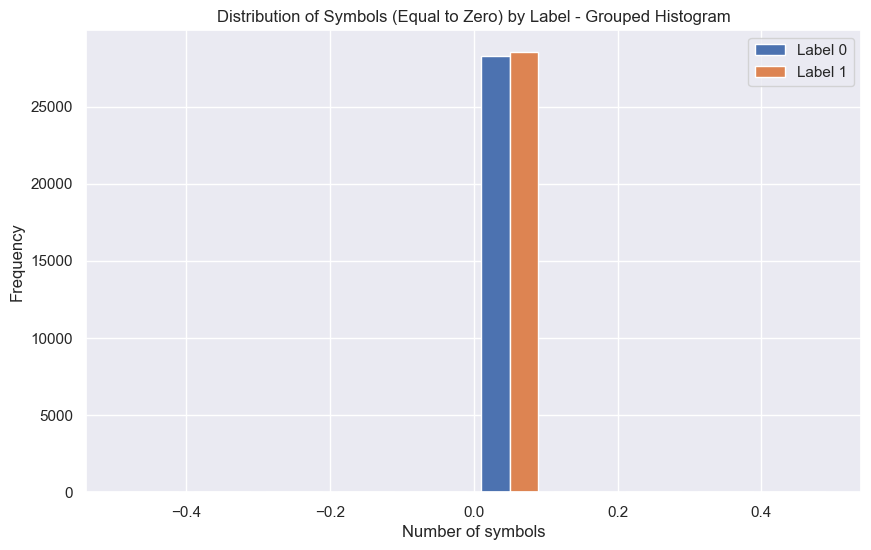

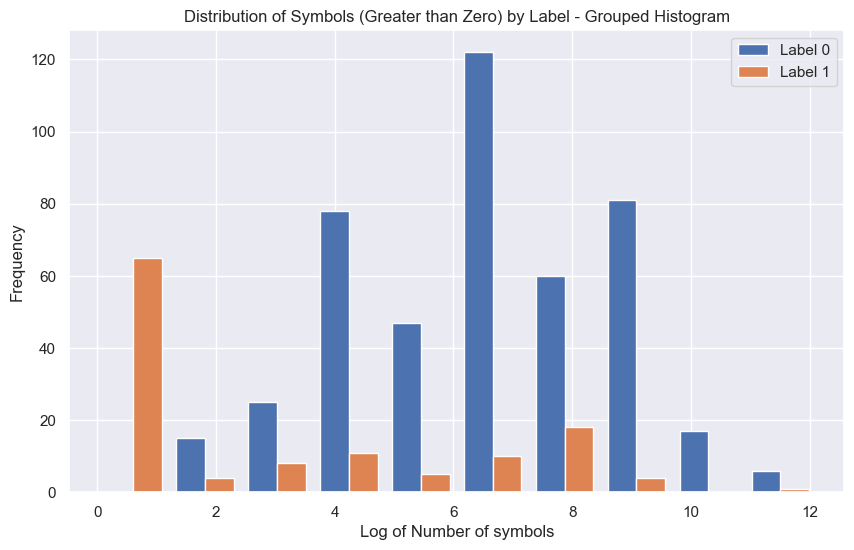

In [92]:

zero_symbols_label_0 = main_df[(main_df['symbols'] == 0) & (main_df['label'] == 0)]['symbols']
zero_symbols_label_1 = main_df[(main_df['symbols'] == 0) & (main_df['label'] == 1)]['symbols']
plt.figure(figsize=(10, 6))
# Grouped Histogram
plt.hist([zero_symbols_label_0, zero_symbols_label_1], bins=10, label=['Label 0', 'Label 1'])
plt.xlabel('Number of symbols')
plt.ylabel('Frequency')
plt.title('Distribution of Symbols (Equal to Zero) by Label - Grouped Histogram')
plt.legend()
plt.show()

bigger_zero_symbols_label_0 = main_df[(main_df['symbols'] > 0) & (main_df['label'] == 0)]['symbols']
bigger_zero_symbols_label_1 = main_df[(main_df['symbols'] > 0) & (main_df['label'] == 1)]['symbols']
plt.figure(figsize=(10, 6))
bigger_zero_symbols_label_0_log = np.log(bigger_zero_symbols_label_0)
bigger_zero_symbols_label_1_log = np.log(bigger_zero_symbols_label_1)
# Grouped Histogram
plt.hist([bigger_zero_symbols_label_0_log, bigger_zero_symbols_label_1_log], bins=10, label=['Label 0', 'Label 1'])
plt.xlabel('Log of Number of symbols')
plt.ylabel('Frequency')
plt.title('Distribution of Symbols (Greater than Zero) by Label - Grouped Histogram')
plt.legend()
plt.show()



Conclusions:
The vast majority of our data, has 0 symbols in the file, and barely has any effect on the labels of our data because we see it's half and half. (according the bar plot). We do see once we go to files with more than 0 symbols a certain dependency of the label, however the change is extremly negligable.

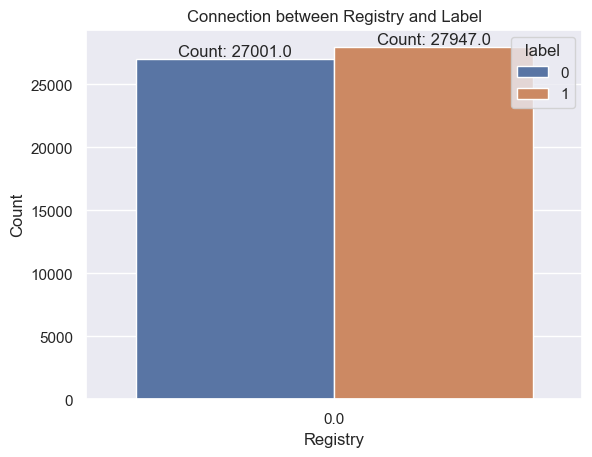

Number of Labels that are 1 with registry 0: 27947
Number of Labels that are 0 with registry 0: 27001


In [93]:
df_registry_0 = main_df[main_df['registry']==0]

# Create a count plot
ax = sns.countplot(data=df_registry_0, x='registry', hue='label')

# Get the counts
label_1_registry_0 = len(df_registry_0[df_registry_0['label'] == 1])
label_0_registry_0 = len(df_registry_0[df_registry_0['label'] == 0])

# Annotate the bars with count values
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(f"Count: {p.get_height()}", (p.get_x() + p.get_width() / 2, p.get_height()), 
                    ha='center', va='bottom')

# Set labels and title
plt.xlabel('Registry')
plt.ylabel('Count')
plt.title('Connection between Registry and Label')

# Display the plot
plt.show()

# Print the counts
print(f"Number of Labels that are 1 with registry 0: {label_1_registry_0}")
print(f"Number of Labels that are 0 with registry 0: {label_0_registry_0}")

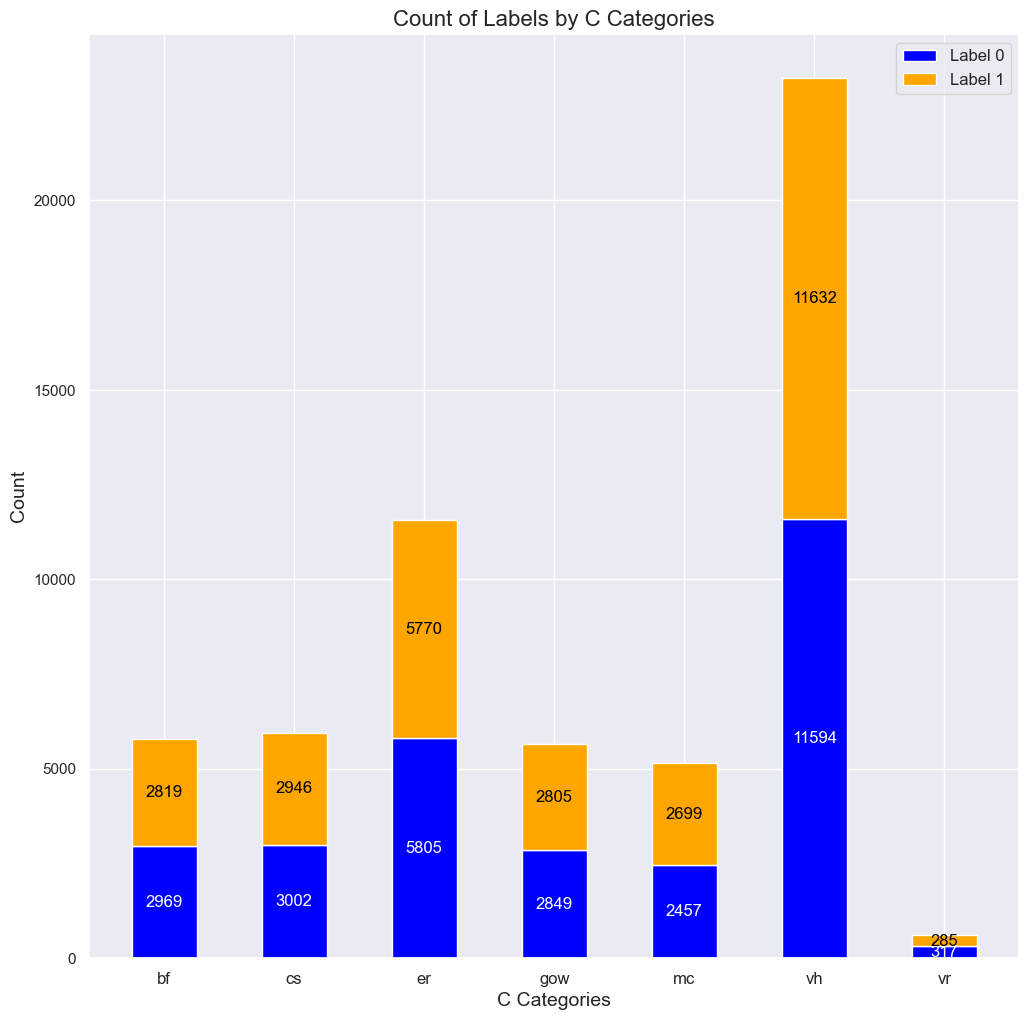

In [94]:
#comparing the distribution of safe and malicious files across different categories ('C'). 
grouped_data = main_df.groupby(['C', 'label']).size().unstack()
plt.figure(figsize=(12, 12))
colors = ['blue', 'orange']
num_categories = len(grouped_data)
bar_width = 0.5
bar_positions = np.arange(num_categories)
plt.bar(bar_positions, grouped_data[0], color=colors[0], width=bar_width, label='Label 0')
plt.bar(bar_positions, grouped_data[1], color=colors[1], width=bar_width, bottom=grouped_data[0], label='Label 1')
plt.xticks(bar_positions, grouped_data.index)
plt.xticks(bar_positions, grouped_data.index, fontsize=12)
plt.xlabel('C Categories', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Count of Labels by C Categories', fontsize=16)
plt.legend(fontsize=12)

# Increase the gap between count numbers
label_0_offset = 0.15
label_1_offset = 0.3

# Add numbers for label 0
for i in range(num_categories):
    plt.text(bar_positions[i], grouped_data.iloc[i, 0] / 2, f'{grouped_data.iloc[i, 0]}', ha='center', va='center', color='white')

# Add numbers for label 1
for i in range(num_categories):
    plt.text(bar_positions[i], grouped_data.iloc[i, 0] + grouped_data.iloc[i, 1] / 2, f'{grouped_data.iloc[i, 1]}', ha='center', va='center', color='black')

plt.show()

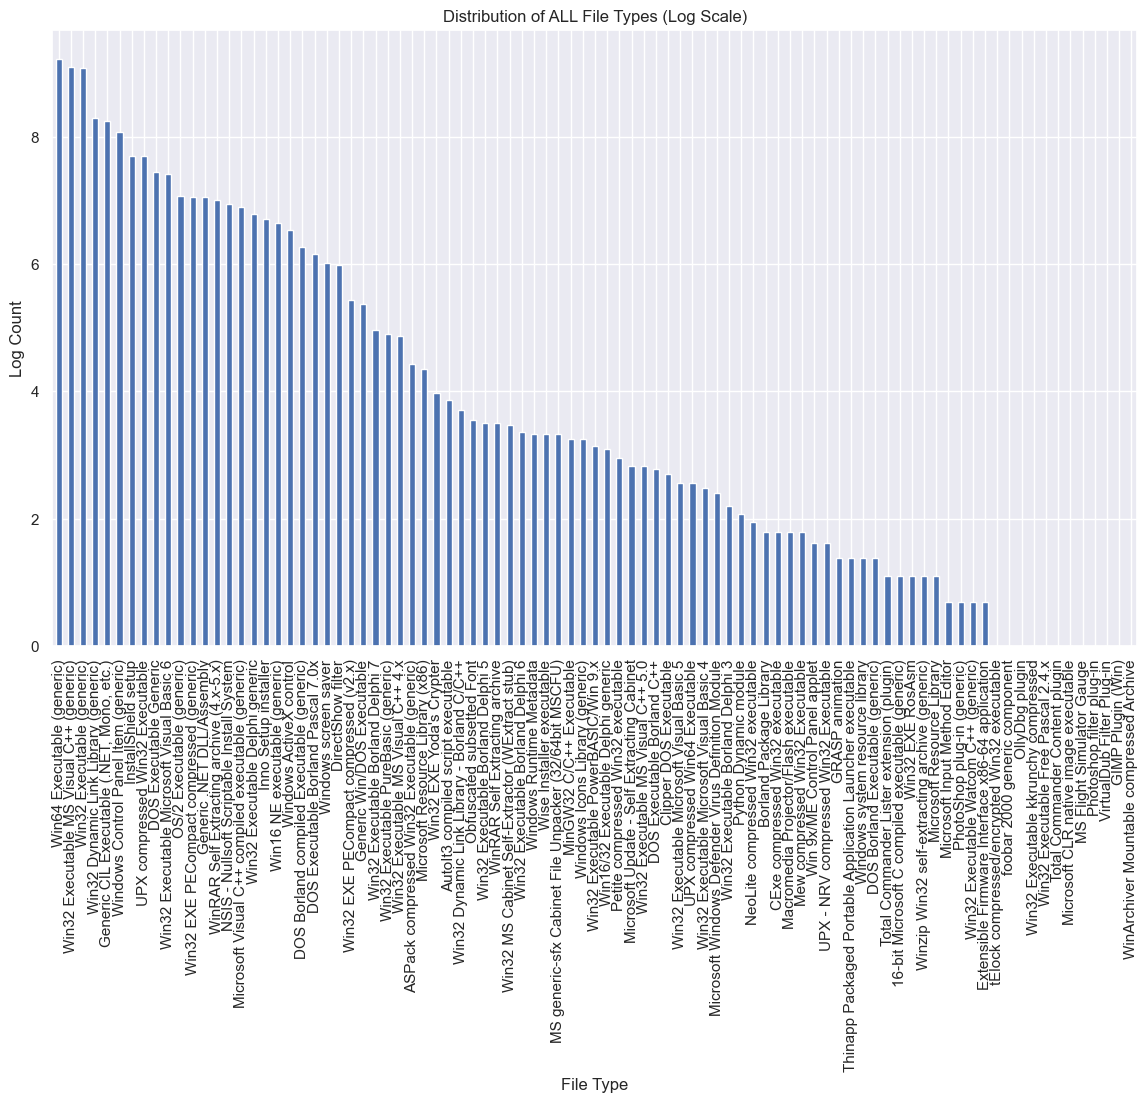

In [95]:
file_type_counts = main_df['file_type_trid'].value_counts()
log_counts = np.log(file_type_counts)

# Plot the bar chart with log-transformed counts
plt.figure(figsize=(14, 8))
log_counts.plot(kind='bar')
plt.xlabel('File Type')
plt.ylabel('Log Count')
plt.title('Distribution of ALL File Types (Log Scale)')
plt.xticks(rotation=90)
plt.show()

Win32 EXE 
146


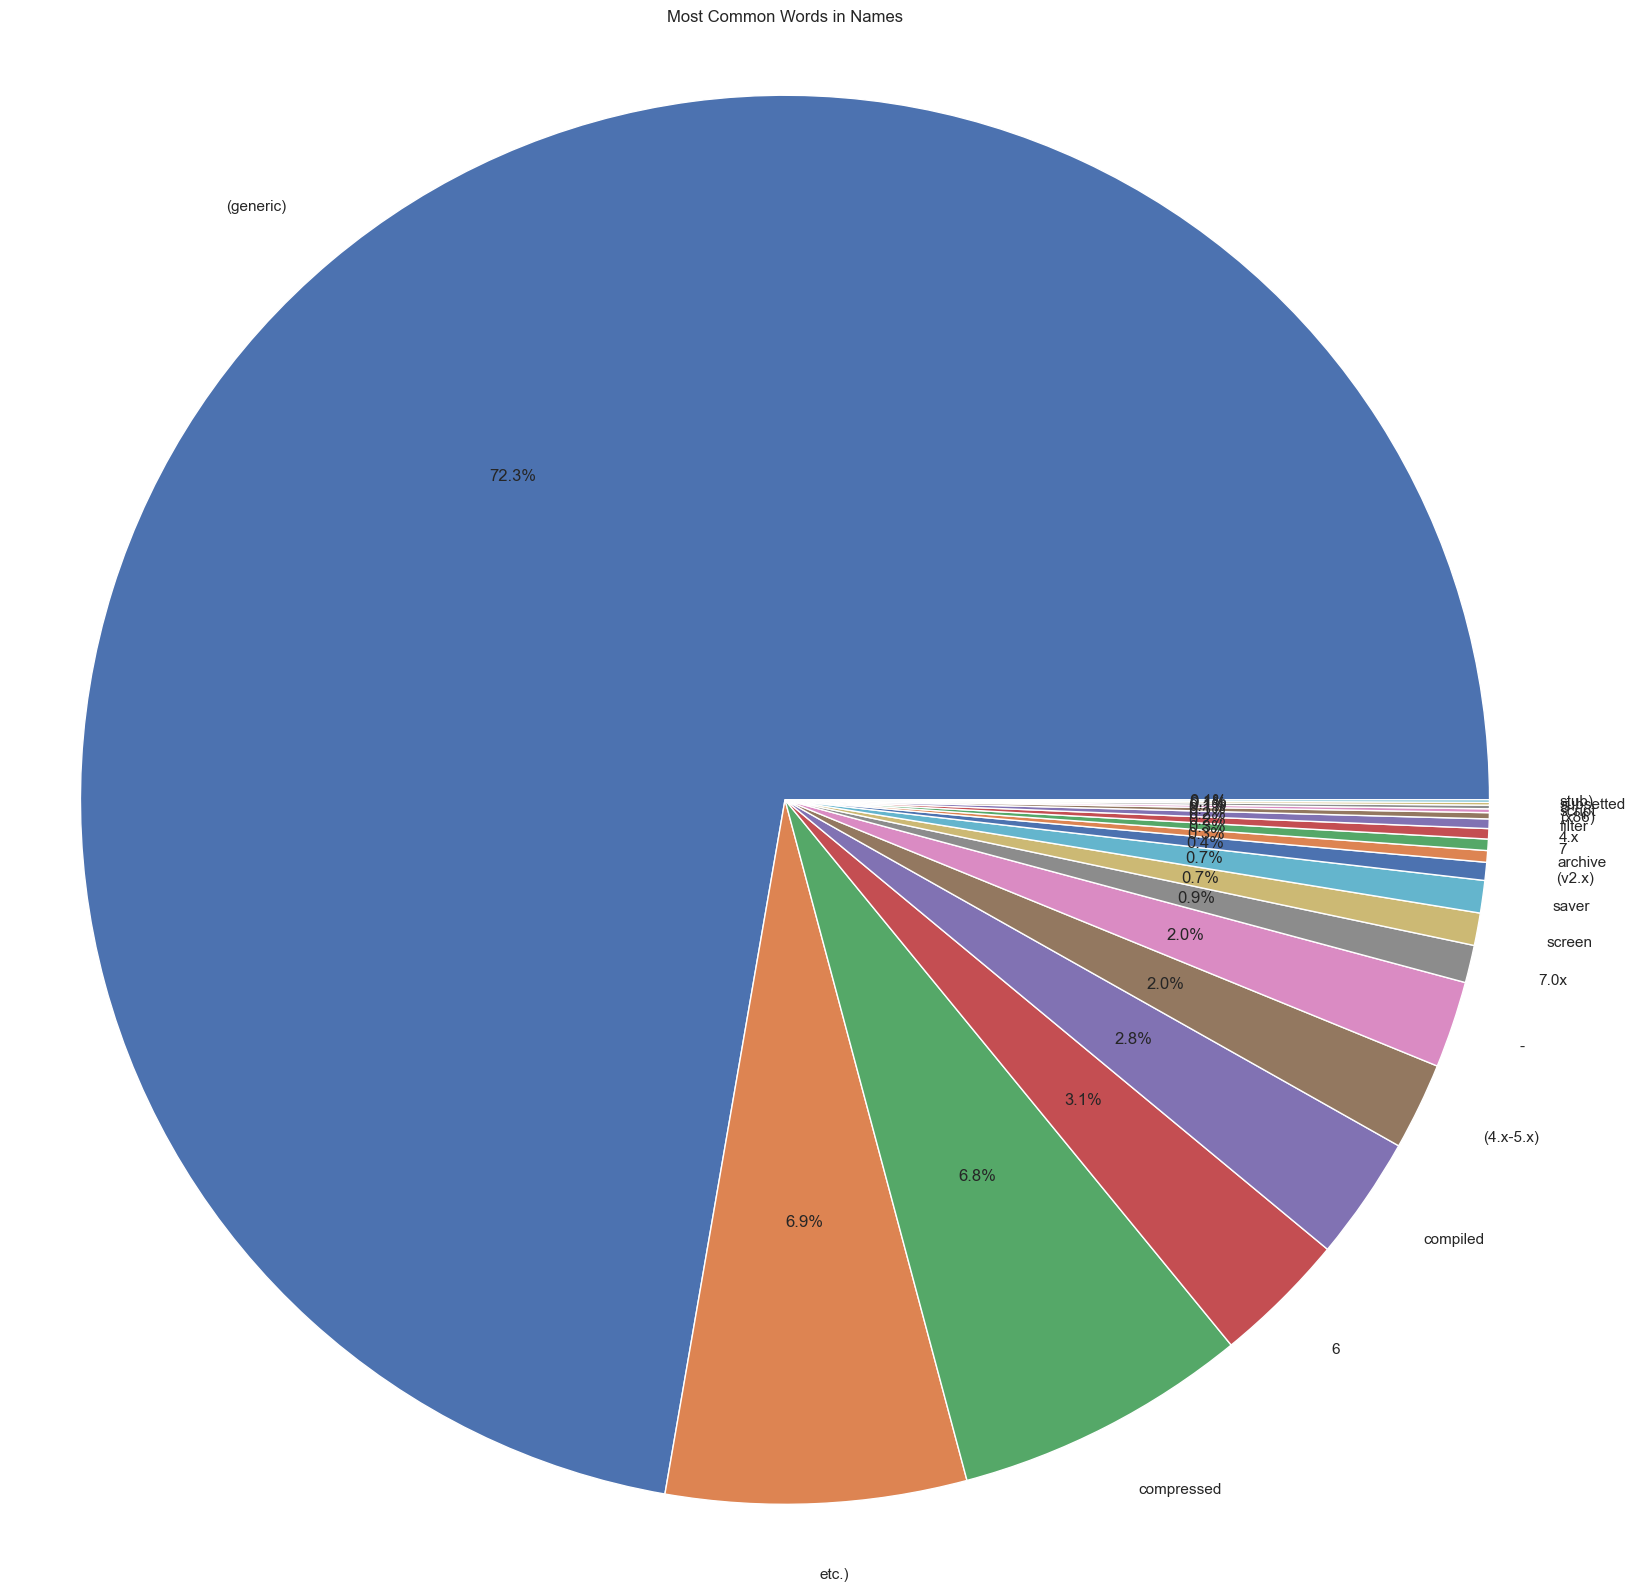

In [96]:
all_names = ' '.join(main_df['file_type_trid'].astype(str))
print(all_names[:10])
# Split the string into individual words
words = all_names.split()

# Create a dictionary to store word frequencies
word_counts = {}
excluded_words = ["win", "exe"]
# Count the frequency of each word
for word in words:
    #check if redundant
    if any(ex in word.lower() for ex in excluded_words):
        continue

    if word in word_counts:
        word_counts[word.lower()] += 1
    else:
        word_counts[word.lower()] = 1
   

# Sort the word frequencies in descending order
sorted_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Get the most common words and their counts
most_common_words = sorted_counts[:20]  # Adjust the number (5 in this case) as desired
print(len(sorted_counts))
# Extract the labels and counts from the most common words
labels = [word[0] for word in most_common_words]
counts = [word[1] for word in most_common_words]

# Plot the pie chart
plt.figure(figsize=(20, 20))
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title('Most Common Words in Names')
plt.axis('equal')
plt.show()

In [97]:
cat_df=df.copy()
c_test = testing_df.copy()

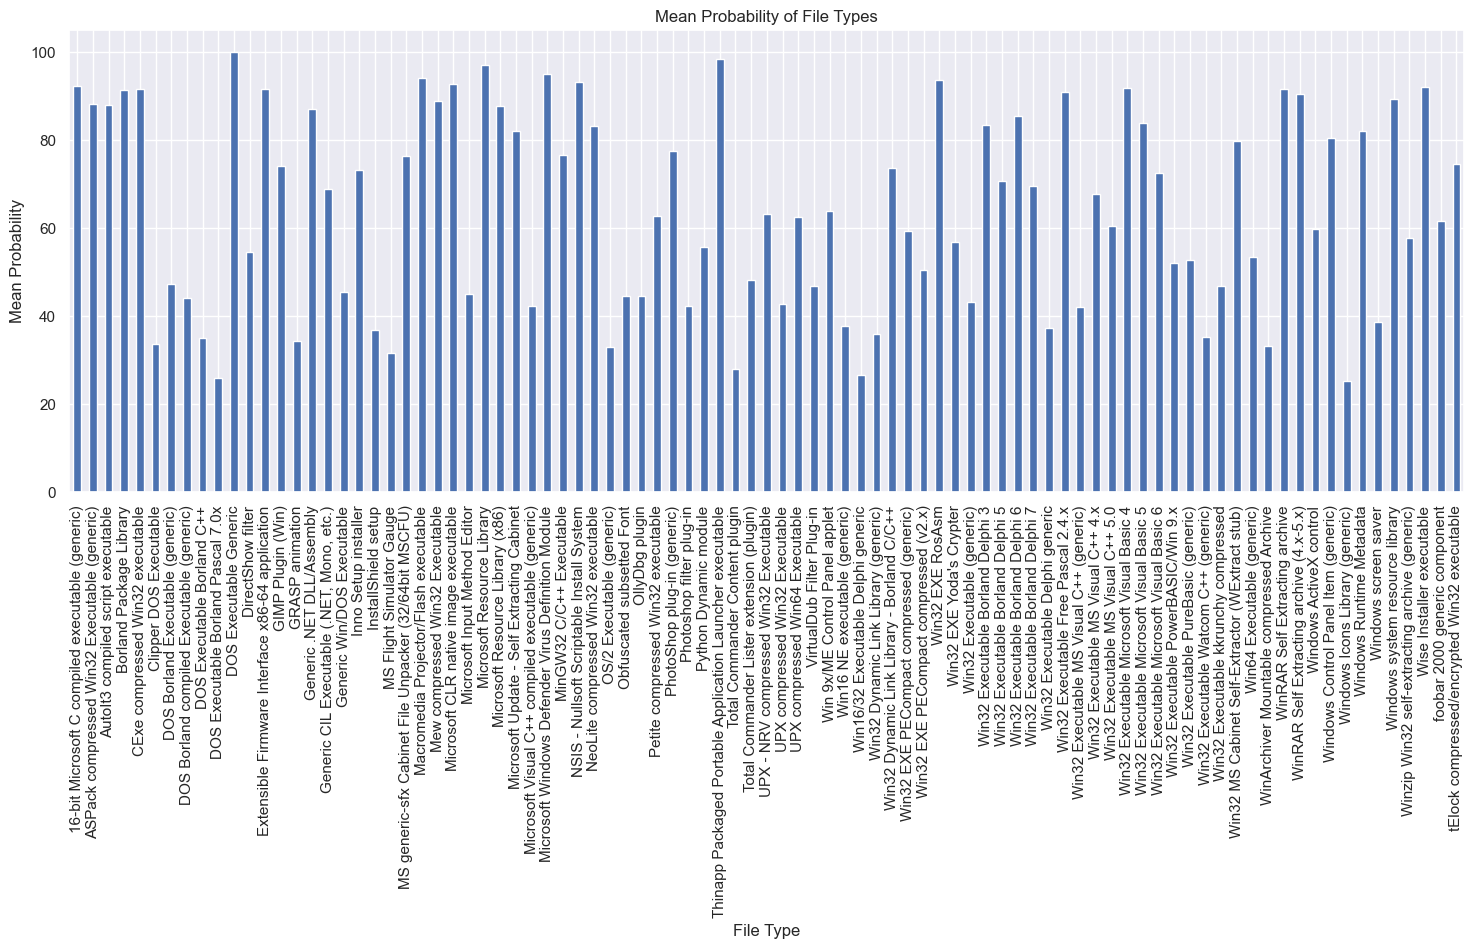

In [98]:
#In this code, we group the data by "file_type_trid" and calculate the mean probability ("file_type_prob_trid") for each file type. 
# Then, we create a bar plot where each bar represents a file type, 
# and the height of each bar corresponds to the mean probability of that file type.

# Group the data by file_type_trid and calculate the mean probability for each file type
file_type_prob_means = main_df.groupby('file_type_trid')['file_type_prob_trid'].mean()

# Plot the bar chart
plt.figure(figsize=(18, 6))
file_type_prob_means.plot(kind='bar')
plt.xlabel('File Type')
plt.ylabel('Mean Probability')
plt.title('Mean Probability of File Types')
plt.xticks(rotation=90)
plt.show()

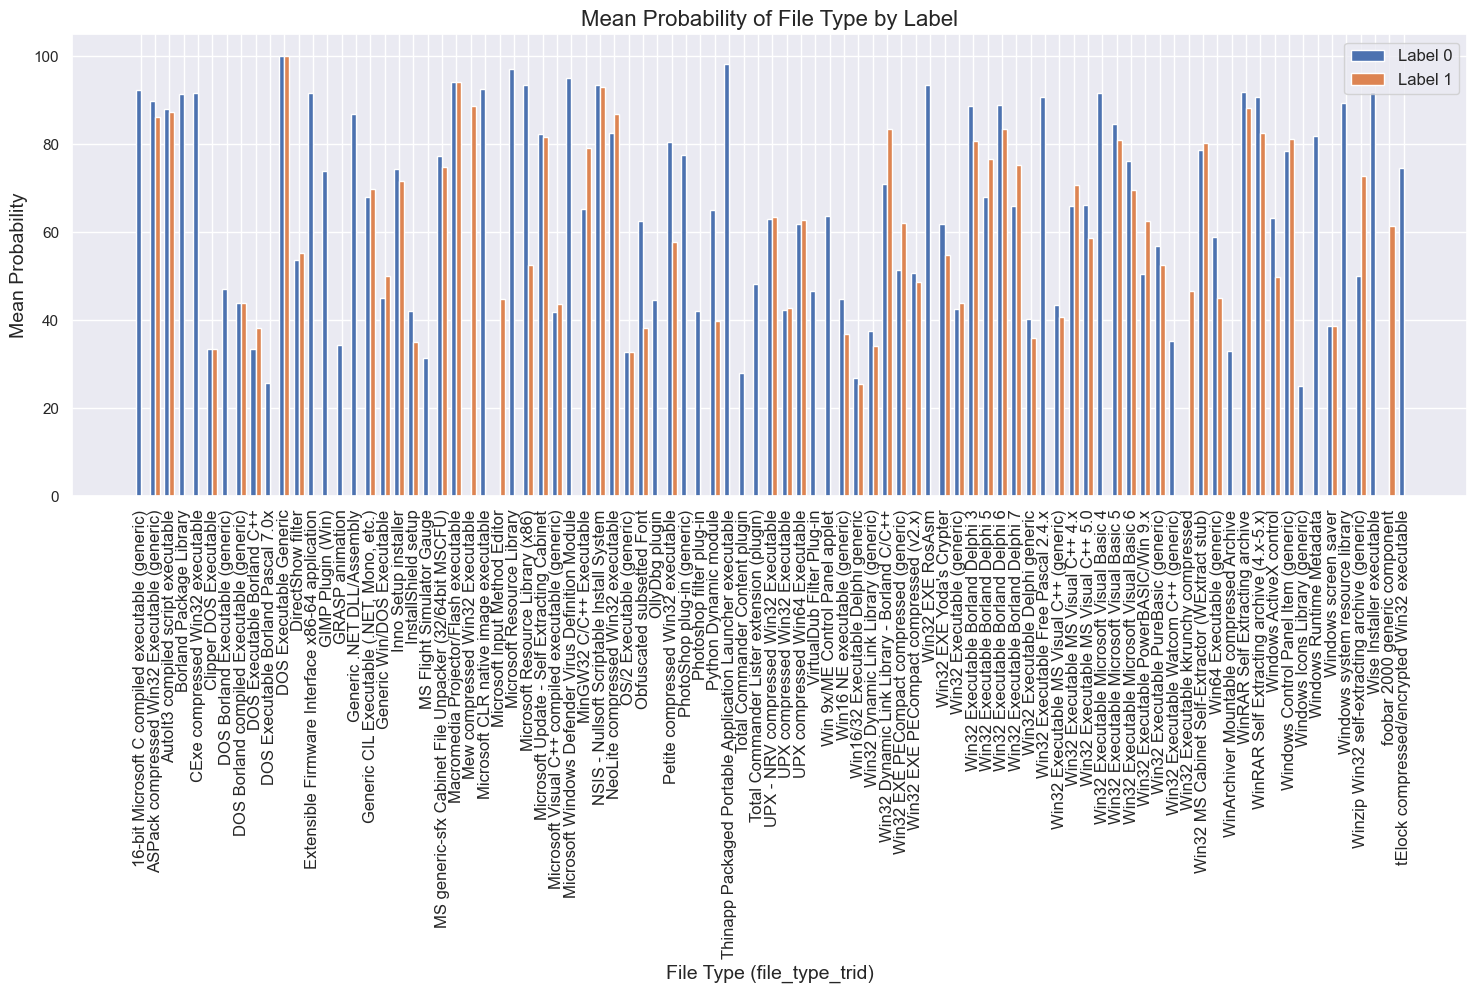

In [99]:
# Group the data by file_type_trid and label, and calculate the mean probabilities
grouped_data = main_df.groupby(['file_type_trid', 'label'])['file_type_prob_trid'].mean().unstack()

# Plotting the grouped bar chart
plt.figure(figsize=(18, 6))
bar_width = 0.35
bar_positions = np.arange(len(grouped_data))

# Plot bars for label 0
plt.bar(bar_positions - bar_width/2, grouped_data[0], width=bar_width, label='Label 0')

# Plot bars for label 1
plt.bar(bar_positions + bar_width/2, grouped_data[1], width=bar_width, label='Label 1')

plt.xlabel('File Type (file_type_trid)', fontsize=14)
plt.ylabel('Mean Probability', fontsize=14)
plt.title('Mean Probability of File Type by Label', fontsize=16)
plt.xticks(bar_positions, grouped_data.index, rotation=90, fontsize=12)
plt.legend(fontsize=12)

plt.show()

#when the mean probabiliy is high there are more label 0 (safe files)

Top 5 Files with the Highest Label 1 Percentages:
file_type_trid
Mew compressed Win32 Executable                   100.00000
Microsoft Input Method Editor                     100.00000
Win32 Executable kkrunchy compressed              100.00000
foobar 2000 generic component                     100.00000
Winzip Win32 self-extracting archive (generic)     59.24421
dtype: float64

Average Probabilities for the Top 5 Files:
file_type_trid
Mew compressed Win32 Executable                   88.8
Microsoft Input Method Editor                     44.9
Win32 Executable kkrunchy compressed              46.7
foobar 2000 generic component                     61.5
Winzip Win32 self-extracting archive (generic)    72.9
Name: 1, dtype: float64


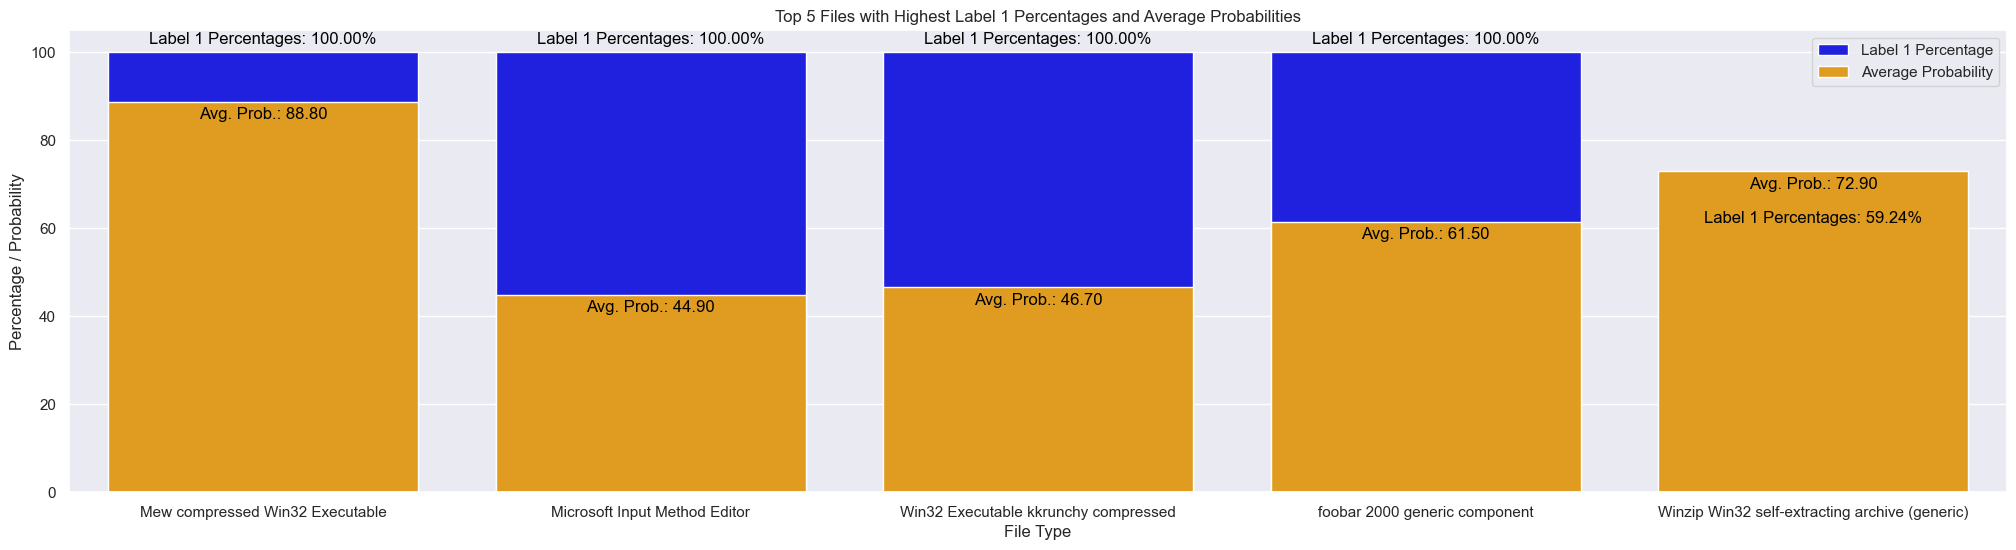

In [100]:
# Group the data by file_type_trid and label, and calculate the mean probabilities
grouped_data = main_df.groupby(['file_type_trid', 'label'])['file_type_prob_trid'].mean().unstack().fillna(0)

# Calculate the percentage of label 1 for each file type
total_counts = grouped_data.sum(axis=1)
label1_percent = grouped_data[1] / total_counts * 100

# Find the top 5 files with the highest label 1 percentages
top_label1_files = label1_percent.nlargest(5)
print("Top 5 Files with the Highest Label 1 Percentages:")
print(top_label1_files)
print()

# Calculate the average probabilities for the top 5 files
average_probabilities = grouped_data.loc[top_label1_files.index, 1]
print("Average Probabilities for the Top 5 Files:")
print(average_probabilities)

# Plot the label 1 percentages and average probabilities for the top 5 files
plt.figure(figsize=(25, 6))
sns.barplot(x=top_label1_files.index, y=top_label1_files.values, color='blue', label='Label 1 Percentage')
sns.barplot(x=top_label1_files.index, y=average_probabilities, color='orange', label='Average Probability')
plt.xlabel('File Type')
plt.ylabel('Percentage / Probability')
plt.title('Top 5 Files with Highest Label 1 Percentages and Average Probabilities')
for i, percentage in enumerate(top_label1_files):
    avg_probability = average_probabilities.iloc[i]
    plt.text(i, percentage + 2, f'Label 1 Percentages: {percentage:.2f}%', ha='center', color='black')
    plt.text(i, avg_probability - 4, f'Avg. Prob.: {avg_probability:.2f}', ha='center', color='black')

plt.legend()
plt.show()

Can we make new features with the boolean features?

we will see how interactions are for both malicious and non malicious files

has_tls      0.0   1.0
has_debug             
0.0         9514  2165
1.0        12657  2531


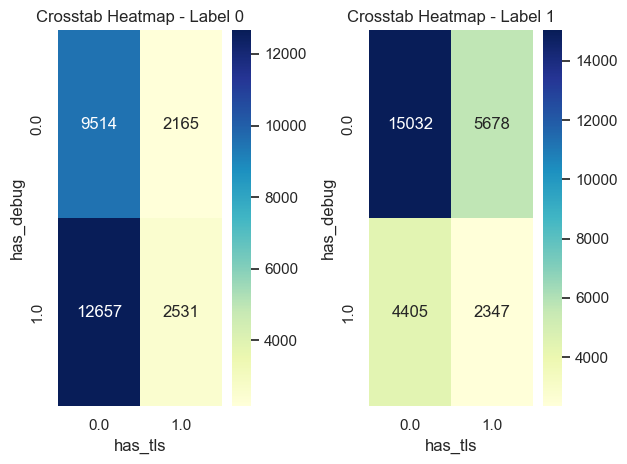

has_resources   0.0    1.0
has_debug                 
0.0            1861   9995
1.0             817  14596


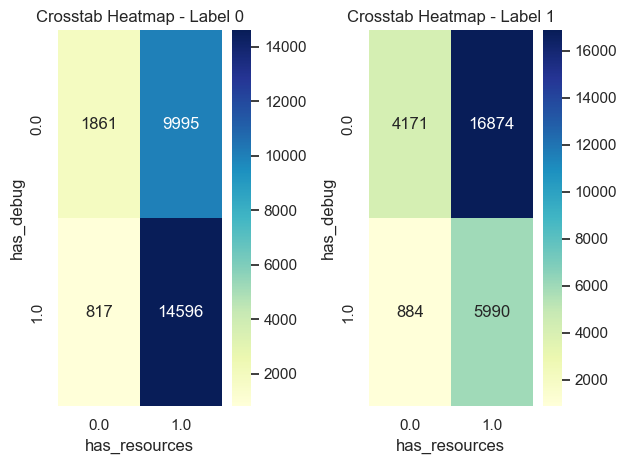

has_relocations   0.0    1.0
has_debug                   
0.0              6067   5532
1.0              4076  10967


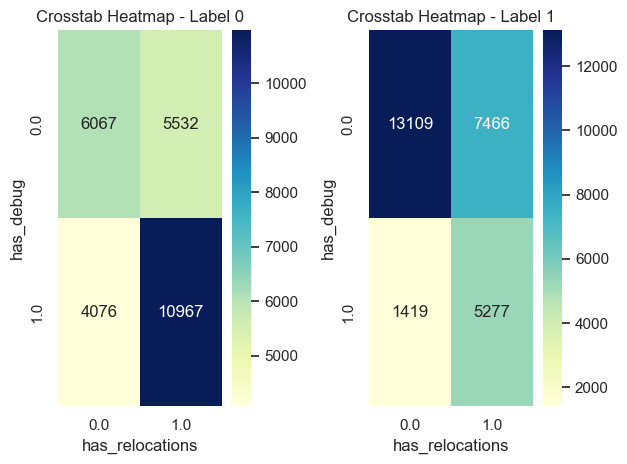

has_signature   0.0   1.0
has_debug                
0.0            8710  3167
1.0            8308  7152


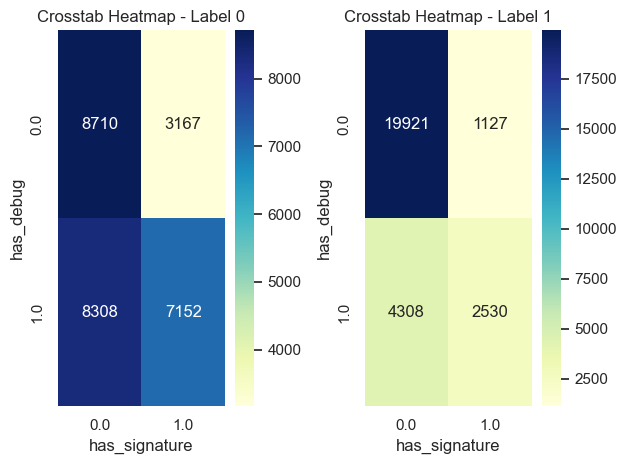

has_resources   0.0    1.0
has_tls                   
0.0            2364  20336
1.0             343   4521


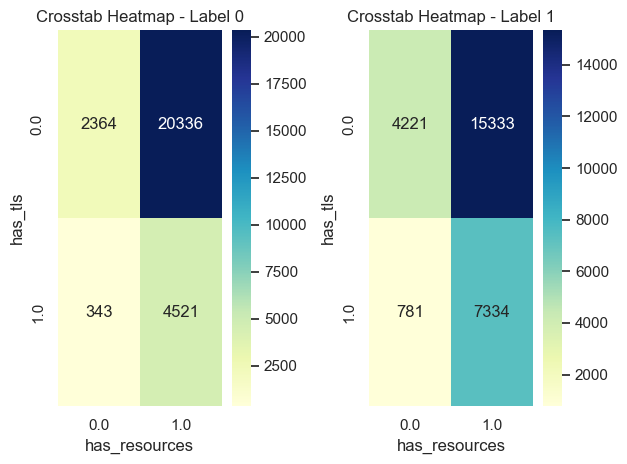

has_relocations   0.0    1.0
has_tls                     
0.0              9022  13139
1.0              1271   3466


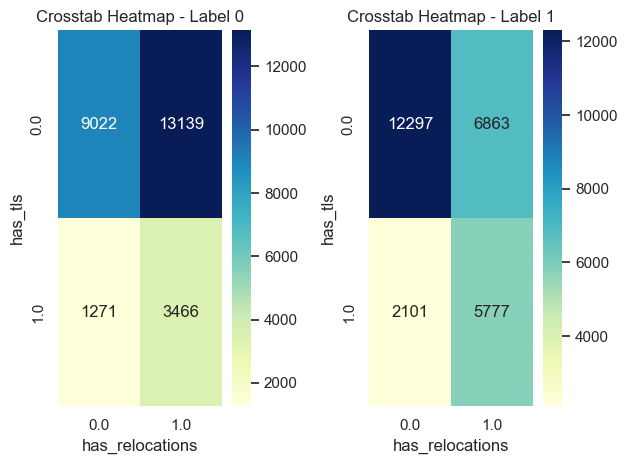

has_signature    0.0   1.0
has_tls                   
0.0            14947  7799
1.0             2264  2604


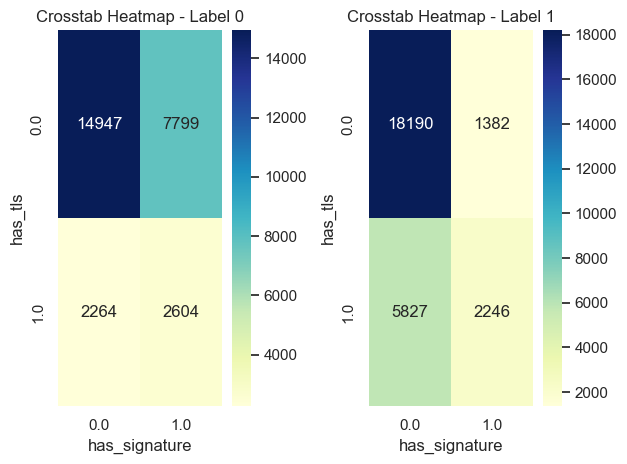

has_relocations   0.0    1.0
has_resources               
0.0              1670   1002
1.0              8738  15930


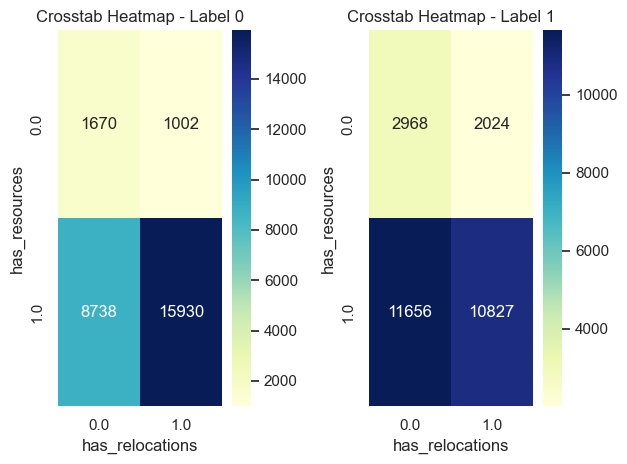

has_signature    0.0    1.0
has_resources              
0.0             2497    266
1.0            14968  10333


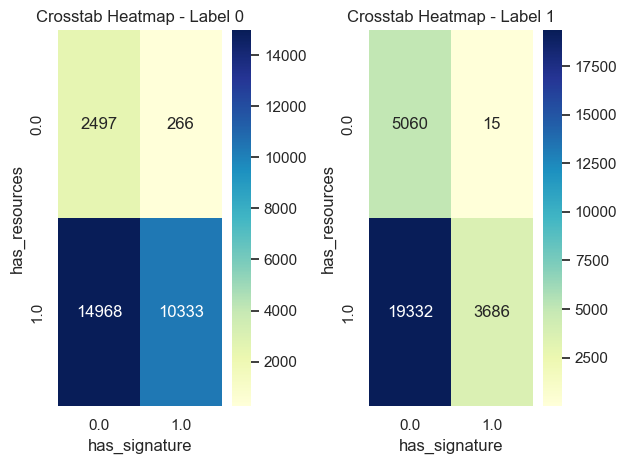

has_signature     0.0   1.0
has_relocations            
0.0              8187  2273
1.0              8904  8055


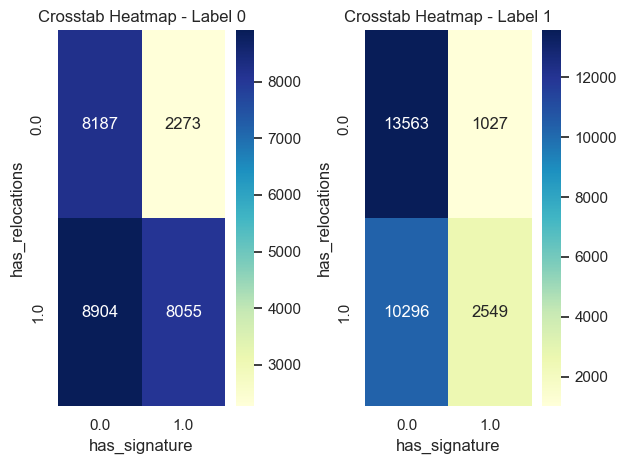

In [101]:
# we will check for non malicious files

non_mal = cat_df[main_df['label']==0]

mal = cat_df[main_df['label']==1]

for i in range(len(bool_features)-1):
    for j in range(i+1, len(bool_features)):
        nmfeat1 = non_mal[bool_features[i]]
        nmfeat2 = non_mal[bool_features[j]]
        nm_ct = pd.crosstab(nmfeat1, nmfeat2)
        mfeat1 = mal[bool_features[i]]
        mfeat2 = mal[bool_features[j]]
        m_ct = pd.crosstab(mfeat1, mfeat2)

        print(nm_ct)

        plt.subplot(1, 2, 1)
        sns.heatmap(nm_ct, annot=True, fmt='d', cmap='YlGnBu')
        plt.xlabel(bool_features[j])
        plt.ylabel(bool_features[i])
        plt.title('Crosstab Heatmap - Label 0')

        # Plot the second heatmap for Label 1
        plt.subplot(1, 2, 2)
        sns.heatmap(m_ct, annot=True, fmt='d', cmap='YlGnBu')
        plt.xlabel(bool_features[j])
        plt.ylabel(bool_features[i])
        plt.title('Crosstab Heatmap - Label 1')

        # Adjust the layout and display the plot
        plt.tight_layout()
        plt.show()



so what can we learn?

we can see that features have special interactions between them! for example having has_debug and has_relocations 0 is far more likely in malwares than in non malware.

why would we like interacions?
because saying relocations is 0  and debug 0 having 2 seperate effects rather than having a combined effect would make our models "miss" certain interactions

having these interactions means that just using 2 seperate features would be wrong and lead to extra bias in our model, and thus we need to add more features for the interactions

Steps for pre processing

1. removing features by correlations

2. removing outliers

3. dealing with missing values

4. normilization

In [102]:
train_df = cat_df.copy()
train_df.head()

#bool_features = cross_feat

sha256     size      vsize  \
0  a5d72c609a1594621e8eb775e7324d4fc291d5569cfefd...  6744064  6799360.0   
1  ccaa49b76e6fd84842399c4389e2086a5a3687dfabbf01...    22016    45056.0   
2  b0b126adc73b980a114e38027b082d149fcf491547452f...   686136   704512.0   
3  ff6176c53ca9b58040c93870c264843b93b5e290c28e57...     8192    36864.0   
4  59b8bc6ac157a553440978406c8aa8eb8a25c166af1175...   396288   421888.0   

   imports  exports  has_debug  has_relocations  has_resources  has_signature  \
0    524.0      3.0        0.0              1.0            1.0            0.0   
1      2.0      0.0        0.0              0.0            1.0            0.0   
2    133.0      4.0        1.0              1.0            1.0            1.0   
3      6.0      0.0        0.0              0.0            0.0            0.0   
4    133.0      0.0        1.0              1.0            1.0            0.0   

   has_tls  symbols  numstrings  paths  urls  registry    MZ  printables  \
0      1.0      0.0     64882.0    0.0   0.0       0.0  28.0    899075.0   
1      0.0      0.0        89.0    0.0   0.0       0.0   1.0       856.0   
2      0.0      0.0      2699.0    0.0  32.0       0.0   2.0     32767.0   
3      0.0      NaN        71.0    0.0   0.0       0.0   1.0       678.0   
4      0.0      0.0      4729.0    0.0   0.0       0.0   5.0     35881.0   

    avlength                            file_type_trid  file_type_prob_trid  \
0  13.857079  Win32 EXE PECompact compressed (generic)                 64.2   
1   9.617978      Win32 Dynamic Link Library (generic)                 38.4   
2  12.140422                Win64 Executable (generic)                 82.0   
3   9.549296                Win64 Executable (generic)                 28.0   
4   7.587439                Win64 Executable (generic)                 32.2   

          A         B    C  label  
0 -3.978981  5.732354   er      1  
1  7.064133  5.738201   er      0  
2  1.052727  5.722733  gow      0  
3  2.217531  5.896053   vh      1  
4  9.401164       NaN   vh      1

['er' 'gow' 'vh' 'cs' 'bf' 'mc' 'vr' nan]


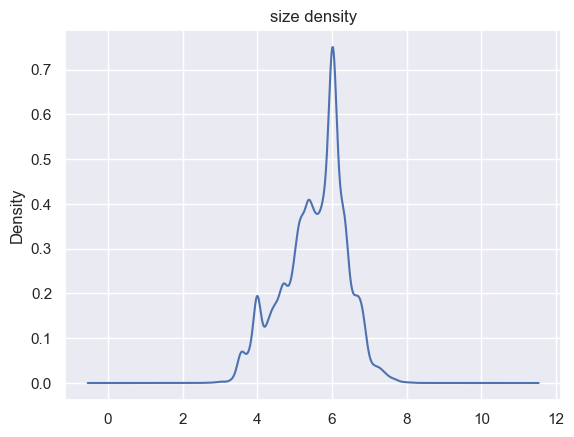

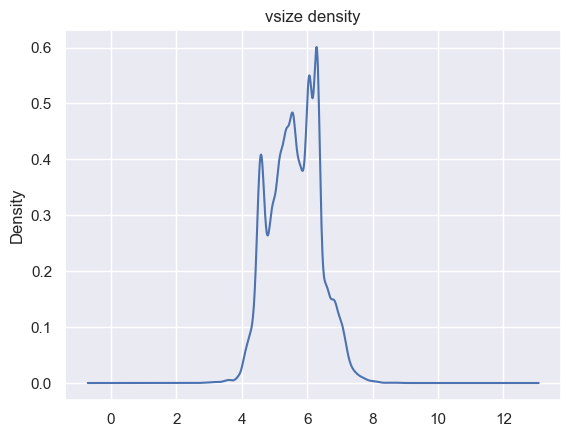

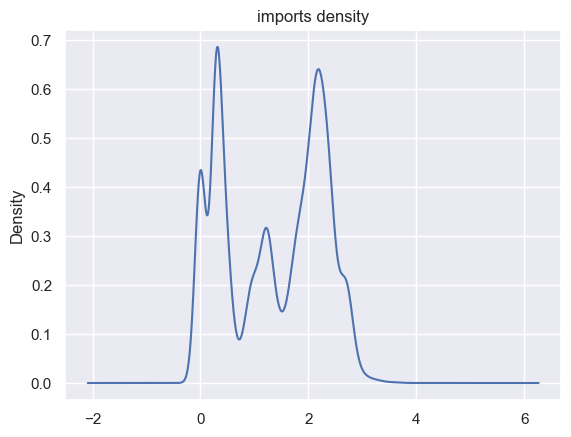

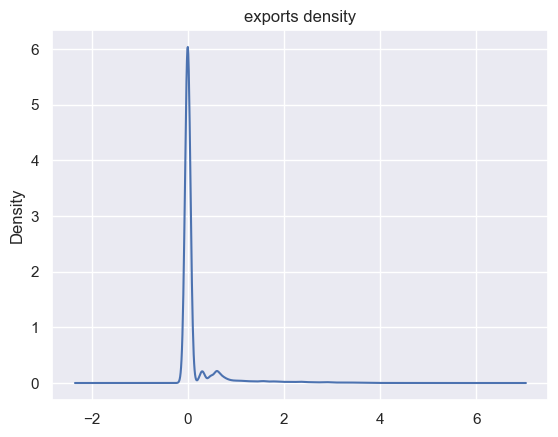

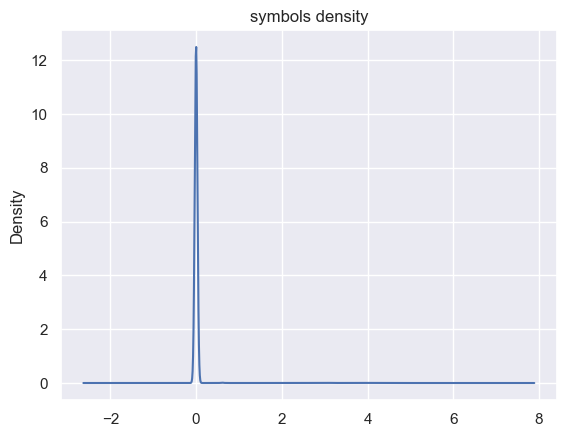

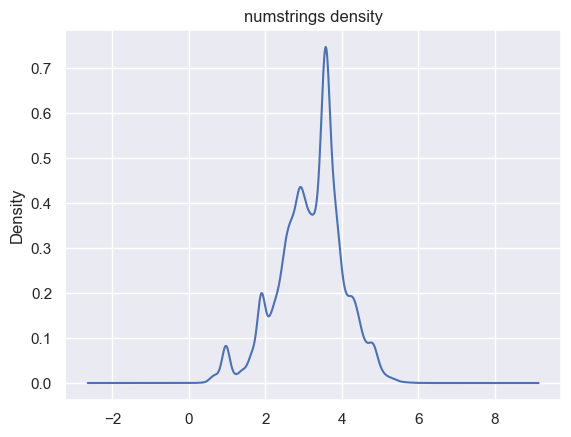

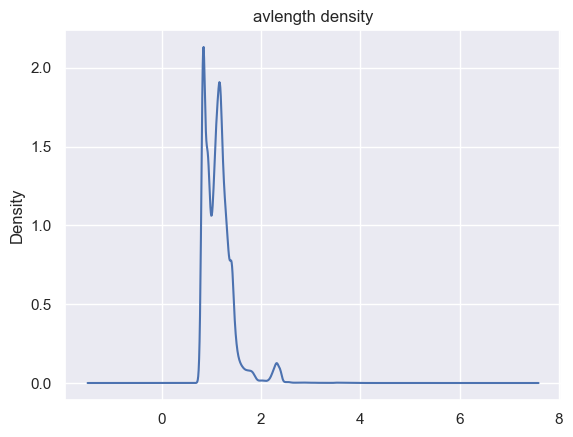

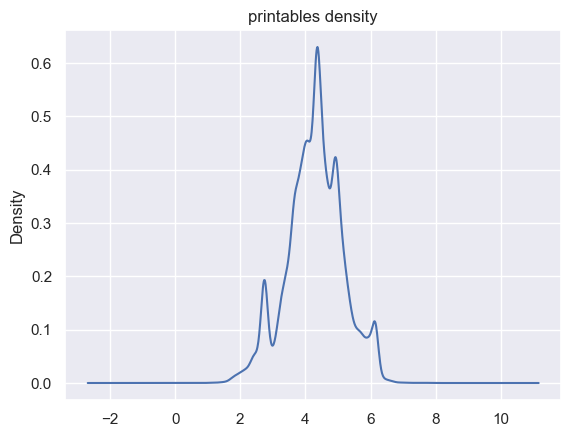

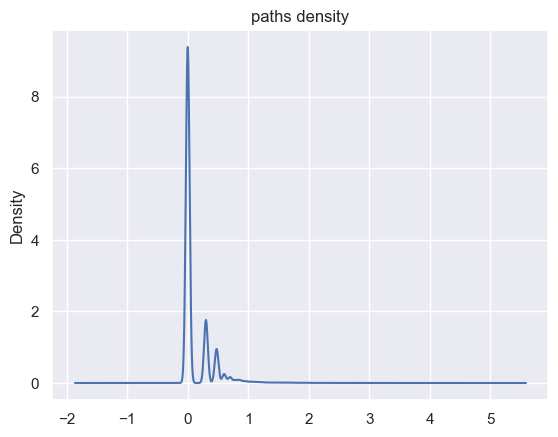

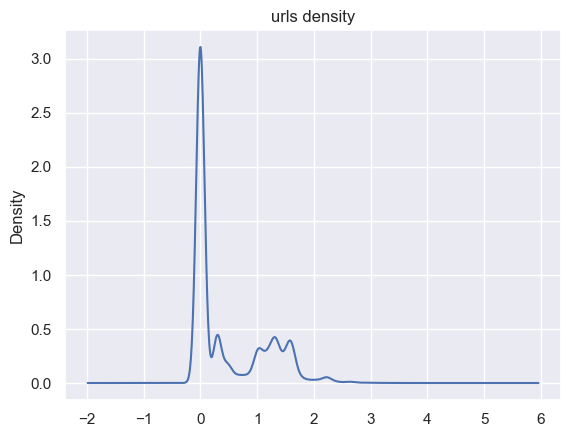

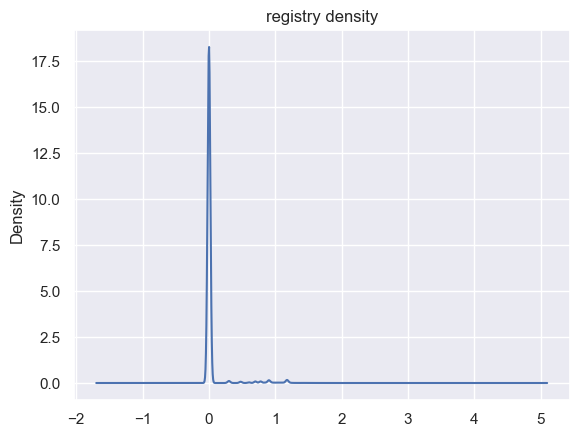

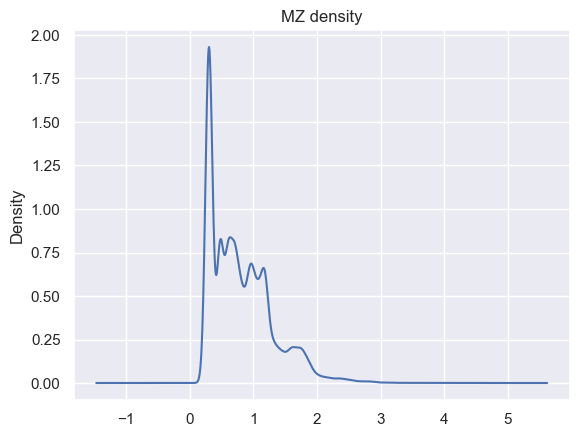

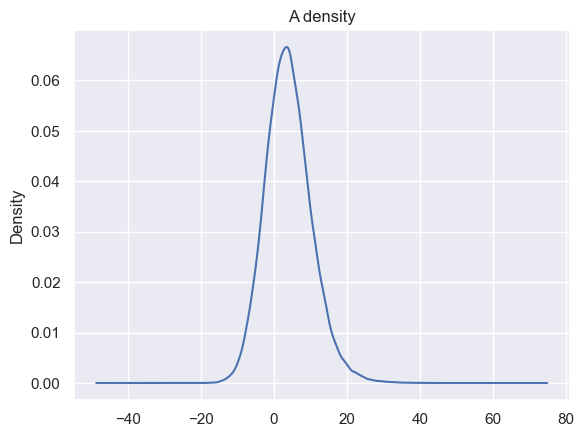

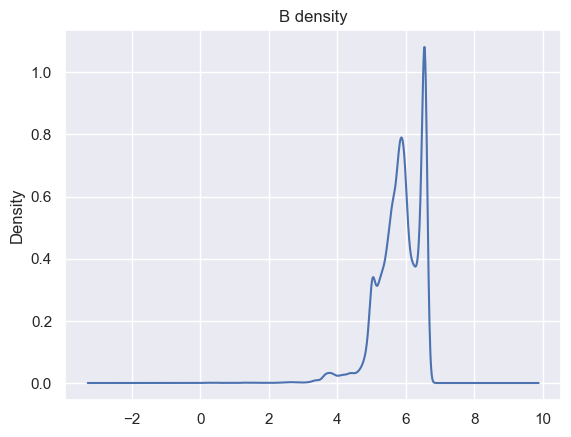

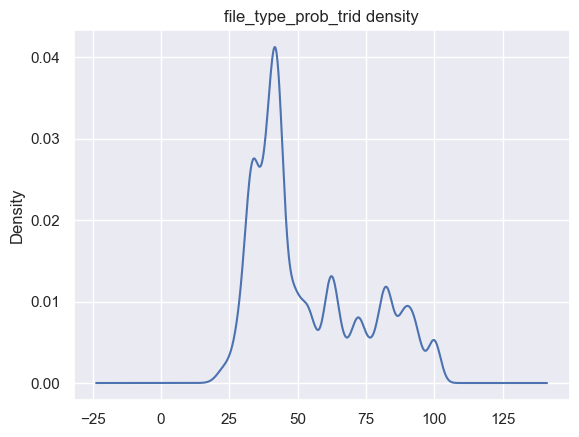

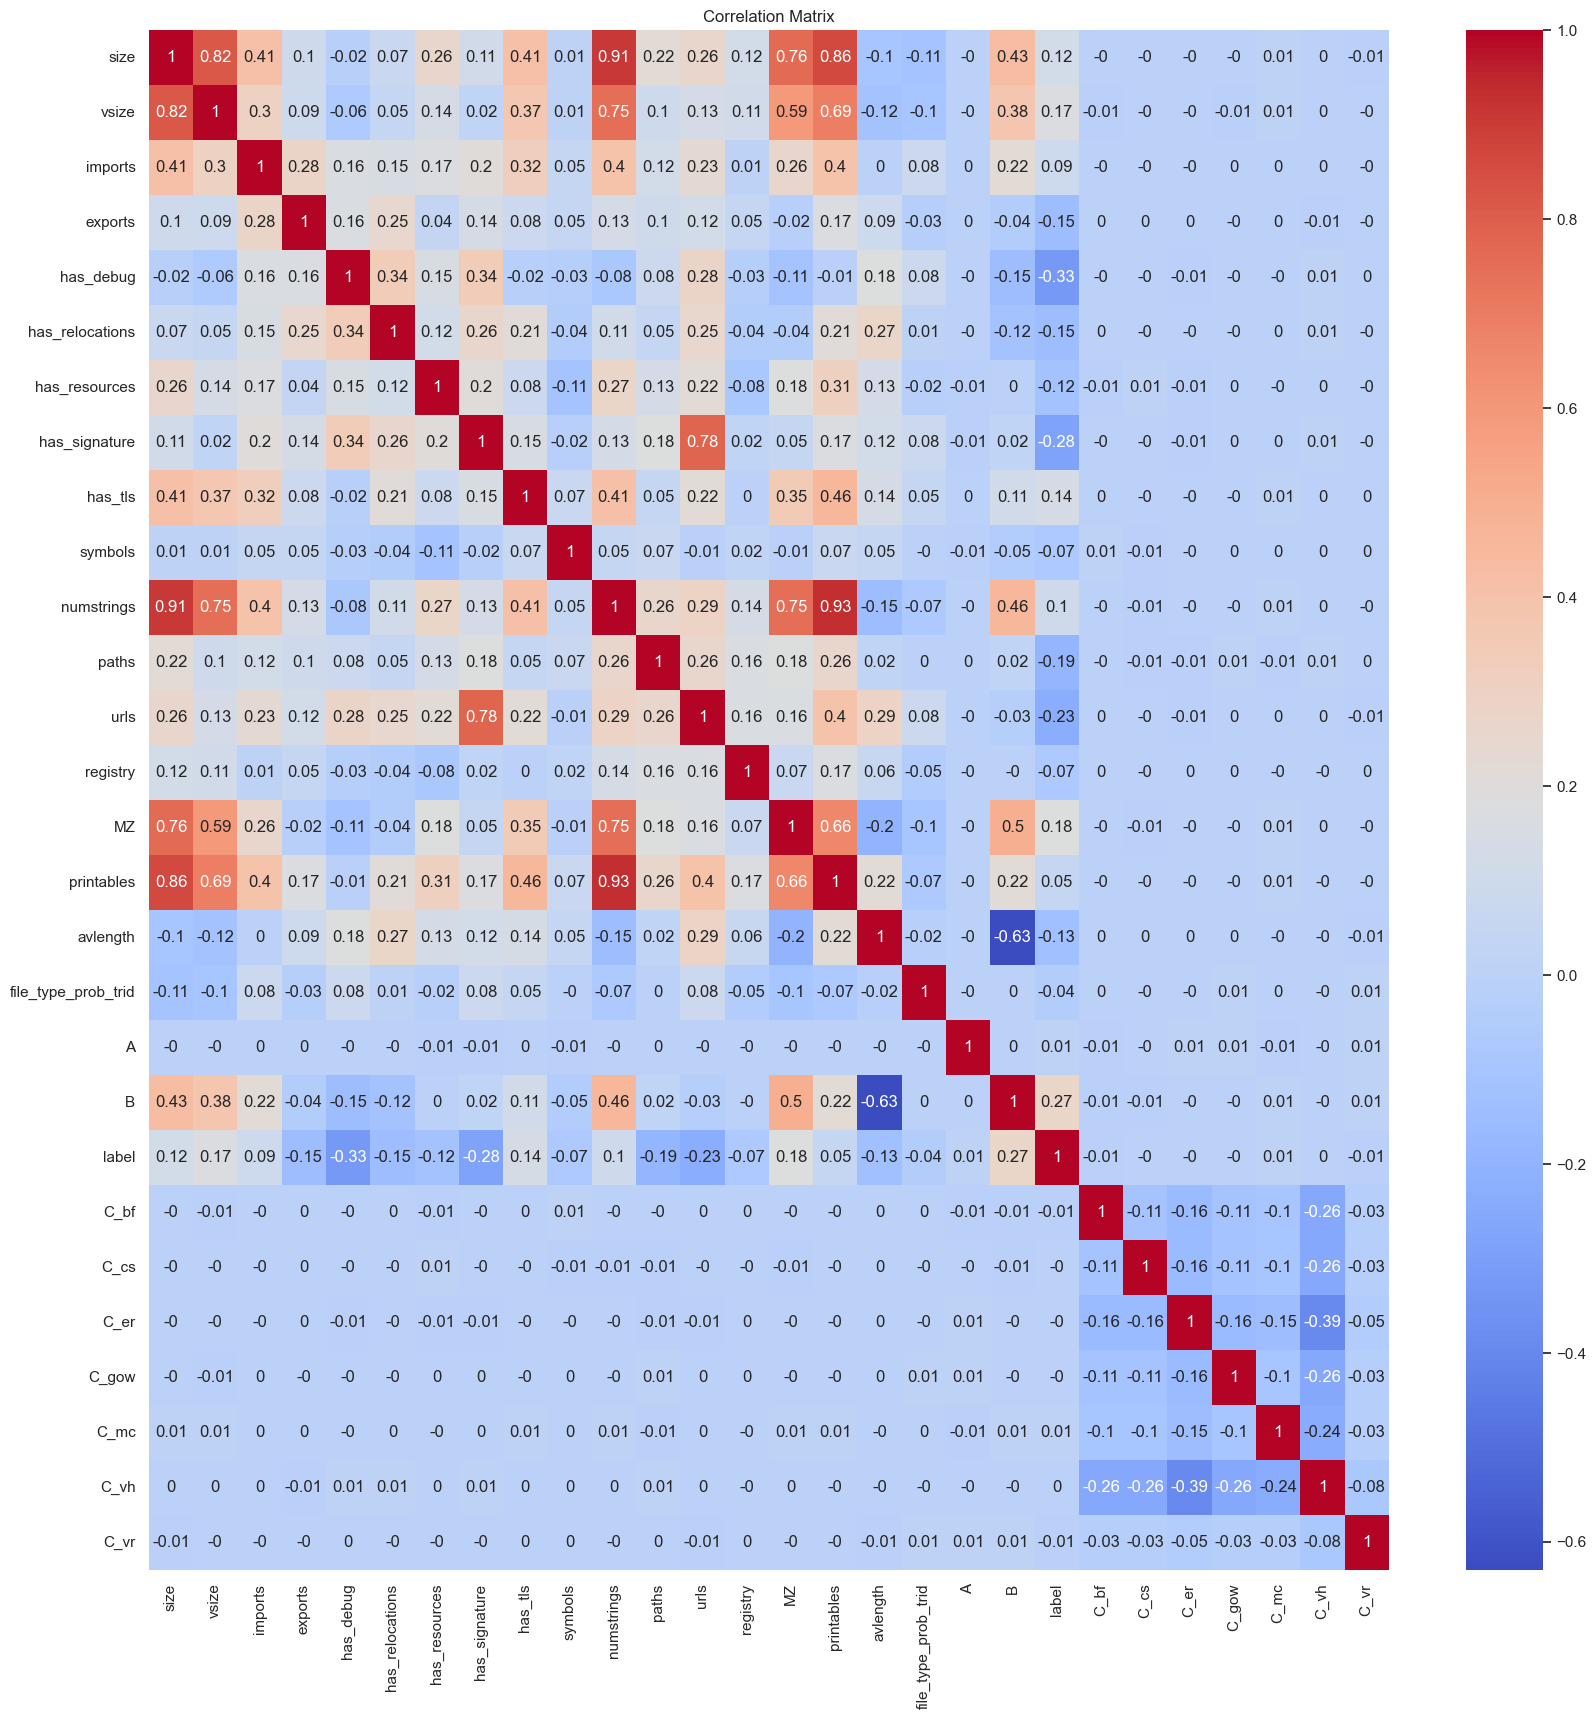

In [103]:
### lets define the train_df -> adding the log to some of the features

#we are andding log to: ['size', 'vsize','numstrings','printables', 'MZ', 'urls', 'paths', 'avlength' ,'symbols', 'exports', 'imports', 'registry']
for feature in to_log:
    train_df[feature] = np.log10(train_df[feature]+1) # so 0 features will be ok
    
train_df.head()

train_df['C'].fillna("unknown", inplace=True)


# and turn C into a catagorial feature

C_val = cat_df["C"].unique()
print(C_val)
C_val[-1] = 'unknown'


#this will make the same adjustments to the test df, if something is not in the original c values its None
c_test.loc[~testing_df['C'].isin(C_val), 'C'] = None
c_test['C'].fillna("unknown", inplace=True)

#
enc = OneHotEncoder()
enc.fit(train_df[['C']])
#

dummy_variables = enc.transform(train_df[['C']]).toarray()
dummy_df = pd.DataFrame(dummy_variables, columns=enc.get_feature_names_out(['C']))
train_df = pd.concat([train_df, dummy_df], axis=1)
train_df.drop(["C", 'C_unknown'],axis=1, inplace=True)

dummy_variables = enc.transform(c_test[['C']]).toarray()
dummy_df = pd.DataFrame(dummy_variables, columns=enc.get_feature_names_out(['C']))
c_test = pd.concat([c_test, dummy_df], axis=1)
c_test.drop(["C", 'C_unknown'],axis=1, inplace=True)

for col in numerical:
    if(col=='suspicious_combos'):
        train_df[col].hist()
        plt.title(col+" hist")
    else:
        train_df[col].plot.density()
        plt.title(col+" density")
    plt.show()
corr_matrix = train_df.corr().round(2)
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.title("Correlation Matrix")
plt.show()

can we add more features? manipulations? yes!

for example code density (vsize/filesize) import/export ratio and printables %

whats good about this? 
1. we are working with log values so we can just subtract instead of dividing
2. we have features that are heavily correlated with others, thus we can remove those features and turn them in to 1 combined

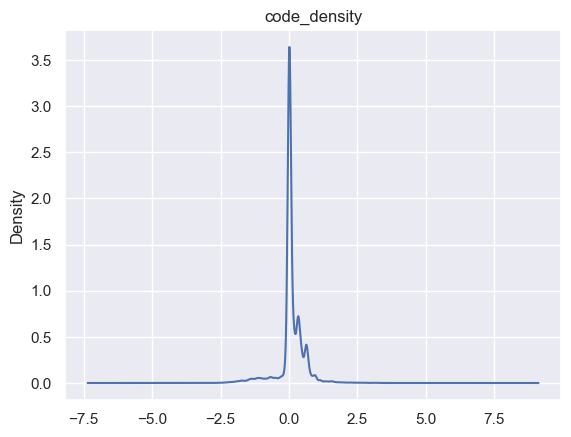

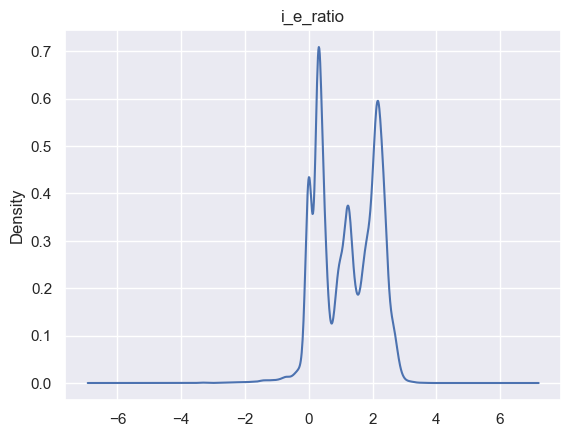

In [104]:
train_df['code_density'] = train_df['vsize'] - train_df['size']
train_df['i_e_ratio'] = train_df['imports'] - train_df['exports']
c_test['code_density'] = c_test['vsize'] - c_test['size']
c_test['i_e_ratio'] = c_test['imports'] - c_test['exports']
numerical+=['code_density', 'i_e_ratio']
for n in ['code_density', 'i_e_ratio']:
    plt.title(n)
    train_df[n].plot.density()
    plt.show()

In [105]:
X_train = train_df.copy()
X_train.drop('label', axis=1, inplace=True)
X_train.describe()
y_train = train_df['label']

# Split the data into training and validation sets
Xlog_train, Xlog_val, ylog_train, ylog_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0, shuffle=True)

In [106]:
'''
# Perform TF-IDF vectorization on the 'file_type_trid' feature
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
Xlog_train_tfidf = tfidf_vectorizer.fit_transform(Xlog_train['file_type_trid'])
Xlog_val_tfidf = tfidf_vectorizer.transform(Xlog_val['file_type_trid'])
c_test_tfidf = tfidf_vectorizer.transform(c_test['file_type_trid'])

# Transform TF-IDF matrix into a single vector
Xlog_train_tfidf_sum = Xlog_train_tfidf.sum(axis=1)
Xlog_val_tfidf_sum = Xlog_val_tfidf.sum(axis=1)
c_test_tfidf_sum = c_test_tfidf.sum(axis=1)

# Add the vector as a new feature to the datasets
Xlog_train['tfidf_sum'] = Xlog_train_tfidf_sum
Xlog_val['tfidf_sum'] = Xlog_val_tfidf_sum
c_test['tfidf_sum'] = c_test_tfidf_sum
'''

"\n# Perform TF-IDF vectorization on the 'file_type_trid' feature\ntfidf_vectorizer = TfidfVectorizer(stop_words='english')\nXlog_train_tfidf = tfidf_vectorizer.fit_transform(Xlog_train['file_type_trid'])\nXlog_val_tfidf = tfidf_vectorizer.transform(Xlog_val['file_type_trid'])\nc_test_tfidf = tfidf_vectorizer.transform(c_test['file_type_trid'])\n\n# Transform TF-IDF matrix into a single vector\nXlog_train_tfidf_sum = Xlog_train_tfidf.sum(axis=1)\nXlog_val_tfidf_sum = Xlog_val_tfidf.sum(axis=1)\nc_test_tfidf_sum = c_test_tfidf.sum(axis=1)\n\n# Add the vector as a new feature to the datasets\nXlog_train['tfidf_sum'] = Xlog_train_tfidf_sum\nXlog_val['tfidf_sum'] = Xlog_val_tfidf_sum\nc_test['tfidf_sum'] = c_test_tfidf_sum\n"

In [107]:
def AddTop5_and_fit(X, y, feature, k):
    # Perform TF-IDF vectorization on the 'file_type_trid' feature
    tfidf_vectorizer = TfidfVectorizer(smooth_idf=True, use_idf=True)
    v = tfidf_vectorizer.fit_transform(X[feature])
    correlations = v.T.dot(y)
    correlations = correlations.squeeze()
    # Get the indices of the 5 most correlated words
    #print(correlations)
    top_indices = np.abs(correlations).argsort()[-k:][::-1]

    # Get the feature names from the TF-IDF vectorizer
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Get the top correlated words
    top_words = feature_names[top_indices]

    new_cols = pd.DataFrame(v[:, top_indices].todense(), columns=top_words)
    new_cols.head()
    X.reset_index(drop=True, inplace=True)
    new_cols.reset_index(drop=True, inplace=True)
    X = pd.concat([X, new_cols], axis=1)

    return tfidf_vectorizer, top_words, X, new_cols

def AddTfIdf(X, feature, values, vect):
    X_tfidf = vect.transform(X[feature])

    new_cols = pd.DataFrame(X_tfidf.todense(), columns=vect.get_feature_names_out())
    new_cols = new_cols[values]
    X.reset_index(drop=True, inplace=True)
    new_cols.reset_index(drop=True, inplace=True)   
    X = pd.concat([X, new_cols], axis=1)
    
    return X

v, top_words, Xlog_train, new_cols = AddTop5_and_fit(Xlog_train, ylog_train, 'file_type_trid', 5)
Xlog_val = AddTfIdf(Xlog_val, 'file_type_trid', top_words, v)
c_test = AddTfIdf(c_test, 'file_type_trid', top_words, v)

In [108]:
Xlog_val.head()
ylog_train.reset_index(drop=True,inplace=True)
ylog_val.reset_index(drop=True,inplace=True)

In [109]:
Xlog_train.head()

sha256      size     vsize  \
0  bcbb6983c4994e67a8cbb4a881f1b3c394ca350b031e92...  4.882462  4.992576   
1  4effece7e4766fd6dcf9086ac1b7510cfda9fde032a098...  5.551880  5.580844   
2  4322f9cfc0e93d5c6503b2d5e99196936481a31ff35254...  6.053205  6.054840   
3  689e467c1d57b4492502f620cb6004e5f09c5db8c72cd6...  5.983344  6.316511   
4  b54b1d51bfa1099ff08251f4f8a7d512bda09232f74868...  6.203425  6.216586   

    imports  exports  has_debug  has_relocations  has_resources  \
0  0.301030      0.0        1.0              1.0            1.0   
1  1.544068      0.0        1.0              1.0            1.0   
2  2.394452      0.0        1.0              1.0            1.0   
3  0.477121      0.0        0.0              NaN            1.0   
4  2.264818      0.0        NaN              0.0            1.0   

   has_signature  has_tls  symbols  numstrings  paths     urls  registry  \
0            0.0      0.0      0.0    2.756636    0.0  0.00000       0.0   
1            0.0      0.0      0.0    3.828853    0.0  0.30103       0.0   
2            1.0      1.0      0.0    3.520221    0.0  1.60206       0.0   
3            0.0      0.0      NaN    3.603577    NaN  0.00000       0.0   
4            0.0      0.0      0.0    3.513218    1.0      NaN       0.0   

         MZ  printables  avlength                             file_type_trid  \
0  0.602060    3.892317       NaN  Generic CIL Executable (.NET, Mono, etc.)   
1  0.698970    4.596784  0.836398              Win16 NE executable (generic)   
2  0.954243    4.916749  1.413736       Windows Control Panel Item (generic)   
3  1.176091         NaN  0.826348                 Win32 Executable (generic)   
4       NaN    4.497648  1.027370  Win32 Executable Microsoft Visual Basic 6   

   file_type_prob_trid         A         B  C_bf  C_cs  C_er  C_gow  C_mc  \
0                 70.8  6.369221  5.343785   0.0   0.0   0.0    0.0   0.0   
1                 45.5  4.579615  4.928144   0.0   0.0   0.0    0.0   0.0   
2                 88.3  5.175830  5.833490   0.0   0.0   0.0    0.0   0.0   
3                 42.7  0.323757  6.554471   0.0   0.0   0.0    0.0   0.0   
4                 69.4  3.082603  5.500801   0.0   0.0   0.0    0.0   0.0   

   C_vh  C_vr  code_density  i_e_ratio  executable   generic     win32  win64  \
0   1.0   0.0      0.110114   0.301030    0.174594  0.161164  0.000000    0.0   
1   1.0   0.0      0.028964   1.544068    0.171583  0.158385  0.000000    0.0   
2   1.0   0.0      0.001635   2.394452    0.000000  0.159802  0.000000    0.0   
3   1.0   0.0      0.333166   0.477121    0.530024  0.489254  0.692608    0.0   
4   1.0   0.0      0.013161   2.264818    0.189940  0.000000  0.248204    0.0   

     visual  
0  0.000000  
1  0.000000  
2  0.000000  
3  0.000000  
4  0.374836

In [ ]:
def sus_words_fit_predict(X, y, feature):
    scale = StandardScaler()
    vectorizer = TfidfVectorizer(smooth_idf=True, use_idf=True)
    vec = vectorizer.fit_transform(X[feature])
    word_df = pd.DataFrame(vec.todense(), columns=vectorizer.get_feature_names_out())
    word_df = scale.fit_transform(word_df)
    pca = PCA(0.99)
    word_reduced = pca.fit_transform(word_df)
    print('componentes to explain 99 percent of the data',len(pca.components_))
    lr = LogisticRegression(solver='liblinear', penalty='l2').fit(word_reduced, y)
    X['sus_type_proba'] = lr.predict_proba(word_reduced)[:, 1]
    
    return (lr, vectorizer, pca, scale)

def sus_words_predict(X, feature, estimator, vectorizer, pca, scaler):
    vec = vectorizer.transform(X[feature])
    word_df = pd.DataFrame(vec.todense(), columns=vectorizer.get_feature_names_out())
    word_reduced  =pca.transform(word_df)
    pred = estimator.predict_proba(word_reduced)[:, 1]
    X['sus_type_proba'] = pred
    

In [ ]:
lr, vec, pc, scale = sus_words_fit_predict(Xlog_train, ylog_train, 'file_type_trid')
sus_words_predict(Xlog_val, 'file_type_trid', lr, vec, pc, scale)
sus_words_predict(c_test, 'file_type_trid', lr, vec, pc, scale)

In [110]:
#we will remove sha256 and file_type_trid because they no meaning:
removed_features = ['sha256', 'file_type_trid']
norm_features += ['code_density']
Xlog_train.drop(removed_features, axis=1, inplace=True)
Xlog_val.drop(removed_features, axis=1, inplace=True)
c_test.drop(removed_features, axis=1, inplace=True)

In [111]:
Xlog_train.head()

size     vsize   imports  exports  has_debug  has_relocations  \
0  4.882462  4.992576  0.301030      0.0        1.0              1.0   
1  5.551880  5.580844  1.544068      0.0        1.0              1.0   
2  6.053205  6.054840  2.394452      0.0        1.0              1.0   
3  5.983344  6.316511  0.477121      0.0        0.0              NaN   
4  6.203425  6.216586  2.264818      0.0        NaN              0.0   

   has_resources  has_signature  has_tls  symbols  numstrings  paths     urls  \
0            1.0            0.0      0.0      0.0    2.756636    0.0  0.00000   
1            1.0            0.0      0.0      0.0    3.828853    0.0  0.30103   
2            1.0            1.0      1.0      0.0    3.520221    0.0  1.60206   
3            1.0            0.0      0.0      NaN    3.603577    NaN  0.00000   
4            1.0            0.0      0.0      0.0    3.513218    1.0      NaN   

   registry        MZ  printables  avlength  file_type_prob_trid         A  \
0       0.0  0.602060    3.892317       NaN                 70.8  6.369221   
1       0.0  0.698970    4.596784  0.836398                 45.5  4.579615   
2       0.0  0.954243    4.916749  1.413736                 88.3  5.175830   
3       0.0  1.176091         NaN  0.826348                 42.7  0.323757   
4       0.0       NaN    4.497648  1.027370                 69.4  3.082603   

          B  C_bf  C_cs  C_er  C_gow  C_mc  C_vh  C_vr  code_density  \
0  5.343785   0.0   0.0   0.0    0.0   0.0   1.0   0.0      0.110114   
1  4.928144   0.0   0.0   0.0    0.0   0.0   1.0   0.0      0.028964   
2  5.833490   0.0   0.0   0.0    0.0   0.0   1.0   0.0      0.001635   
3  6.554471   0.0   0.0   0.0    0.0   0.0   1.0   0.0      0.333166   
4  5.500801   0.0   0.0   0.0    0.0   0.0   1.0   0.0      0.013161   

   i_e_ratio  executable   generic     win32  win64    visual  
0   0.301030    0.174594  0.161164  0.000000    0.0  0.000000  
1   1.544068    0.171583  0.158385  0.000000    0.0  0.000000  
2   2.394452    0.000000  0.159802  0.000000    0.0  0.000000  
3   0.477121    0.530024  0.489254  0.692608    0.0  0.000000  
4   2.264818    0.189940  0.000000  0.248204    0.0  0.374836

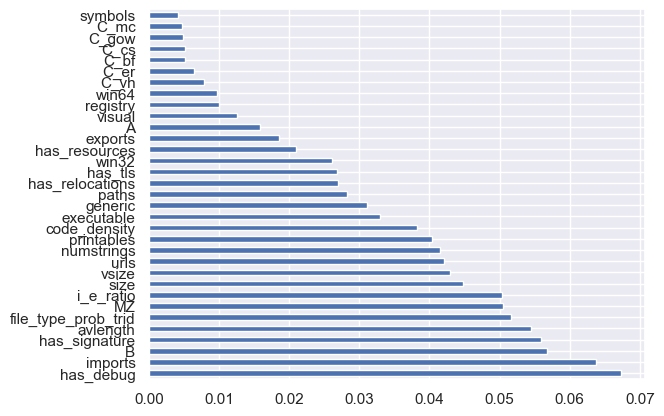

<Figure size 3000x3000 with 0 Axes>

In [112]:
#top important features in data without NaN observations 
try_train_df = Xlog_train.copy()
nan_rows = try_train_df[try_train_df.isnull().any(axis=1)].index

try_train_df = try_train_df.dropna()
X = try_train_df

# Filter ylog_train to include only non-null rows corresponding to X
y = ylog_train.loc[try_train_df.index]

model = ExtraTreesClassifier()
model.fit(X, y)

# Plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(X.shape[1] - 1).plot(kind='barh')
plt.figure(figsize=(30, 30))
plt.show()

features to remove:

features with low variance:
1. symbols
2. registry
3. exports

features that are corr with others:

1. size
2. vsize
3. numstrings


In [113]:
removed_features = ['symbols', 'registry', 'exports', 'size', 'vsize', 'numstrings', ]
Xlog_train.drop(removed_features, axis=1, inplace=True)
Xlog_val.drop(removed_features, axis=1, inplace=True)

c_test.drop(removed_features, axis=1, inplace=True)

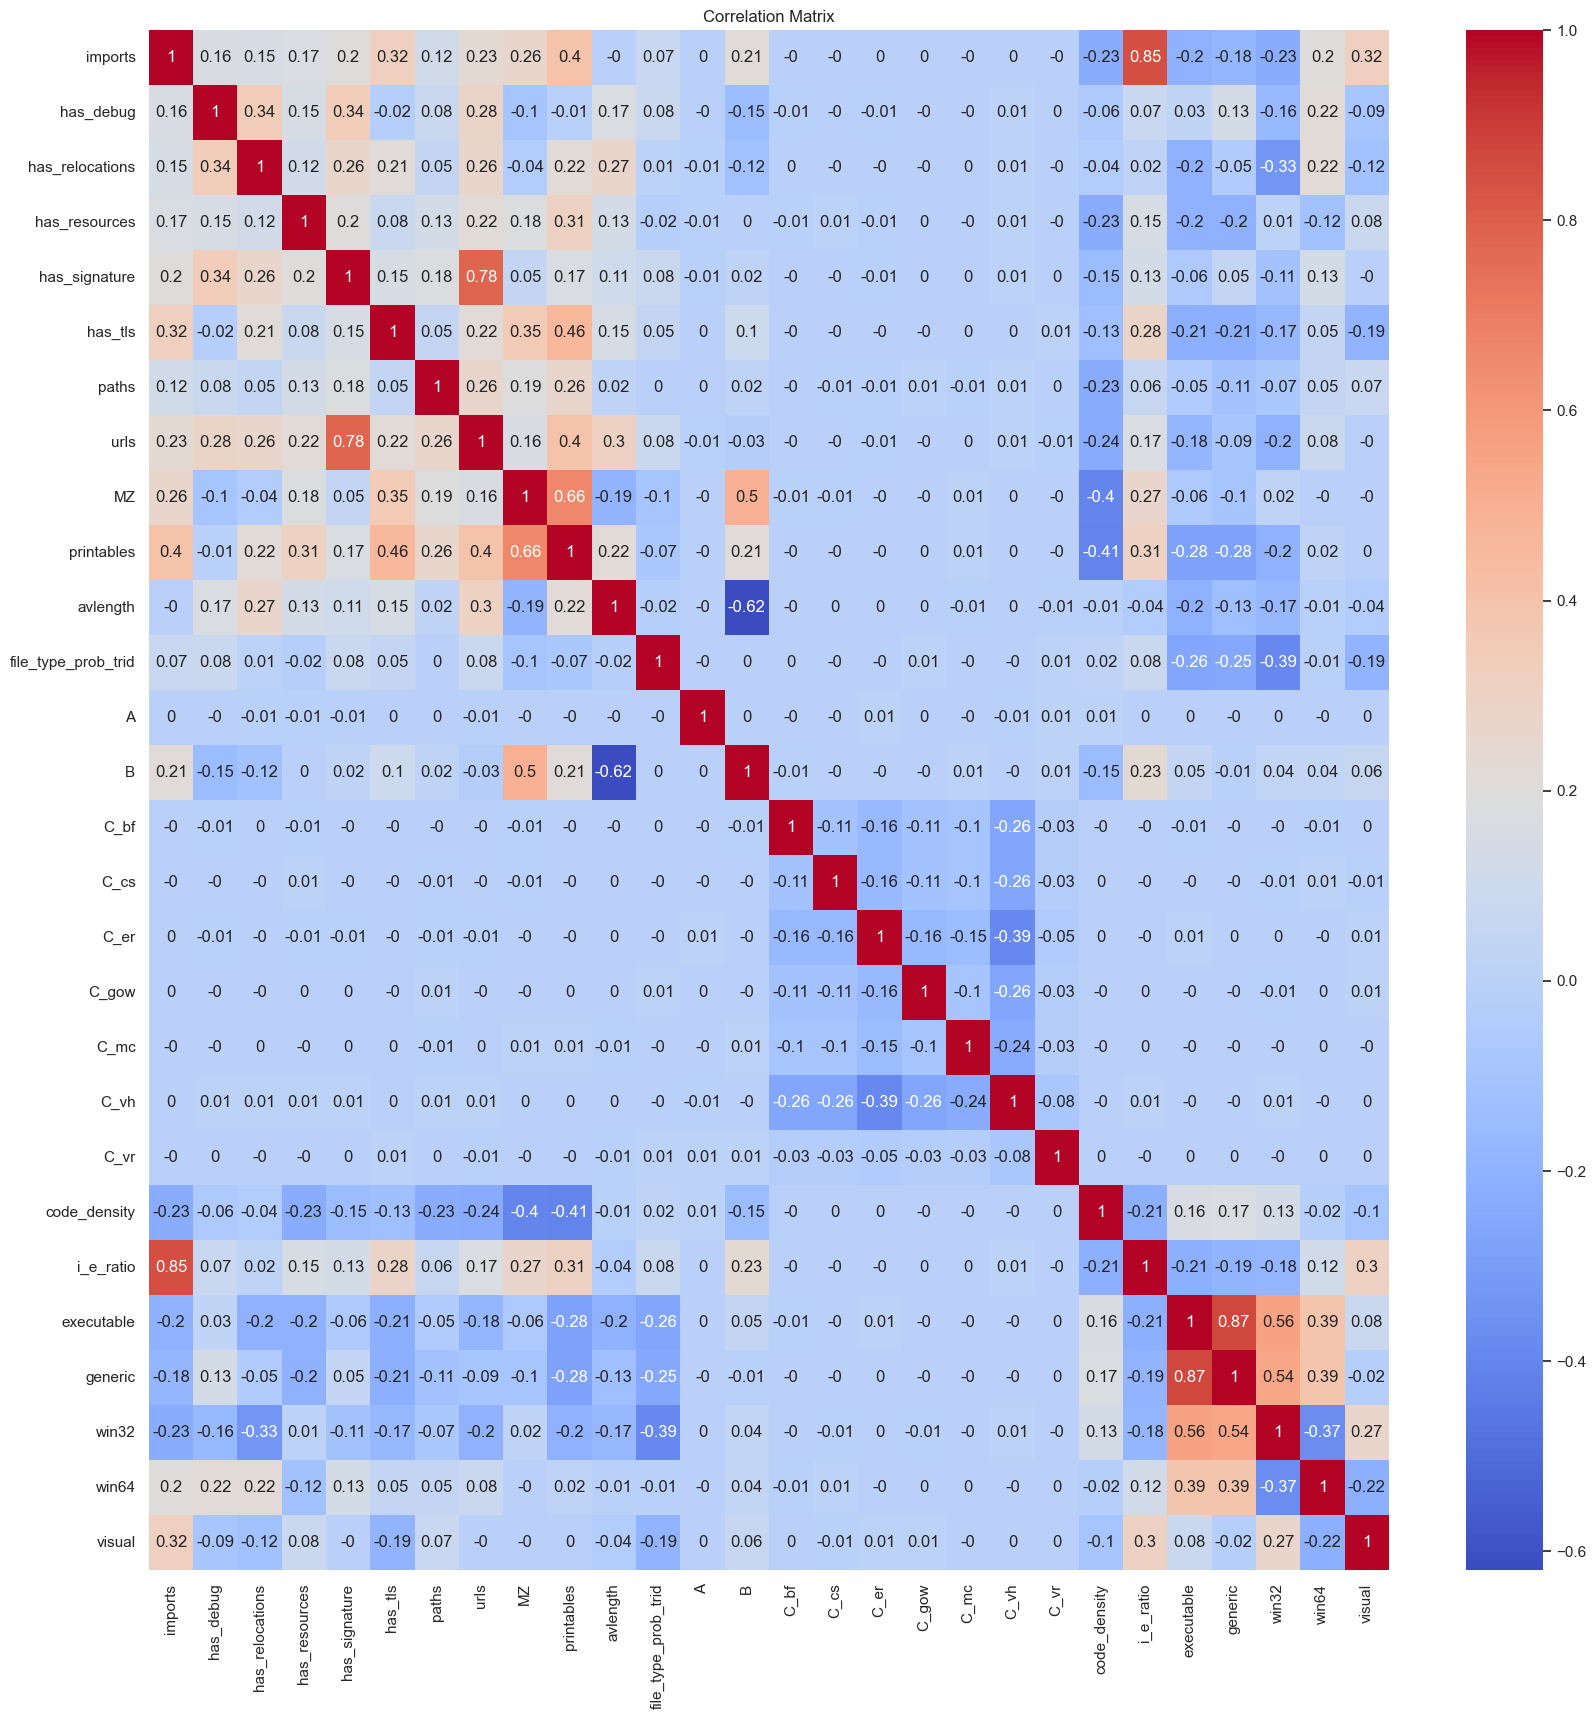

In [114]:
corr_matrix = Xlog_train.corr().round(2)
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.title("Correlation Matrix")
plt.show()

In [115]:
features = Xlog_train.columns.tolist()
print("The features in our final DB are: ", features)

The features in our final DB are:  ['imports', 'has_debug', 'has_relocations', 'has_resources', 'has_signature', 'has_tls', 'paths', 'urls', 'MZ', 'printables', 'avlength', 'file_type_prob_trid', 'A', 'B', 'C_bf', 'C_cs', 'C_er', 'C_gow', 'C_mc', 'C_vh', 'C_vr', 'code_density', 'i_e_ratio', 'executable', 'generic', 'win32', 'win64', 'visual']


before normilization and further preprocessing we will split the test-train data

In [116]:
Xlog_train.head()

imports  has_debug  has_relocations  has_resources  has_signature  \
0  0.301030        1.0              1.0            1.0            0.0   
1  1.544068        1.0              1.0            1.0            0.0   
2  2.394452        1.0              1.0            1.0            1.0   
3  0.477121        0.0              NaN            1.0            0.0   
4  2.264818        NaN              0.0            1.0            0.0   

   has_tls  paths     urls        MZ  printables  avlength  \
0      0.0    0.0  0.00000  0.602060    3.892317       NaN   
1      0.0    0.0  0.30103  0.698970    4.596784  0.836398   
2      1.0    0.0  1.60206  0.954243    4.916749  1.413736   
3      0.0    NaN  0.00000  1.176091         NaN  0.826348   
4      0.0    1.0      NaN       NaN    4.497648  1.027370   

   file_type_prob_trid         A         B  C_bf  C_cs  C_er  C_gow  C_mc  \
0                 70.8  6.369221  5.343785   0.0   0.0   0.0    0.0   0.0   
1                 45.5  4.579615  4.928144   0.0   0.0   0.0    0.0   0.0   
2                 88.3  5.175830  5.833490   0.0   0.0   0.0    0.0   0.0   
3                 42.7  0.323757  6.554471   0.0   0.0   0.0    0.0   0.0   
4                 69.4  3.082603  5.500801   0.0   0.0   0.0    0.0   0.0   

   C_vh  C_vr  code_density  i_e_ratio  executable   generic     win32  win64  \
0   1.0   0.0      0.110114   0.301030    0.174594  0.161164  0.000000    0.0   
1   1.0   0.0      0.028964   1.544068    0.171583  0.158385  0.000000    0.0   
2   1.0   0.0      0.001635   2.394452    0.000000  0.159802  0.000000    0.0   
3   1.0   0.0      0.333166   0.477121    0.530024  0.489254  0.692608    0.0   
4   1.0   0.0      0.013161   2.264818    0.189940  0.000000  0.248204    0.0   

     visual  
0  0.000000  
1  0.000000  
2  0.000000  
3  0.000000  
4  0.374836

Step 2: removing outliers

if feature is normally distributed then we will use boxplot

else: we will use isolation forest

for feature A to remove 1 stds detected 14139 outliers
for feature A to remove 2 stds detected 2309 outliers
for feature A to remove 3 stds detected 365 outliers
for feature code_density to remove 1 stds detected 8376 outliers
for feature code_density to remove 2 stds detected 3038 outliers
for feature code_density to remove 3 stds detected 1492 outliers


for eps = 0.1 removed  47348
for eps = 0.5 removed  45455
for eps = 1 removed  43597
for eps = 1.5 removed  36459
for eps = 2 removed  26401
for eps = 2.5 removed  17548
for eps = 3 removed  11488
for eps = 3.5 removed  7978
for eps = 4 removed  6210
for eps = 4.5 removed  5166
for min_samples = 2 removed  42002
for min_samples = 3 removed  44000
for min_samples = 4 removed  44880
for max_samples = 50 removed  3415
for max_samples = 100 removed  3607
for max_samples = 150 removed  3521
for max_samples = 200 removed  3385
for max_samples = 250 removed  3290
for max_samples = 300 removed  3236
for max_samples = 350 removed  3402
for max_samples = 400 removed  2741
for max_samples = 450 removed  3219


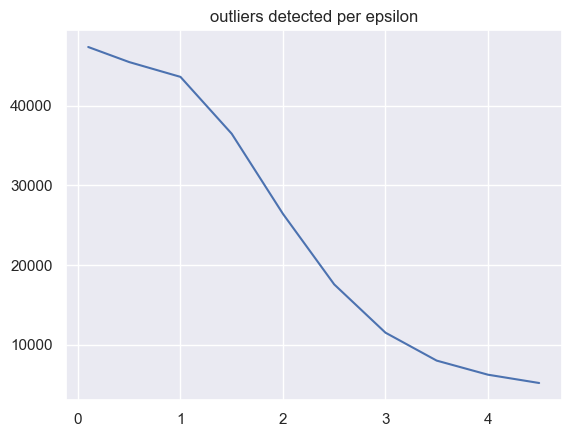

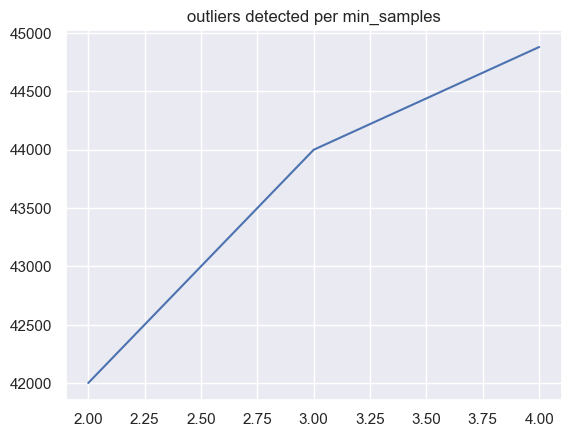

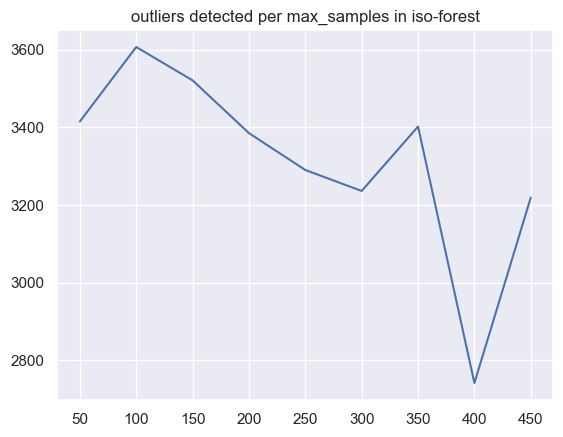

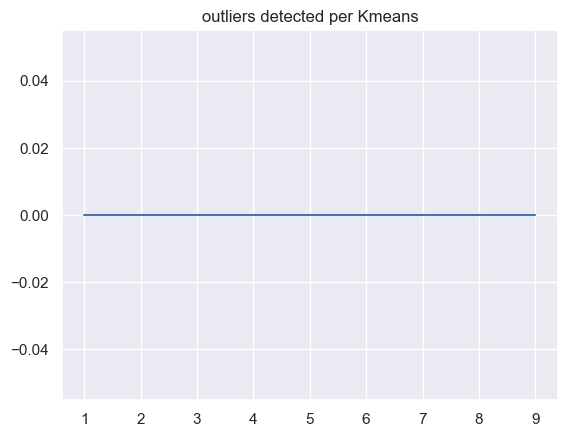

In [117]:
# step 1: using boxplot

normal_features = normal_log+['A', 'code_density']
no_outliers = Xlog_train.copy()
for norm in normal_features:
    for i in range (1,4):
        if (norm in removed_features):
            continue
        removed = Xlog_train[(np.abs(stats.zscore(Xlog_train[norm].fillna(Xlog_train[norm].mean())))>=i)].shape[0]
        print("for feature",norm,'to remove', i,'stds detected',removed,'outliers')
   
   
# step 2: isolation forest
### removing outliers with isolation forest
normal_features = normal_log+['A']
no_outliers.fillna(-999,inplace=True) #we will turn it back to -1
total = Xlog_train.shape[0] # get num of rows
outlier_clf = IsolationForest(max_samples=100, random_state = 1, contamination= 'auto')

epsilons = [0.1, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5]
outliers = []
for ep in epsilons:
    pred = DBSCAN(eps=ep).fit_predict(no_outliers)
    outliers.append(len(pred[pred==-1]))
    print('for eps =',ep, 'removed ',len(pred[pred==-1]))

samples_outliers = []
min_samples = list(range(2, 5))
for min in min_samples:
    pred = DBSCAN(min_samples=min).fit_predict(no_outliers)
    samples_outliers.append(len(pred[pred==-1]))
    print('for min_samples =',min, 'removed ',len(pred[pred==-1]))

iso_samples = list(range(50, 500, 50))
iso_outliers = []
for max_samp in iso_samples:
    pred = IsolationForest(max_samples=max_samp).fit_predict(no_outliers)
    iso_outliers.append(len(pred[pred==-1]))
    print('for max_samples =',max_samp, 'removed ',len(pred[pred==-1]))


Ks = list(range(1, 10))
k_outliers=[]

for k in Ks:
    pred = KMeans(n_clusters=k).fit_predict(no_outliers)
    k_outliers.append(len(pred[pred==-1]))
plt.plot(epsilons, outliers)
plt.title("outliers detected per epsilon")
plt.show()

plt.plot(min_samples, samples_outliers)
plt.title("outliers detected per min_samples")
plt.show()


plt.plot(iso_samples, iso_outliers)
plt.title("outliers detected per max_samples in iso-forest")
plt.show()


plt.plot(Ks, k_outliers)
plt.title("outliers detected per Kmeans")
plt.show()

no_outliers.replace(-999, np.nan, inplace=True)

In [118]:
print(ylog_train.shape)

(48000,)


In [119]:
Xlog_train = no_outliers.copy() #### we do copy just so we can re-run this cell
for norm in ['A', 'code_density']: ### outlier removal via boxplot
    if not (norm in removed_features):
        print('removing outliers by feature', norm)
        ylog_train = ylog_train[(np.abs(stats.zscore(Xlog_train[norm], nan_policy='omit'))<3)]
        Xlog_train = Xlog_train[(np.abs(stats.zscore(Xlog_train[norm], nan_policy='omit'))<3)]
    


mask = (DBSCAN(eps=3).fit_predict(Xlog_train.fillna(-999))!=-1)
Xlog_train = Xlog_train[mask] ### outlier removal via dbscan
ylog_train = ylog_train[mask]

removing outliers by feature A
removing outliers by feature code_density


In [120]:
Xlog_train.isnull().mean()*100

imports                1.599589
has_debug              2.670013
has_relocations        3.063107
has_resources          1.496780
has_signature          1.460494
has_tls                2.546037
paths                  3.634604
urls                   1.908016
MZ                     2.984488
printables             2.591394
avlength               2.437181
file_type_prob_trid    0.000000
A                      0.000000
B                      3.776723
C_bf                   0.000000
C_cs                   0.000000
C_er                   0.000000
C_gow                  0.000000
C_mc                   0.000000
C_vh                   0.000000
C_vr                   0.000000
code_density           0.000000
i_e_ratio              3.187082
executable             0.000000
generic                0.000000
win32                  0.000000
win64                  0.000000
visual                 0.000000
dtype: float64

In [121]:
c_test.isnull().mean()*100

imports                 7.077778
has_debug               8.966667
has_relocations         5.527778
has_resources           3.488889
has_signature           3.083333
has_tls                 4.922222
paths                   6.388889
urls                    4.194444
MZ                      4.922222
printables              4.677778
avlength                4.405556
file_type_prob_trid     0.000000
A                       6.516667
B                       6.322222
C_bf                    0.000000
C_cs                    0.000000
C_er                    0.000000
C_gow                   0.000000
C_mc                    0.000000
C_vh                    0.000000
C_vr                    0.000000
code_density            3.177778
i_e_ratio              22.150000
executable              0.000000
generic                 0.000000
win32                   0.000000
win64                   0.000000
visual                  0.000000
dtype: float64

after we dealt with outliers, we can now deal with missing values

In [122]:
#dealing with missing values in categorial features

boolean_features = [cat for cat in features if ('has' in cat)]
print(boolean_features)
#TO-CHECK
for feature in boolean_features:
    mode_value = Xlog_train[feature].mode()[0]
    Xlog_train[feature].fillna(mode_value, inplace=True)  # Fill NaN with mode (the most frequently occurring value)
    Xlog_val[feature].fillna(mode_value, inplace=True)
    c_test[feature].fillna(mode_value, inplace=True)
    
# Fill in the interactions

'''
1. has_debug==0 ^ has_signature==0
2. has_debug==0 ^ has_tls==0
3. has_debug==0 ^ has_relocations==0
4. has_debug==0 ^ has_resources==1
5. has_resources==0 ^ has_relocations==0
'''   

for i in range(len(boolean_features)-1):
    for j in range(i+1, len(boolean_features)):
        feat1 = boolean_features[i]
        feat2 = boolean_features[j]
        Xlog_train[feat1+" * "+feat2] = Xlog_train[feat1]*Xlog_train[feat2]
        Xlog_val[feat1+" * "+feat2] = Xlog_val[feat1]*Xlog_val[feat2]
        c_test[feat1+" * "+feat2] = c_test[feat1]*c_test[feat2]
#cat_df.drop(bool_features)
#cat_df['suspicious_combos'] = np.sum(cat_df[cross_feat], axis=1)
#c_test['suspicious_combos'] = c_test[cross_feat].sum(axis=0)
#numerical += ['suspicious_combos']
#cat_df['suspicious_combos'].head(10)
#cat_df.drop(cross_feat, axis=1, inplace=True)
#c_test.drop(cross_feat, axis=1, inplace=True)


['has_debug', 'has_relocations', 'has_resources', 'has_signature', 'has_tls']


In [123]:
#dealing with missing values in numeric features
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
for numeric in numerical:
    if numeric in removed_features:
        continue
    # Fill NaN values with the mean
    #TO-CHECK
    Xlog_train[numeric] = imputer.fit_transform(Xlog_train[[numeric]])
    Xlog_val[numeric] = imputer.transform(Xlog_val[[numeric]])
    c_test[numeric] = imputer.transform(c_test[[numeric]])



#from now on we will work with test_df
test_df = c_test.copy()

In [124]:
Xlog_train.isnull().mean()*100
Xlog_val.isnull().mean()*100

imports                            0.0
has_debug                          0.0
has_relocations                    0.0
has_resources                      0.0
has_signature                      0.0
has_tls                            0.0
paths                              0.0
urls                               0.0
MZ                                 0.0
printables                         0.0
avlength                           0.0
file_type_prob_trid                0.0
A                                  0.0
B                                  0.0
C_bf                               0.0
C_cs                               0.0
C_er                               0.0
C_gow                              0.0
C_mc                               0.0
C_vh                               0.0
C_vr                               0.0
code_density                       0.0
i_e_ratio                          0.0
executable                         0.0
generic                            0.0
win32                    

In [125]:
c_test.isnull().mean()*100

imports                            0.0
has_debug                          0.0
has_relocations                    0.0
has_resources                      0.0
has_signature                      0.0
has_tls                            0.0
paths                              0.0
urls                               0.0
MZ                                 0.0
printables                         0.0
avlength                           0.0
file_type_prob_trid                0.0
A                                  0.0
B                                  0.0
C_bf                               0.0
C_cs                               0.0
C_er                               0.0
C_gow                              0.0
C_mc                               0.0
C_vh                               0.0
C_vr                               0.0
code_density                       0.0
i_e_ratio                          0.0
executable                         0.0
generic                            0.0
win32                    

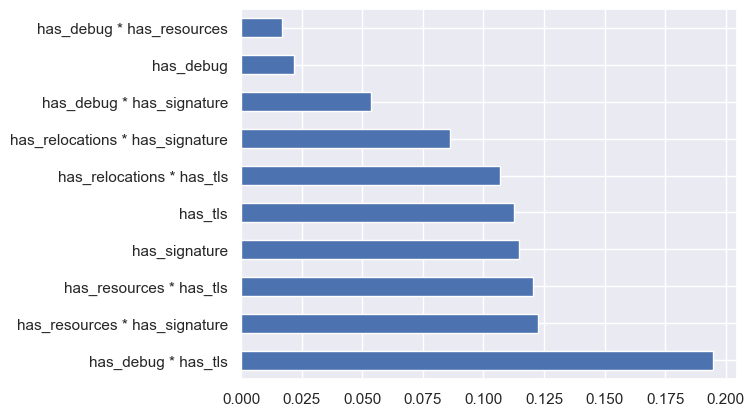

In [126]:
#top 10 most important features in data
X_test = test_df.copy()
X = Xlog_train.iloc[:,1:Xlog_train.shape[1]-1]  #independent columns
y = Xlog_train.iloc[:,-1]    #target column i.e price range
model = ExtraTreesClassifier()
model.fit(X,y)
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [127]:
print(test_df.shape)

print(Xlog_train.shape)

print(Xlog_val.shape)

(18000, 38)
(33071, 38)
(12000, 38)


In [128]:
test_df.head()

imports  has_debug  has_relocations  has_resources  has_signature  has_tls  \
0      2.0        0.0              0.0            1.0            0.0      0.0   
1    136.0        1.0              1.0            1.0            0.0      0.0   
2    124.0        0.0              1.0            1.0            0.0      0.0   
3      0.0        1.0              1.0            1.0            0.0      0.0   
4    165.0        0.0              0.0            1.0            0.0      0.0   

   paths  urls    MZ  printables   avlength  file_type_prob_trid         A  \
0    0.0   0.0  14.0     22934.0   5.703556                 42.7 -1.414118   
1    1.0   0.0   5.0      7445.0  20.397260                 48.8  3.531508   
2   12.0   0.0   9.0    148608.0  11.072796                 24.1 -1.713507   
3    0.0   0.0   2.0    121156.0  18.679618                 33.1  9.215390   
4    4.0   0.0   2.0     21562.0   7.528631                 84.4  2.224768   

          B  C_bf  C_cs  C_er  C_gow  C_mc  C_vh  C_vr  code_density  \
0  6.554459   0.0   0.0   1.0    0.0   0.0   0.0   0.0     1107762.0   
1  5.581053   0.0   1.0   0.0    0.0   0.0   0.0   0.0       83968.0   
2  6.103680   0.0   0.0   0.0    0.0   0.0   1.0   0.0    -2972672.0   
3  5.418556   0.0   0.0   0.0    0.0   0.0   1.0   0.0        7680.0   
4  5.870363   0.0   0.0   1.0    0.0   0.0   0.0   0.0       24576.0   

    i_e_ratio  executable   generic     win32  win64    visual  \
0    1.255273    0.530024  0.489254  0.692608    0.0  0.000000   
1  136.000000    0.287124  0.265038  0.375198    0.0  0.566620   
2  123.000000    0.000000  0.000000  0.000000    0.0  0.000000   
3    0.000000    0.530024  0.489254  0.692608    0.0  0.000000   
4  165.000000    0.189940  0.000000  0.248204    0.0  0.374836   

   has_debug * has_relocations  has_debug * has_resources  \
0                          0.0                        0.0   
1                          1.0                        1.0   
2                          0.0                        0.0   
3                          1.0                        1.0   
4                          0.0                        0.0   

   has_debug * has_signature  has_debug * has_tls  \
0                        0.0                  0.0   
1                        0.0                  0.0   
2                        0.0                  0.0   
3                        0.0                  0.0   
4                        0.0                  0.0   

   has_relocations * has_resources  has_relocations * has_signature  \
0                              0.0                              0.0   
1                              1.0                              0.0   
2                              1.0                              0.0   
3                              1.0                              0.0   
4                              0.0                              0.0   

   has_relocations * has_tls  has_resources * has_signature  \
0                        0.0                            0.0   
1                        0.0                            0.0   
2                        0.0                            0.0   
3                        0.0                            0.0   
4                        0.0                            0.0   

   has_resources * has_tls  has_signature * has_tls  
0                      0.0                      0.0  
1                      0.0                      0.0  
2                      0.0                      0.0  
3                      0.0                      0.0  
4                      0.0                      0.0

In [129]:
Xlog_train.head()

imports  has_debug  has_relocations  has_resources  has_signature  \
0  0.301030        1.0              1.0            1.0            0.0   
1  1.544068        1.0              1.0            1.0            0.0   
2  2.394452        1.0              1.0            1.0            1.0   
5  1.113943        0.0              1.0            1.0            0.0   
6  2.136721        1.0              1.0            1.0            0.0   

   has_tls  paths     urls        MZ  printables  avlength  \
0      0.0    0.0  0.00000  0.602060    3.892317  1.110554   
1      0.0    0.0  0.30103  0.698970    4.596784  0.836398   
2      1.0    0.0  1.60206  0.954243    4.916749  1.413736   
5      0.0    0.0  0.00000  1.322219    4.400987  0.901870   
6      0.0    0.0  0.00000  0.477121    4.328094  0.936237   

   file_type_prob_trid         A         B  C_bf  C_cs  C_er  C_gow  C_mc  \
0                 70.8  6.369221  5.343785   0.0   0.0   0.0    0.0   0.0   
1                 45.5  4.579615  4.928144   0.0   0.0   0.0    0.0   0.0   
2                 88.3  5.175830  5.833490   0.0   0.0   0.0    0.0   0.0   
5                 38.7 -7.467456  6.498198   0.0   0.0   0.0    0.0   0.0   
6                 38.4  9.446664  6.037830   0.0   0.0   0.0    0.0   0.0   

   C_vh  C_vr  code_density  i_e_ratio  executable   generic     win32  win64  \
0   1.0   0.0      0.110114   0.301030    0.174594  0.161164  0.000000    0.0   
1   1.0   0.0      0.028964   1.544068    0.171583  0.158385  0.000000    0.0   
2   1.0   0.0      0.001635   2.394452    0.000000  0.159802  0.000000    0.0   
5   1.0   0.0      0.235508   0.636822    0.191556  0.176822  0.000000    0.0   
6   1.0   0.0      0.016210   1.835691    0.000000  0.182318  0.258097    0.0   

     visual  has_debug * has_relocations  has_debug * has_resources  \
0  0.000000                          1.0                        1.0   
1  0.000000                          1.0                        1.0   
2  0.000000                          1.0                        1.0   
5  0.378024                          0.0                        0.0   
6  0.000000                          1.0                        1.0   

   has_debug * has_signature  has_debug * has_tls  \
0                        0.0                  0.0   
1                        0.0                  0.0   
2                        1.0                  1.0   
5                        0.0                  0.0   
6                        0.0                  0.0   

   has_relocations * has_resources  has_relocations * has_signature  \
0                              1.0                              0.0   
1                              1.0                              0.0   
2                              1.0                              1.0   
5                              1.0                              0.0   
6                              1.0                              0.0   

   has_relocations * has_tls  has_resources * has_signature  \
0                        0.0                            0.0   
1                        0.0                            0.0   
2                        1.0                            1.0   
5                        0.0                            0.0   
6                        0.0                            0.0   

   has_resources * has_tls  has_signature * has_tls  
0                      0.0                      0.0  
1                      0.0                      0.0  
2                      1.0                      1.0  
5                      0.0                      0.0  
6                      0.0                      0.0

In [130]:
# normalizing the data

#log_removed_features = ['sha256','file_type_trid', 'avlength']
#log_removed_features = ['sha256','size', 'vsize', 'avlength', 'numstrings', 'file_type_prob_trid', 'file_type_trid']
#st_removed_featuers  = ['sha256','size', 'vsize', 'numstrings', 'file_type_prob_trid','file_type_trid']

sc = StandardScaler()

for col in X_test.columns:
    Xlog_train[col] = sc.fit_transform(Xlog_train[col].values.reshape(-1, 1))
    Xlog_val[col] = sc.transform(Xlog_val[col].values.reshape(-1, 1))
    X_test[col] = sc.transform(X_test[col].values.reshape(-1, 1))
    
Xlog_train.describe()

#log_test.drop(log_removed_features, axis=1, inplace=True)

imports     has_debug  has_relocations  has_resources  \
count  3.307100e+04  3.307100e+04     3.307100e+04   3.307100e+04   
mean  -8.046272e-17 -8.073129e-17     3.136864e-17   9.775844e-17   
std    1.000015e+00  1.000015e+00     1.000015e+00   1.000015e+00   
min   -1.508576e+00 -8.079643e-01    -1.127269e+00  -2.484078e+00   
25%   -1.174629e+00 -8.079643e-01    -1.127269e+00   4.025639e-01   
50%    9.682788e-02 -8.079643e-01     8.870995e-01   4.025639e-01   
75%    9.086708e-01  1.237679e+00     8.870995e-01   4.025639e-01   
max    2.565269e+00  1.237679e+00     8.870995e-01   4.025639e-01   

       has_signature       has_tls         paths          urls            MZ  \
count   3.307100e+04  3.307100e+04  3.307100e+04  3.307100e+04  3.307100e+04   
mean   -6.142131e-17  3.480630e-17  7.928102e-17  3.480630e-17 -5.773119e-16   
std     1.000015e+00  1.000015e+00  1.000015e+00  1.000015e+00  1.000015e+00   
min    -5.683764e-01 -5.363872e-01 -4.811471e-01 -6.995836e-01 -1.090952e+00   
25%    -5.683764e-01 -5.363872e-01 -4.811471e-01 -6.995836e-01 -1.090952e+00   
50%    -5.683764e-01 -5.363872e-01 -4.811471e-01 -6.995836e-01 -1.827390e-01   
75%    -5.683764e-01 -5.363872e-01 -4.811471e-01  8.794902e-01  6.850123e-01   
max     1.759398e+00  1.864325e+00  1.102744e+01  4.974655e+00  6.169624e+00   

         printables      avlength  file_type_prob_trid             A  \
count  3.307100e+04  3.307100e+04         3.307100e+04  3.307100e+04   
mean   6.658854e-16  1.265488e-16        -7.584336e-17  2.803841e-17   
std    1.000015e+00  1.000015e+00         1.000015e+00  1.000015e+00   
min   -3.824384e+00 -1.208500e+00        -1.635327e+00 -3.327318e+00   
25%   -5.786185e-01 -7.349382e-01        -7.229484e-01 -6.954710e-01   
50%    7.938781e-02 -1.103170e-01        -5.142661e-01 -4.219407e-02   
75%    6.212854e-01  3.726527e-01         7.135624e-01  6.470287e-01   
max    3.487089e+00  9.329472e+00         2.266547e+00  3.410419e+00   

                  B          C_bf          C_cs          C_er         C_gow  \
count  3.307100e+04  3.307100e+04  3.307100e+04  3.307100e+04  3.307100e+04   
mean   7.081579e-16  4.017765e-17  6.246872e-17  3.910338e-17  1.063526e-17   
std    1.000015e+00  1.000015e+00  1.000015e+00  1.000015e+00  1.000015e+00   
min   -8.634131e+00 -3.286038e-01 -3.329917e-01 -4.848697e-01 -3.186254e-01   
25%   -5.367452e-01 -3.286038e-01 -3.329917e-01 -4.848697e-01 -3.186254e-01   
50%    7.638965e-02 -3.286038e-01 -3.329917e-01 -4.848697e-01 -3.186254e-01   
75%    8.172659e-01 -3.286038e-01 -3.329917e-01 -4.848697e-01 -3.186254e-01   
max    1.278835e+00  3.043179e+00  3.003078e+00  2.062410e+00  3.138481e+00   

               C_mc          C_vh          C_vr  code_density     i_e_ratio  \
count  3.307100e+04  3.307100e+04  3.307100e+04  3.307100e+04  3.307100e+04   
mean  -1.273008e-17  2.288192e-17 -5.929963e-17 -1.020555e-17 -1.751058e-16   
std    1.000015e+00  1.000015e+00  1.000015e+00  1.000015e+00  1.000015e+00   
min   -3.077397e-01 -7.997074e-01 -1.019201e-01 -4.313486e+00 -5.202227e+00   
25%   -3.077397e-01 -7.997074e-01 -1.019201e-01 -3.383833e-01 -1.036777e+00   
50%   -3.077397e-01 -7.997074e-01 -1.019201e-01 -2.705105e-01  4.748362e-02   
75%   -3.077397e-01  1.250457e+00 -1.019201e-01  5.656933e-01  9.795223e-01   
max    3.249499e+00  1.250457e+00  9.811608e+00  4.098838e+00  2.793817e+00   

         executable       generic         win32         win64        visual  \
count  3.307100e+04  3.307100e+04  3.307100e+04  3.307100e+04  3.307100e+04   
mean   6.665837e-17 -4.763710e-17  9.982641e-17  4.404501e-18 -2.406362e-17   
std    1.000015e+00  1.000015e+00  1.000015e+00  1.000015e+00  1.000015e+00   
min   -1.338979e+00 -1.510225e+00 -8.431044e-01 -4.489750e-01 -4.970647e-01   
25%   -1.338979e+00 -5.093758e-01 -8.431044e-01 -4.489750e-01 -4.970647e-01   
50%    2.226496e-01  1.645726e-01 -8.431044e-01 -4.489750e-01 -4.970647e-01   
75%    8.429480e-01  8.298229e-01  6.524101

In [131]:
### define a functino that will perform a grid search on model

def getBestModel(estimator, params, XTrain, ytrain, XTest, ytest, v=3, nj=1):
    cv = GridSearchCV(estimator= estimator, param_grid=params, verbose=v, scoring='roc_auc', cv=3, n_jobs=nj)
    cv.fit(XTrain, ytrain)
    print("Best Parameters:",  cv.best_params_)
    print("With the CV score of",cv.best_score_)
    pred = cv.predict_proba(XTest)[:,1]
    val_auc = metrics.roc_auc_score(ytest, pred)
    print('validation AUC:',val_auc)
    return cv.best_estimator_

In [132]:
#PCA dimension reduction

cont_features = ['paths' ,'urls', 'MZ', 'printables', 'avlength', 'A', 'B', 'code_density', 'i_e_ratio', 'imports']
# labels
#lr = LogisticRegression(penalty = 'l2', solver="liblinear")

# we will do PCA in order to further reduce dimensions
for variance in [0.5, 0.6, 0.7, .8, .9, 0.95, 0.99, 0.995, .9999]:
    pca = PCA(variance)
    data = pca.fit_transform(Xlog_train)
    print("For explained variance:", variance, "number of dimensions:", data.shape[1])
#log_train = scaler.fit_transform(X_log)
pca = PCA(0.99)


X_train_reduced = pca.fit_transform(Xlog_train)
X_val_reduced = pca.transform(Xlog_val)
test_reduced = pca.transform(X_test)
#X_log_reduced = X_log

powers = range(-10,1)
Cs = [10**p for p in powers] #This is the inverse value for the lambda parameter.



lr = LogisticRegression(solver = 'liblinear', penalty = 'l2')
params = {'C' : Cs,
         'fit_intercept' : [True, False]}
best_model = getBestModel(lr, params, X_train_reduced, ylog_train, X_val_reduced, ylog_val)


For explained variance: 0.5 number of dimensions: 6
For explained variance: 0.6 number of dimensions: 8
For explained variance: 0.7 number of dimensions: 11
For explained variance: 0.8 number of dimensions: 15
For explained variance: 0.9 number of dimensions: 19
For explained variance: 0.95 number of dimensions: 23
For explained variance: 0.99 number of dimensions: 31
For explained variance: 0.995 number of dimensions: 33
For explained variance: 0.9999 number of dimensions: 38
Fitting 3 folds for each of 22 candidates, totalling 66 fits
[CV 1/3] END .......C=1e-10, fit_intercept=True;, score=0.780 total time=   0.0s
[CV 2/3] END .......C=1e-10, fit_intercept=True;, score=0.782 total time=   0.0s
[CV 3/3] END .......C=1e-10, fit_intercept=True;, score=0.777 total time=   0.0s
[CV 1/3] END ......C=1e-10, fit_intercept=False;, score=0.780 total time=   0.0s
[CV 2/3] END ......C=1e-10, fit_intercept=False;, score=0.782 total time=   0.0s
[CV 3/3] END ......C=1e-10, fit_intercept=False;, sc

Backwards selection: we will write one function to remove a feature and another to remove many

we will remove each feature via a greedy algorithm according to a kfold score of auc

In [133]:
pd.DataFrame(X_train_reduced).head()

0         1         2         3         4         5         6   \
0 -0.137540  1.547434 -2.719057 -0.086349  1.421077  0.162446  0.237293   
1  0.404826  0.801509 -1.831958  0.765816  2.183979  0.372416 -0.246598   
2  7.832008 -0.973567 -0.118022 -1.248754 -1.151970 -1.472724 -1.301022   
3 -1.364027 -1.066515 -0.061324  0.983457  0.591695  0.661012  1.346055   
4  0.294934  0.439804 -1.181362  1.107590  2.478951  0.143457 -0.404871   

         7         8         9         10        11        12        13  \
0 -1.526516 -1.671530  0.187697 -0.130782 -0.032940  0.004195  0.027435   
1 -1.448643 -0.960982  0.139810 -0.188025 -0.024251 -0.107220 -0.046211   
2 -1.451102 -0.885886  0.238273 -0.391191 -0.105350 -0.241680 -0.076083   
3 -1.520341 -0.356022  0.216254 -1.513038 -0.196207 -0.751884 -0.806423   
4 -1.417507 -1.370383  0.146348 -0.858337 -0.210854 -0.387705 -0.214809   

         14        15        16        17        18        19        20  \
0  0.087804 -0.447958 -0.154028  0.104490 -0.522837  0.267373 -0.268817   
1 -0.033753 -0.145201 -0.492699  0.297671  0.095700 -0.339240  0.379508   
2 -0.109471 -0.324347 -0.443532  0.045707 -0.441199  0.651405 -0.145793   
3 -0.619612  1.780968  0.209838  0.246863  0.037386  0.143184 -1.512848   
4  0.243949 -0.981902 -0.581258  0.529877  0.161368 -0.831377  0.850331   

         21        22        23        24        25        26        27  \
0  0.240080  0.391694 -0.414342  0.226776  0.002037  0.132944  0.073003   
1 -0.529648  0.794647 -1.047046  0.809921 -0.973501 -0.084933 -0.215136   
2 -0.697133  0.048275  0.219524 -0.017108  0.068963 -0.056263 -0.104728   
3  0.054317  0.554761  0.215023 -0.657347 -0.195175  0.200677 -0.359840   
4 -0.850592 -0.478977 -0.176552  0.516648 -0.220413  0.280570  0.153465   

         28        29        30  
0 -0.162142 -0.213063 -0.377986  
1 -0.090245 -0.346737 -0.316919  
2  0.003027 -0.112177 -0.005649  
3 -0.147370  0.059268  0.310477  
4 -0.080696  0.088101  0.021047

In [134]:

def get_score(estimator, X, y):
    cv = 3
    kf = KFold(shuffle=True, n_splits=cv, random_state=0)
    score = 0
    for train_index, test_index in kf.split(X):
        estimator.fit(X.iloc[train_index], y.iloc[train_index])
        pred = estimator.predict_proba(X.iloc[test_index])[:, 1]
        score += metrics.roc_auc_score(y.iloc[test_index], pred)
    return score / cv


def remove_feature(estimator, X, y):
    features = list(X.columns)
    best_features = None
    best_score = 0
    for i in range(len(features)):
        curr_features = features[:i] + features[i + 1:]
        score = get_score(estimator, X[curr_features], y)
        if score > best_score:
            best_score = score
            best_features = curr_features.copy()
    return best_features


def backward_selection(estimator, X, y):
    best_features = list(X.columns)
    prev_score = 0
    while len(best_features) > 1:
        current_features = remove_feature(estimator, X[best_features], y)
        curr_score = get_score(estimator, X[current_features], y)
        if curr_score < prev_score:
            break
        best_features = current_features.copy()
        prev_score = curr_score
    return best_features



In [136]:
r_clf = ensemble.RandomForestClassifier(random_state=0, n_estimators=300)
gbm_clf = ensemble.GradientBoostingClassifier(random_state=0)
ada_clf = ensemble.AdaBoostClassifier(random_state=0)
ada_params = {'n_estimators' : [25, 50, 100],
              'learning_rate' : [0.1, 0.5, 0.7, 1],}
gbm_params = {'learning_rate' : [0.15],
              'max_depth' : [15],
              'max_features' : [.3],
              'n_estimators' : [200]}
r_params = {'max_features' : [0.5, 0.3, 'sqrt', 0.1, 0.2]}

best_model = getBestModel(gbm_clf, gbm_params, Xlog_train, ylog_train, Xlog_val, ylog_val, nj = None)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END learning_rate=0.15, max_depth=15, max_features=0.3, n_estimators=200;, score=0.981 total time=  35.9s
[CV 2/3] END learning_rate=0.15, max_depth=15, max_features=0.3, n_estimators=200;, score=0.981 total time=  36.1s
[CV 3/3] END learning_rate=0.15, max_depth=15, max_features=0.3, n_estimators=200;, score=0.982 total time=  35.7s
Best Parameters: {'learning_rate': 0.15, 'max_depth': 15, 'max_features': 0.3, 'n_estimators': 200}
With the CV score of 0.981341813986111
validation AUC: 0.9779432577320734


In [ ]:
# r_model = getBestModel(r_clf, r_params, Xlog_train, ylog_train, Xlog_val, ylog_val)

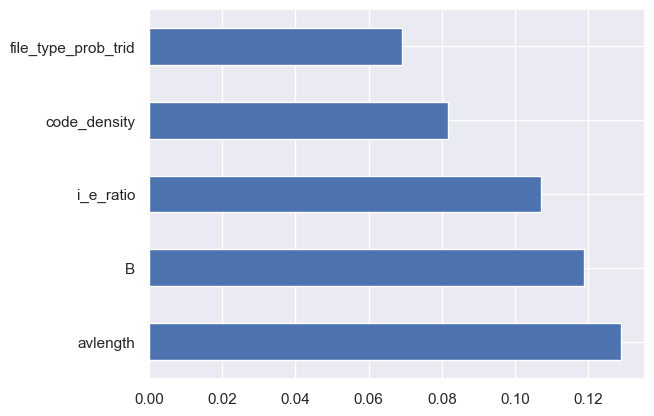

In [ ]:
feat_importances = pd.Series(best_model.feature_importances_, index=Xlog_train.columns)
feat_importances.nlargest().plot(kind='barh')
plt.show()

In [ ]:
mlp_clf = MLPClassifier(solver='sgd', activation='relu')
mlp_params = {'alpha' : [0.01, .1, 1],
          'learning_rate_init' : [0.001, 0.1]}

mlp_cv = getBestModel(mlp_clf, mlp_params, X_train_reduced, ylog_train, X_val_reduced, ylog_val, nj = None)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END alpha=0.01, learning_rate_init=0.001;, score=0.936 total time=  15.2s
[CV 2/3] END alpha=0.01, learning_rate_init=0.001;, score=0.937 total time=  15.1s
[CV 3/3] END alpha=0.01, learning_rate_init=0.001;, score=0.936 total time=  15.0s
[CV 1/3] END alpha=0.01, learning_rate_init=0.1;, score=0.948 total time=   7.0s
[CV 2/3] END alpha=0.01, learning_rate_init=0.1;, score=0.944 total time=   7.0s
[CV 3/3] END alpha=0.01, learning_rate_init=0.1;, score=0.945 total time=   7.5s
[CV 1/3] END alpha=0.1, learning_rate_init=0.001;, score=0.937 total time=  14.9s
[CV 2/3] END alpha=0.1, learning_rate_init=0.001;, score=0.935 total time=  15.0s
[CV 3/3] END alpha=0.1, learning_rate_init=0.001;, score=0.936 total time=  14.9s
[CV 1/3] END .alpha=0.1, learning_rate_init=0.1;, score=0.952 total time=   6.6s
[CV 2/3] END .alpha=0.1, learning_rate_init=0.1;, score=0.946 total time=   9.0s
[CV 3/3] END .alpha=0.1, learning_rate_i

In [ ]:
knn = KNeighborsClassifier()
kparams = {'n_neighbors': range(1, 100, 10)}
knn_cv = getBestModel(knn, kparams, X_train_reduced, ylog_train, X_val_reduced, ylog_val, nj = None)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END .....................n_neighbors=1;, score=0.847 total time=   0.1s
[CV 2/3] END .....................n_neighbors=1;, score=0.851 total time=   0.1s
[CV 3/3] END .....................n_neighbors=1;, score=0.846 total time=   0.1s
[CV 1/3] END ....................n_neighbors=11;, score=0.924 total time=   0.1s
[CV 2/3] END ....................n_neighbors=11;, score=0.926 total time=   0.1s
[CV 3/3] END ....................n_neighbors=11;, score=0.920 total time=   0.1s
[CV 1/3] END ....................n_neighbors=21;, score=0.919 total time=   0.1s
[CV 2/3] END ....................n_neighbors=21;, score=0.919 total time=   0.1s
[CV 3/3] END ....................n_neighbors=21;, score=0.912 total time=   0.1s
[CV 1/3] END ....................n_neighbors=31;, score=0.913 total time=   0.1s
[CV 2/3] END ....................n_neighbors=31;, score=0.913 total time=   0.1s
[CV 3/3] END ....................n_neighbors=31;